***

# *Part One: Statistical Analysis of Ether Price Time Serie*

***

In [6]:
# import Libraries

from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [7]:
# import data file
df_orig=pd.read_csv('C:\\Users\\98912\\Binance_ETHUSDT_d.csv', parse_dates=['date'], index_col='date' )
df_orig=df_orig[::-1]
df=df_orig[['open']]
df.head()


open
date              
2017-08-17  303.61
2017-08-18  302.00
2017-08-19  293.96
2017-08-20  290.91
2017-08-21  299.10

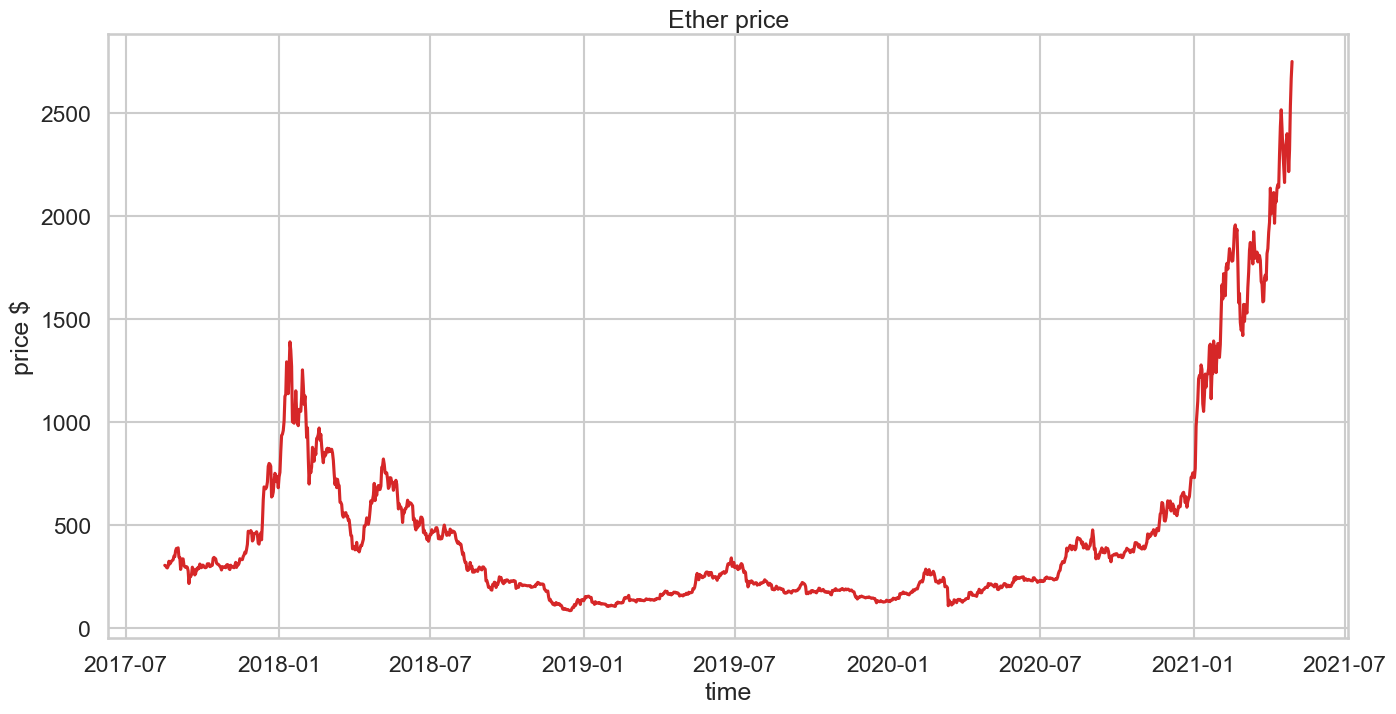

In [84]:
# visualizing the price time seris
plt.figure(figsize=(16,8), dpi=100)
plt.plot(df.open, color='tab:red')
plt.gca().set(title='Ether price', xlabel='time', ylabel='price $')
plt.show()


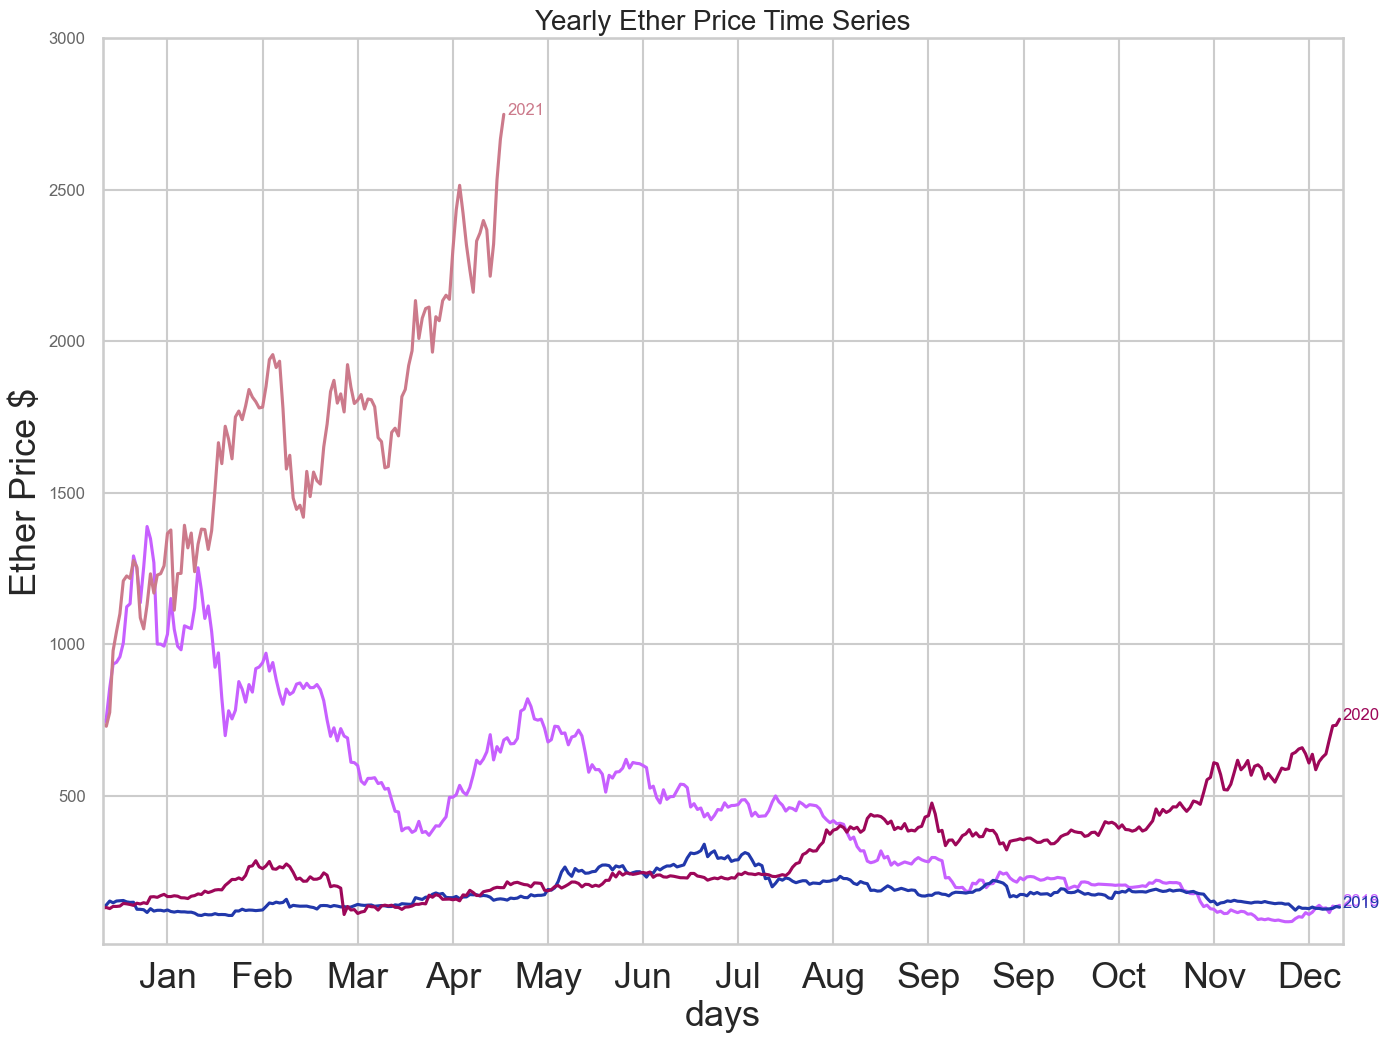

In [9]:
# yearly time plots
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#register_matplotlib_converters()

df = df.assign(year=[d.year for d in df.index])
df = df.assign(month=[d.strftime('%b') for d in df.index])
df = df.assign(month_day=[d.strftime('%d-%b') for d in df.index])
years=df['year'].unique()


np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

fig, ax = plt.subplots(figsize=(16, 12), dpi=100)
plt.minorticks_off()
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month_day', 'open', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0], df.loc[df.year==y, 'open'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        

date_form = DateFormatter("%b")
ax.xaxis.set_major_locator(mdates.YearLocator() )
ax.xaxis.set_major_formatter(date_form)  
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
plt.gca().set(xlim=(0, 365), ylim=(10, 3000), ylabel='Ether Price $', xlabel='days')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Yearly Ether Price Time Series", fontsize=20)


plt.show()    

Text(0.5, 1.0, 'Month-wise Box Plot')

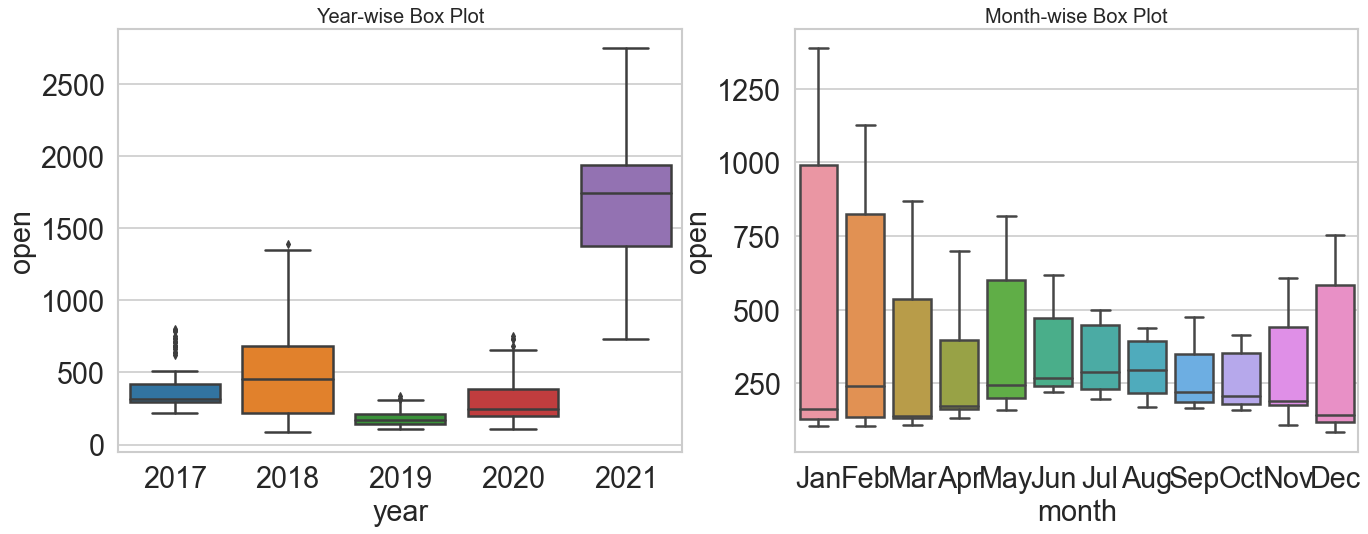

In [10]:
fig, axes = plt.subplots(1,2, figsize=(20,7), dpi=80)
sns.boxplot(x='year', y='open', data=df, ax=axes[0])
sns.boxplot(x='month', y='open', data=df.loc[~df.year.isin([2017,2021]),:])

axes[0].set_title('Year-wise Box Plot', fontsize=18)
axes[1].set_title('Month-wise Box Plot', fontsize=18)

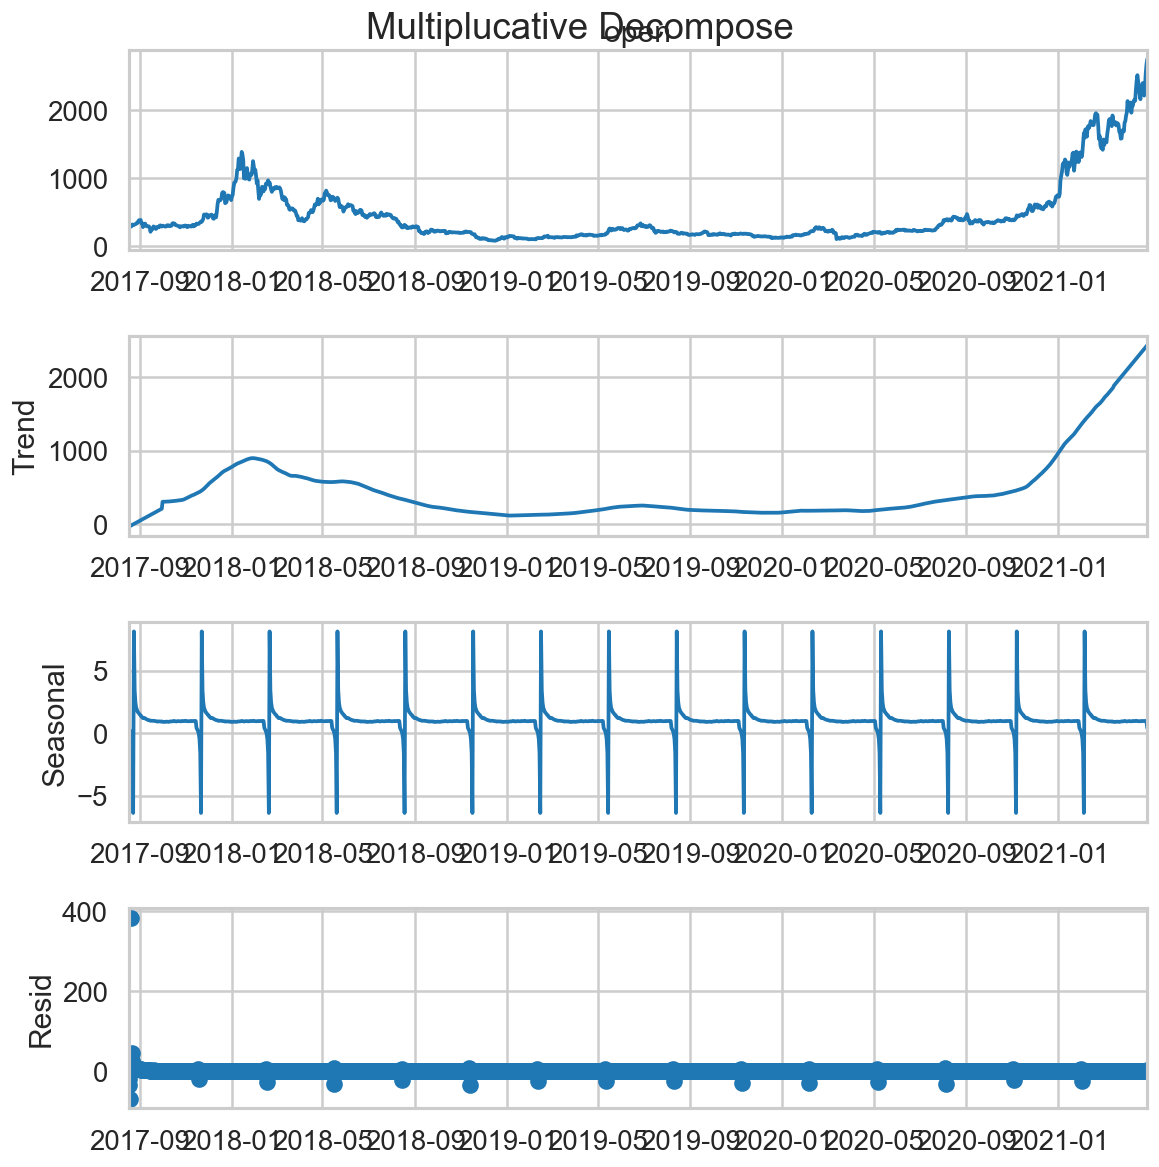

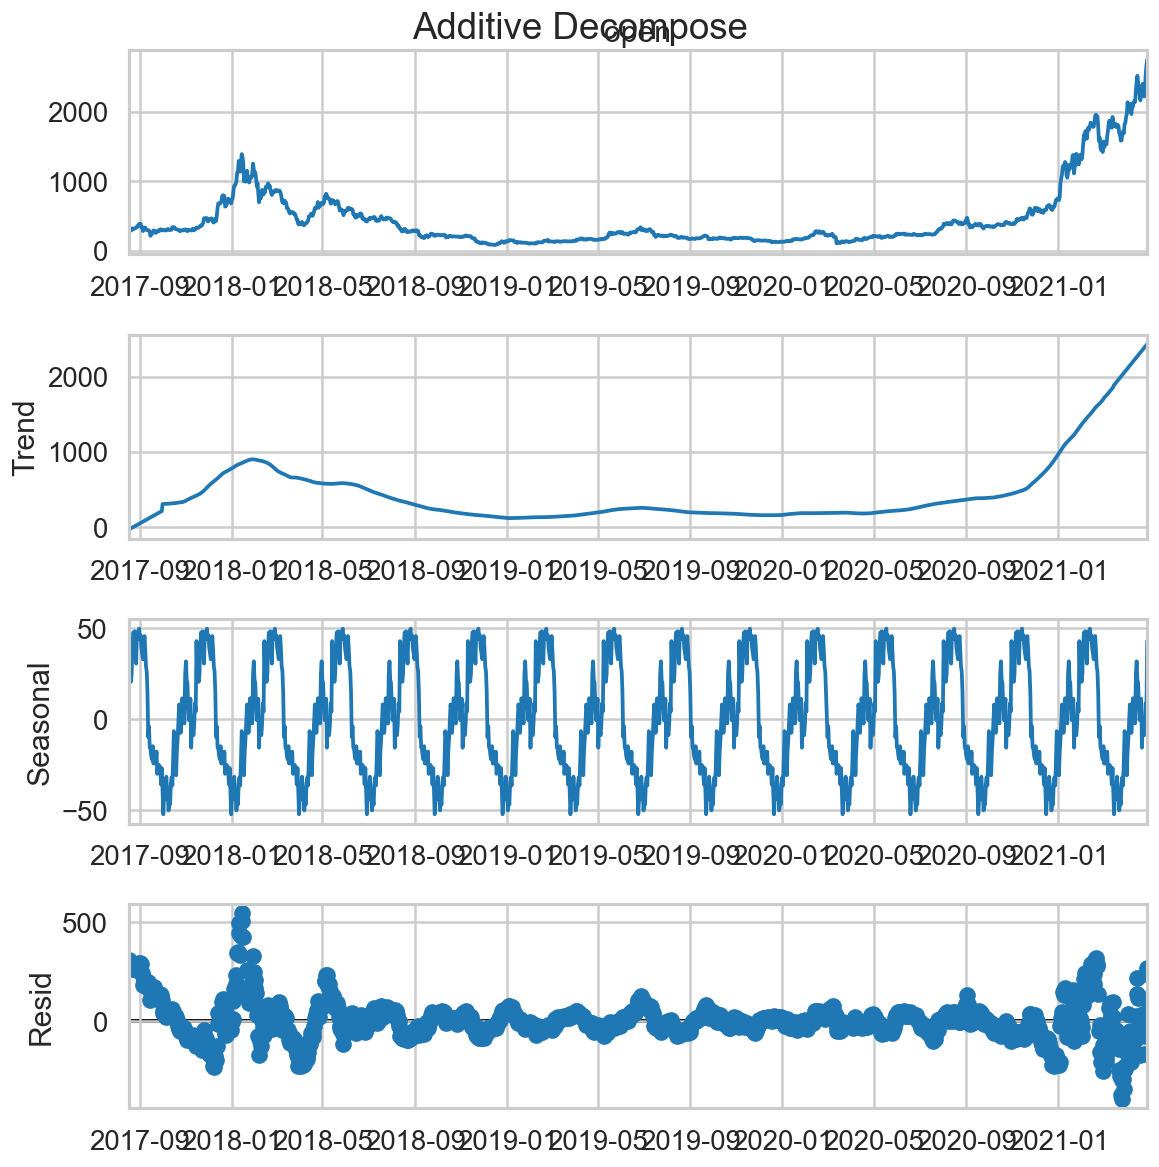

In [85]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# multiplicative
result_mul=seasonal_decompose(df['open'], model='multiplicative', extrapolate_trend='freq', period=90 )

# additive
result_add=seasonal_decompose(df['open'], model='additive', extrapolate_trend='freq', period=90)

plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplucative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [12]:
df_reconstructed=pd.concat([result_mul.seasonal, result_mul.trend,result_mul.resid, result_mul.observed ], axis=1)
df_reconstructed.columns=['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

seas      trend       resid  actual_values
date                                                      
2017-08-17  0.424748 -36.434898  -19.618570         303.61
2017-08-18  0.289699 -30.820366  -33.823793         302.00
2017-08-19  0.167700 -25.205835  -69.543244         293.96
2017-08-20 -0.038626 -19.591303  384.425836         290.91
2017-08-21 -0.458839 -13.976771   46.639013         299.10

In [13]:
# stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
result= adfuller(df.open.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p_value:{result[1]}')
for key , value in result[4].items():
    print('critical values:')
    print(f' {key}, {value}')
    
# KPSS test
result=kpss(df.open.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p_value: %f' % result[1])
for key, value in result[3].items():
    print('critical values:')
    print(f' {key}, {value}')

ADF Statistic: 3.094056919312472
p_value:1.0
critical values:
 1%, -3.435283723720563
critical values:
 5%, -2.8637188486120326
critical values:
 10%, -2.567930026514189

KPSS Statistic: 1.060220
p_value: 0.010000
critical values:
 10%, 0.347
critical values:
 5%, 0.463
critical values:
 2.5%, 0.574
critical values:
 1%, 0.739


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## *The price serie is non-stationary*

Text(0.5, 1.0, 'detrended by subtracting the trend component')

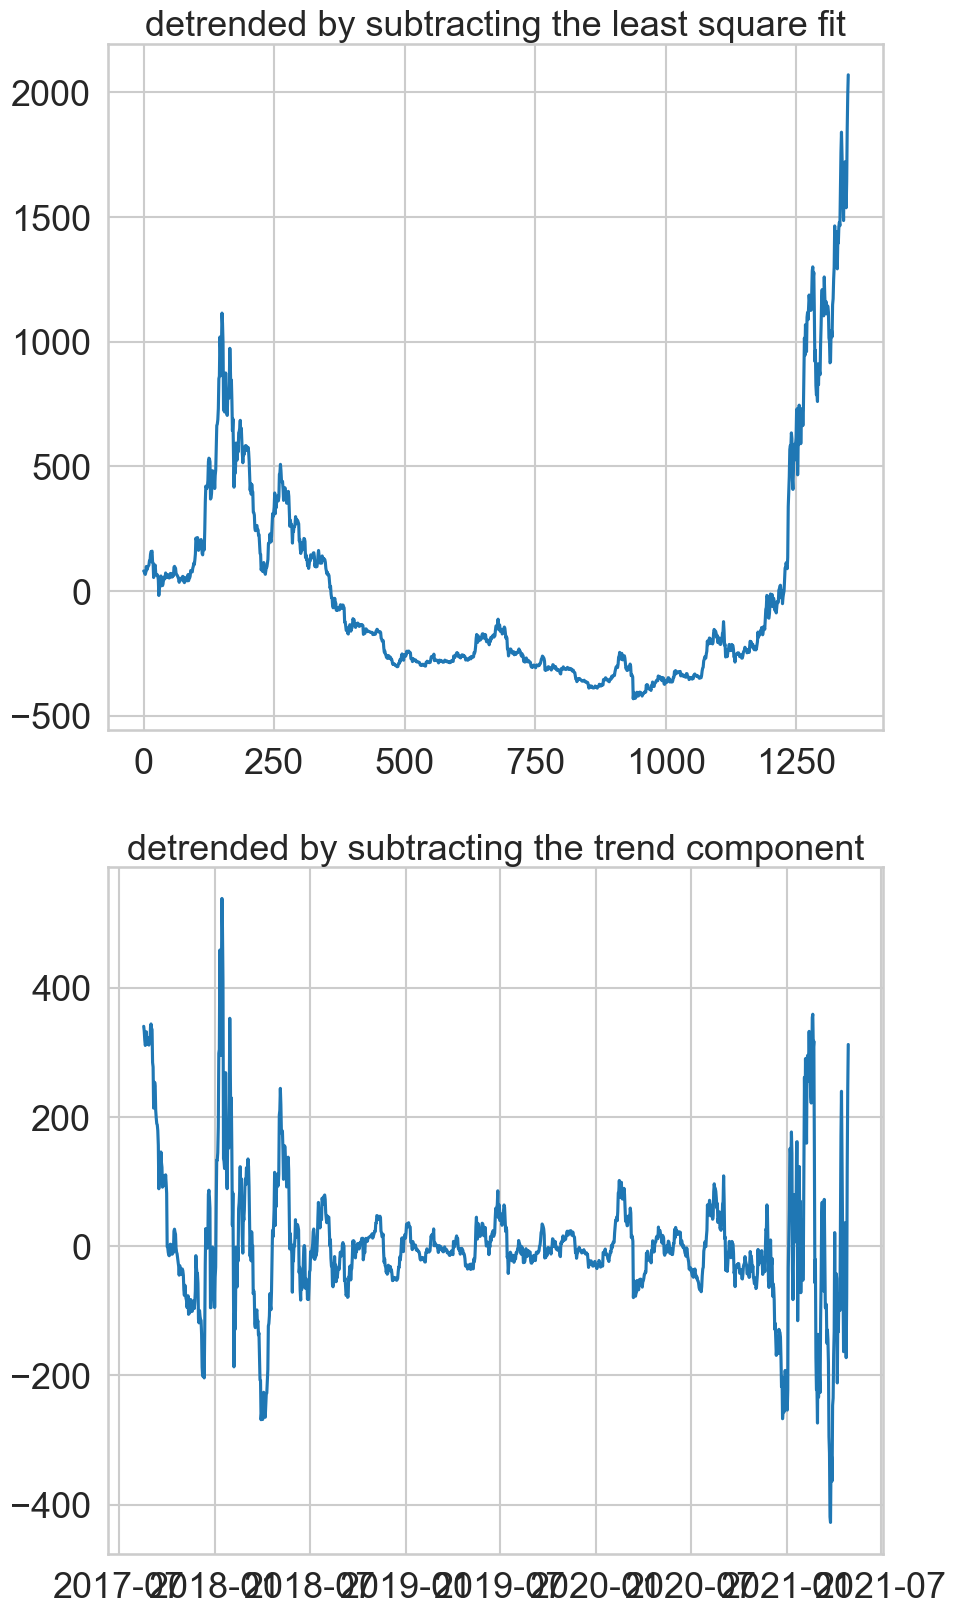

In [14]:
# detrend the series

# best line fit
from scipy import signal
detrended1=signal.detrend(df.open.values)

fig, axis=plt.subplots(2,1, figsize=(10,20), dpi=100)
axis[0].plot(detrended1)
axis[0].set_title('detrended by subtracting the least square fit')

# subtracting Trend component
detrended2=df.open.values-df_reconstructed.trend
axis[1].plot(detrended2)
axis[1].set_title('detrended by subtracting the trend component')

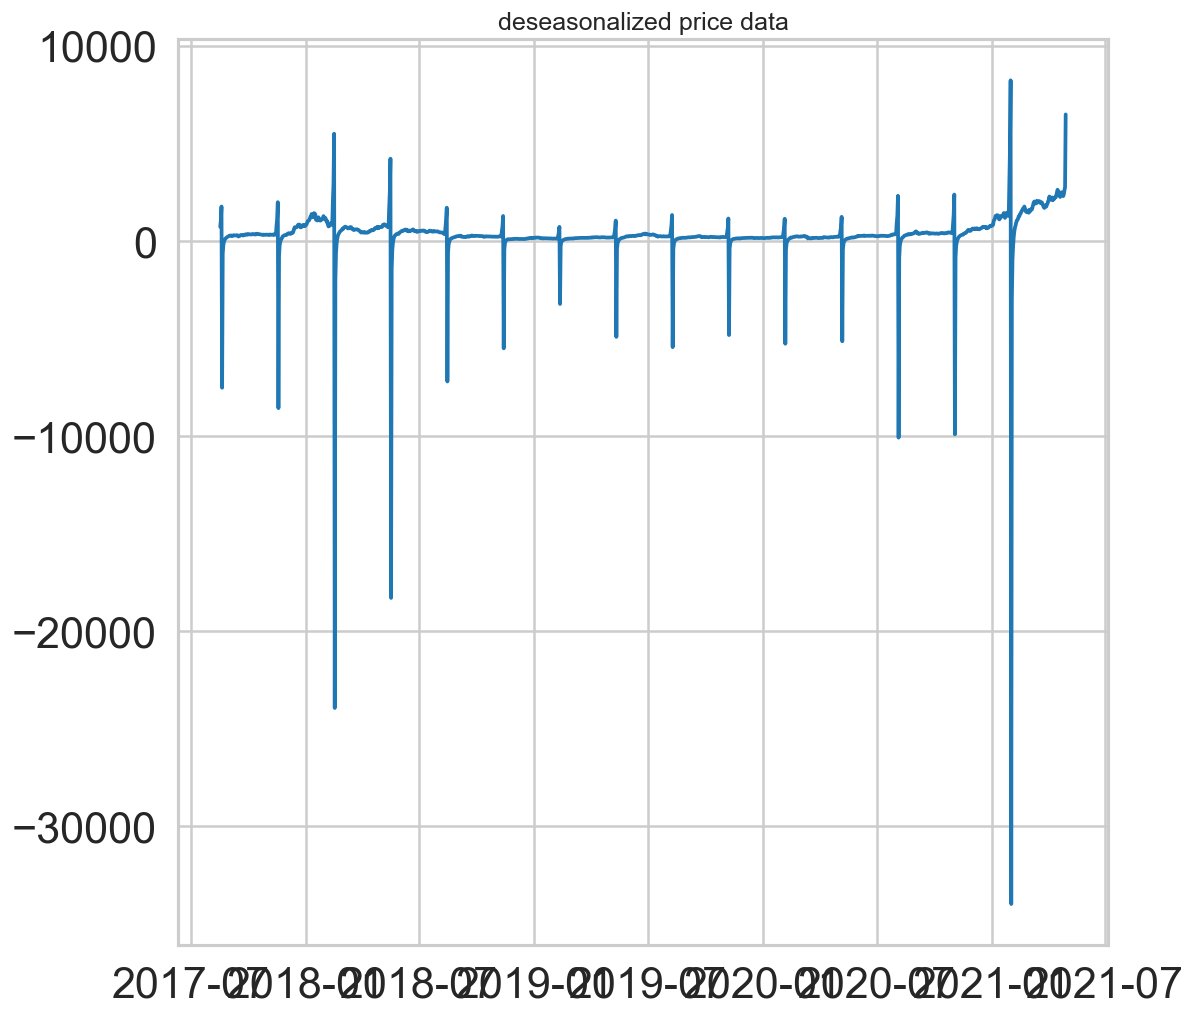

In [15]:
# deseasoning the price series using trend component
deseasonalized=df.open.values / df_reconstructed.seas
plt.plot(deseasonalized)
plt.title('deseasonalized price data', fontsize=15)
plt.show()



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

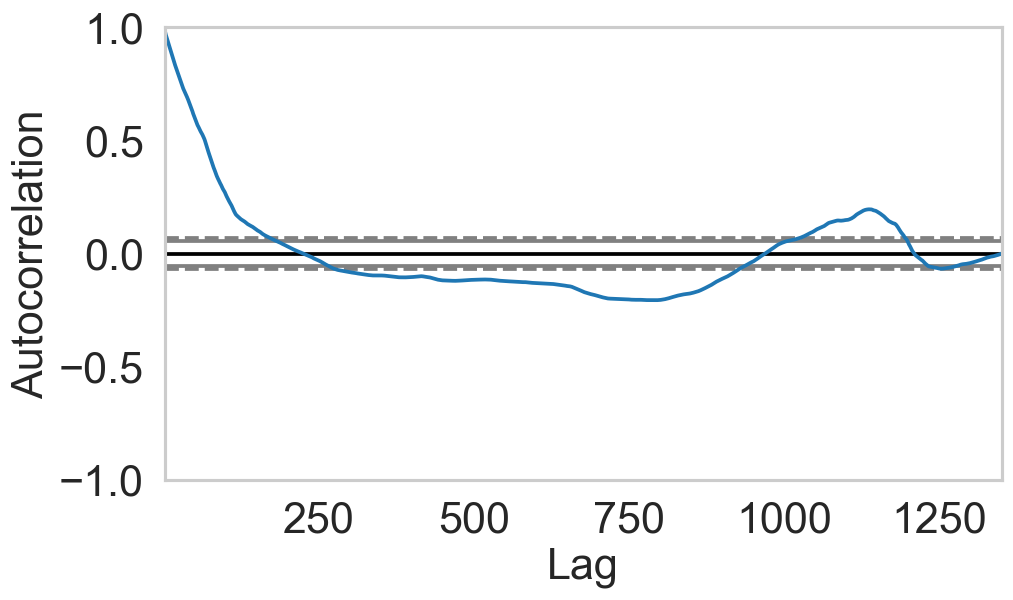

In [16]:
# check for seasonality
from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.open.tolist())

In [17]:
# check for missing data

date_range=pd.date_range('2017-08-17', '2021-04-29', freq='D')
df_test=pd.DataFrame(np.random.randint(1,20,(date_range.shape[0],1)))
df_test.index=date_range

missing_dates=df_test.index[~df_test.index.isin(df.index)]
print(missing_dates)

DatetimeIndex(['2020-02-29'], dtype='datetime64[ns]', freq='D')


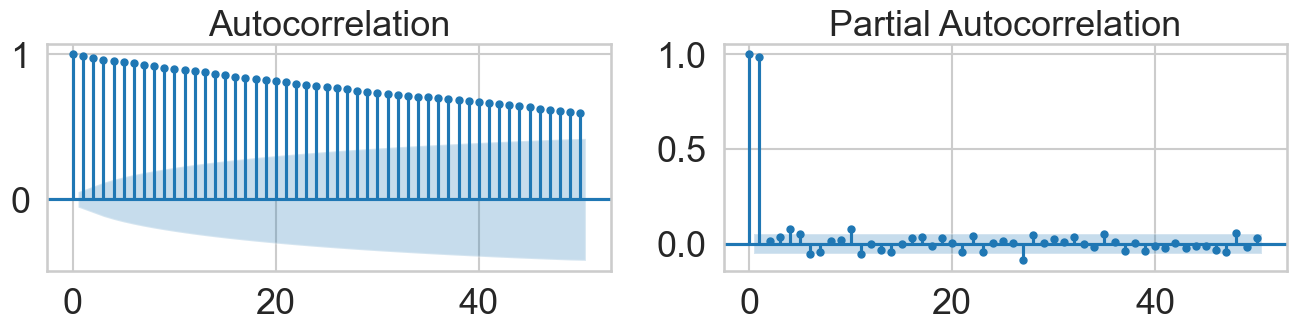

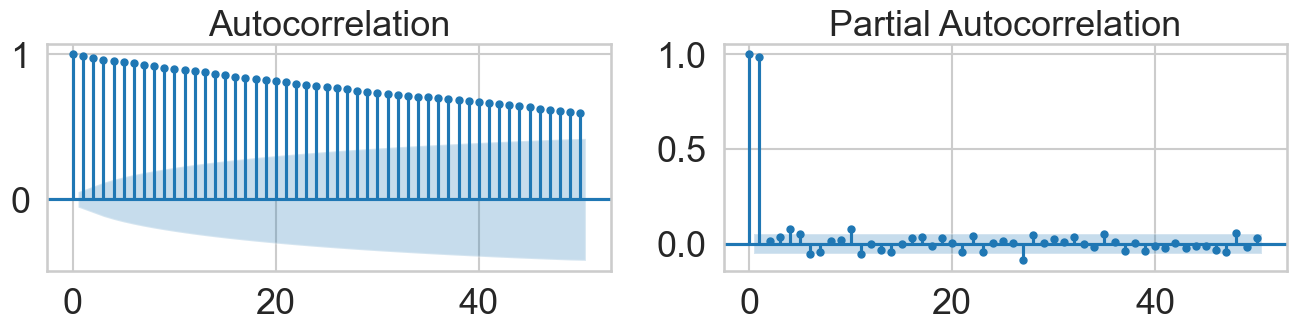

In [18]:
# measuring autocorrelation and partial autocorrelation
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fg, axes= plt.subplots(1,2, figsize=(16,3), dpi=100)
plot_acf(df.open.tolist(), lags=50, ax=axes[0])
plot_pacf(df.open.tolist(), lags=50, ax=axes[1])



Text(0.5, 1.15, 'Lag Plots of Ether Price \n(pointsPoints get wide and scattered with increasing lag -> lesser correlation)\n')

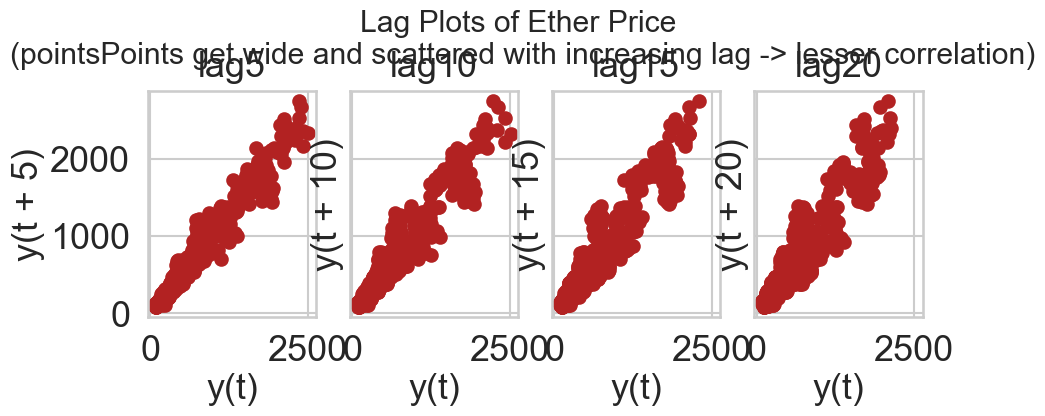

In [19]:
# lag-plot

from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left': False, 'axes.titlepad':10})

fig, axes = plt.subplots(1,4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.open, lag=(i+1)*5, ax=ax, c='firebrick')
    ax.set_title('lag'+ str((i+1)*5))
    
fig.suptitle('Lag Plots of Ether Price \n(pointsPoints get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)

In [20]:
# calculate APPROXIMATE ANTROPY
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))
print(ApEn(df.open, m=2, r=0.2*np.std(df.open)))

0.1463260258312986


In [21]:
# calculate SAMPLE ANTROPY
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))
print(SampEn(df.open, m=2, r=0.2*np.std(df.open)))

0.0477654114136302


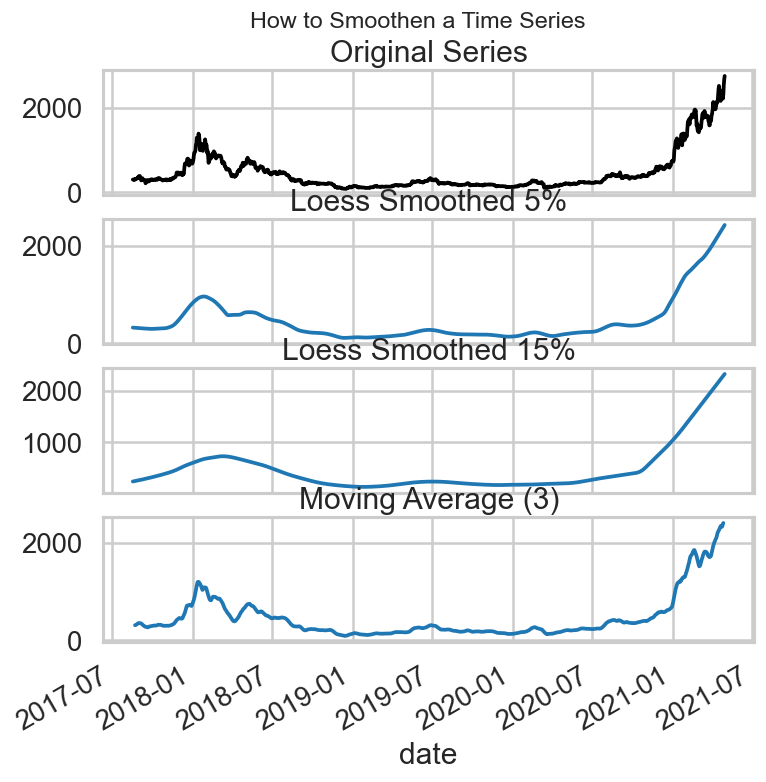

In [86]:
# Smoothing the serie
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df.open.rolling(10, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.open, np.arange(len(df.open)), frac=0.05)[:, 1], index=df.index, columns=['open'])
df_loess_15 = pd.DataFrame(lowess(df.open, np.arange(len(df.open)), frac=0.15)[:, 1], index=df.index, columns=['open'])

# Plot

fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['open'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['open'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['open'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

***

# *Part Two: Applying ARIMA Model to Predict Ether Price*

***

In [23]:
# perform adfuller test for stationarity
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.open.dropna())
print('ADF Statistic:%f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic:3.094057
p-value: 1.000000


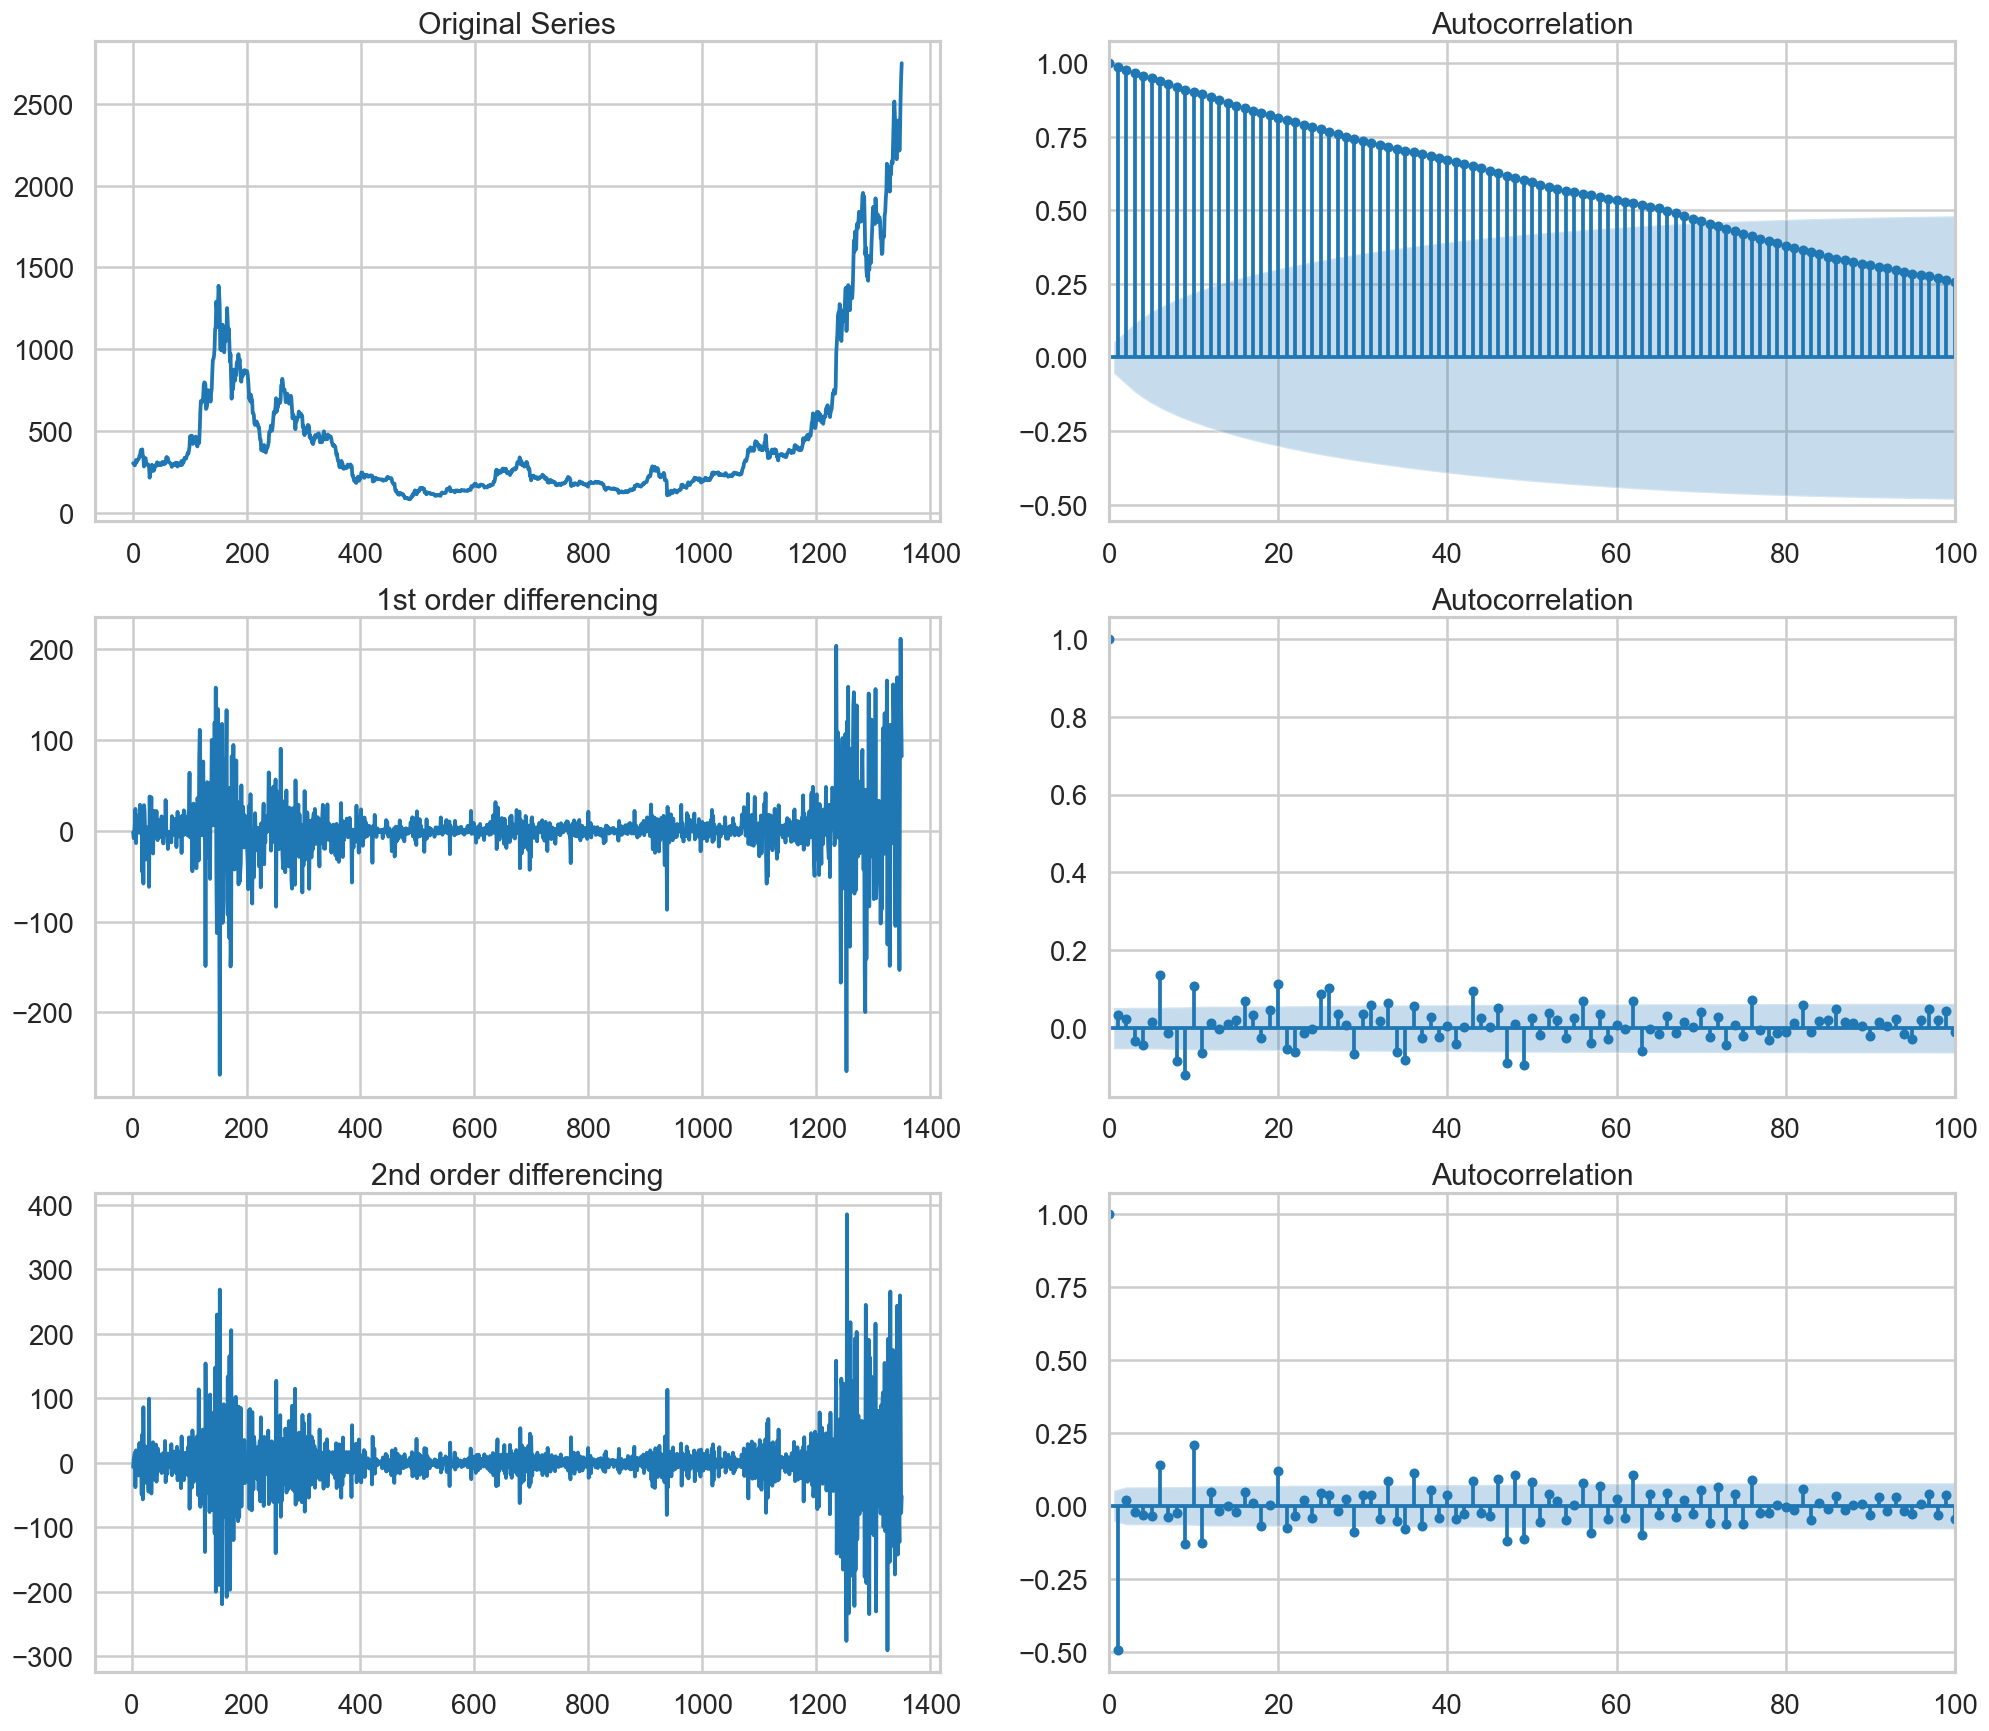

In [116]:
# Autocorrelation plot after differencing

plt.rcParams.update({'figure.figsize':(20,18), 'figure.dpi':120})

fig, axes = plt.subplots(3,2, sharex=False)
axes[0,0].plot(df.open.tolist()); axes[0,0].set_title('Original Series');
plot_acf(df.open.tolist(), lags=100,  ax=axes[0,1])
axes[0,1].set_xlim([0, 100])

# 1st differencing
axes[1,0].plot(df.open.diff().tolist()); axes[1,0].set_title('1st order differencing')
plot_acf(df.open.diff().dropna().tolist(), lags=100, ax=axes[1,1])
axes[1,1].set_xlim([0, 100])
#2nd differencing
axes[2,0].plot(df.open.diff().diff().tolist()); axes[2,0].set_title('2nd order differencing')
plot_acf(df.open.diff().diff().dropna().tolist(), lags=100, ax=axes[2,1])
axes[2,1].set_xlim([0, 100])


plt.show()



### d=1 seems to be good

In [25]:
from pmdarima.arima.utils import ndiffs
y = df.open

ndiffs(y, test='adf') 

1

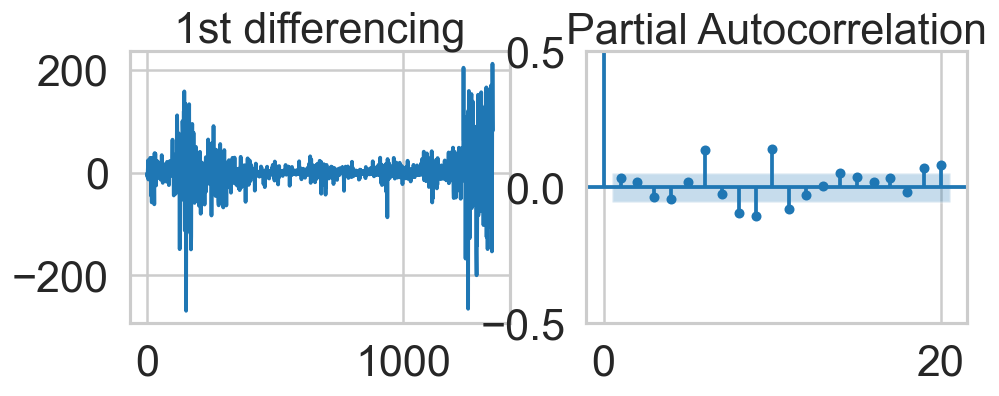

In [26]:
# determine p usin PACF plot

plt.rcParams.update({'figure.figsize': (9,3), 'figure.dpi':120})

fig, axes= plt.subplots(1,2, sharex=False)
axes[0].plot(df.open.diff().tolist()); axes[0].set_title('1st differencing')
axes[1].set(ylim=(-0.5,0.5))
plot_pacf(df.open.diff().dropna(), lags=20, ax=axes[1])

plt.show()

### according to PACF plot it seems that p=0, but it needs more investigations

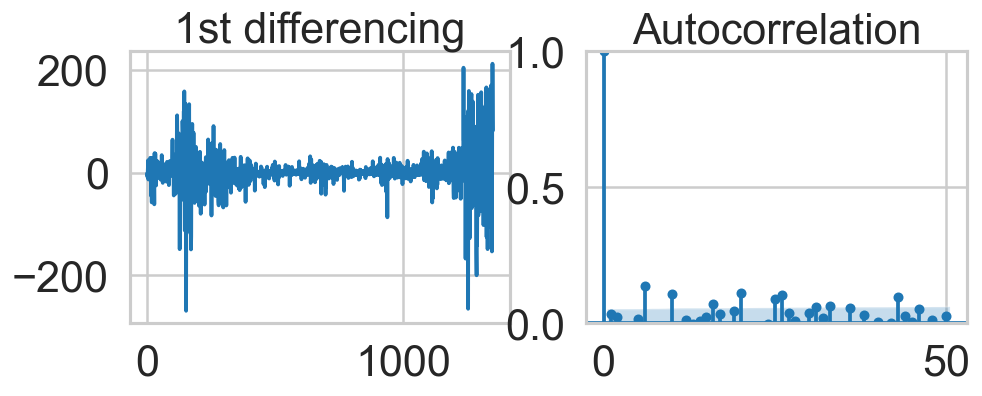

In [27]:
# determine q using ACF plot
fig , axes = plt.subplots(1,2, sharex=False)
axes[0].plot(df.open.diff().tolist()); axes[0].set_title('1st differencing')
axes[1].set(ylim=(0,1))
plot_acf(df.open.diff().dropna(), lags=50, ax=axes[1])

plt.show()

### according to ACF plot it seems that q=0, but it needs more investigations

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1351
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6730.937
Date:                Fri, 04 Jun 2021   AIC                          13467.874
Time:                        22:33:12   BIC                          13483.497
Sample:                             0   HQIC                         13473.725
                               - 1351                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2372      0.303      0.784      0.433      -0.356       0.830
ma.L1         -0.1988      0.304     -0.654      0.513      -0.795       0.397
sigma2      1254.8965     18.602     67.461      0.0

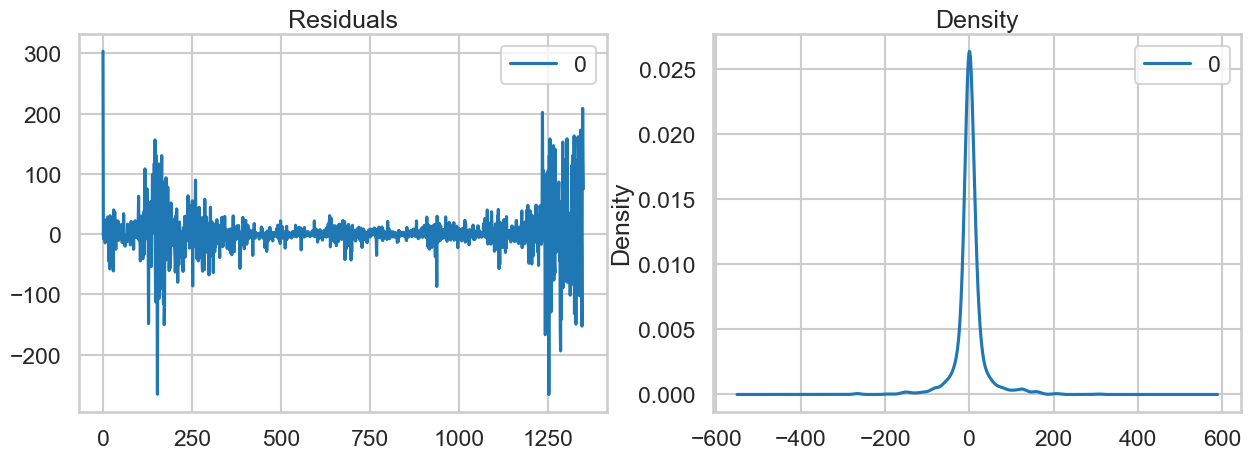

In [135]:
# Apply ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df.open.tolist(), order=(1,1,1))
model_fit=model.fit()
print(model_fit.summary())

residuals=pd.DataFrame(model_fit.resid)
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':100})
fig , axes = plt.subplots(1,2)

residuals.plot(title='Residuals', ax=axes[0])
residuals.plot(kind='kde', title='Density', ax=axes[1])
plt.show()

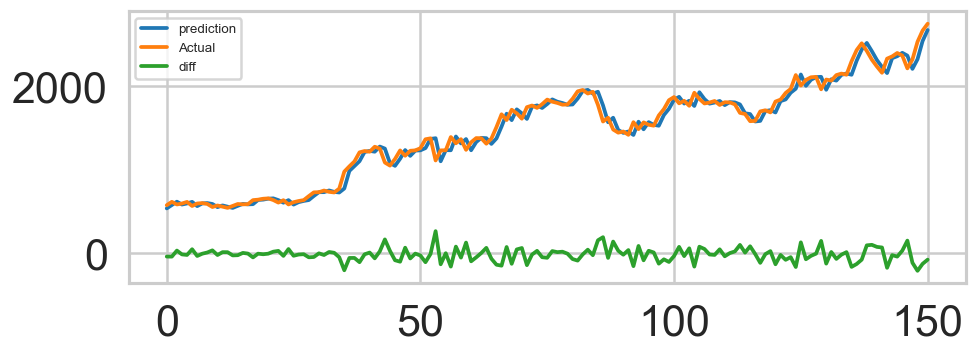

In [29]:
pred=model_fit.predict(dynamik=True)
plt.plot(pred[1200:], label='prediction')
plt.plot(df.open.tolist()[1200:], label='Actual')
plt.plot((pred-df.open.tolist())[1200:], label='diff')
plt.legend(loc='upper left', fontsize=8)
plt.show()

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1250
Model:                 ARIMA(5, 4, 5)   Log Likelihood               -5998.844
Date:                Fri, 04 Jun 2021   AIC                          12019.689
Time:                        22:33:42   BIC                          12076.094
Sample:                             0   HQIC                         12040.897
                               - 1250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1420      0.019   -161.655      0.000      -3.180      -3.104
ar.L2         -4.3985      0.050    -87.913      0.000      -4.497      -4.300
ar.L3         -3.3914      0.061    -55.197      0.0

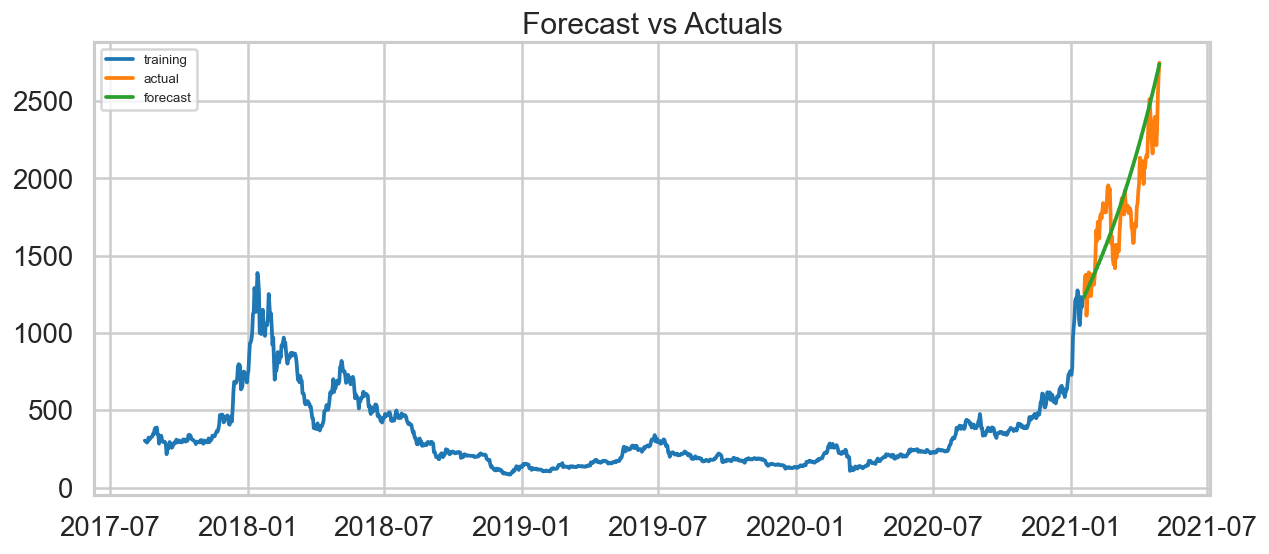

In [136]:
# out of Time cross validation
train=df.open[:1250]
test=df.open[1250:]
model=ARIMA(train.tolist(), order=(5,4,5))
fitted=model.fit()
print(fitted.summary())

fc = fitted.forecast(101, alpha=0.05)
fc_series=pd.Series(fc, index=test.index)
'''lower_series=pd.Series(conf[:,0], index=test.index)
upper_series=pd.Series(conf[:,1], index=test.index)'''

plt.figure(figsize=(12,5), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
'''plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)'''
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fc, test.values)


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.11309351716242817,
 'me': 88.1396247396807,
 'mae': 202.9759755105341,
 'mpe': 0.04755073880417579,
 'rmse': 237.52485329926103,
 'acf1': 0.9143834208871189,
 'corr': 0.8648482961922043,
 'minmax': 0.10206301114266403}

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14338.536, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=13959.562, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=13833.591, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=13764.448, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=13695.967, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=13583.776, Time=0.15 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=13454.574, Time=1.10 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=13452.607, Time=1.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=1.81 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=1.57 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=13440.691, Time=1.58 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=13416.3

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


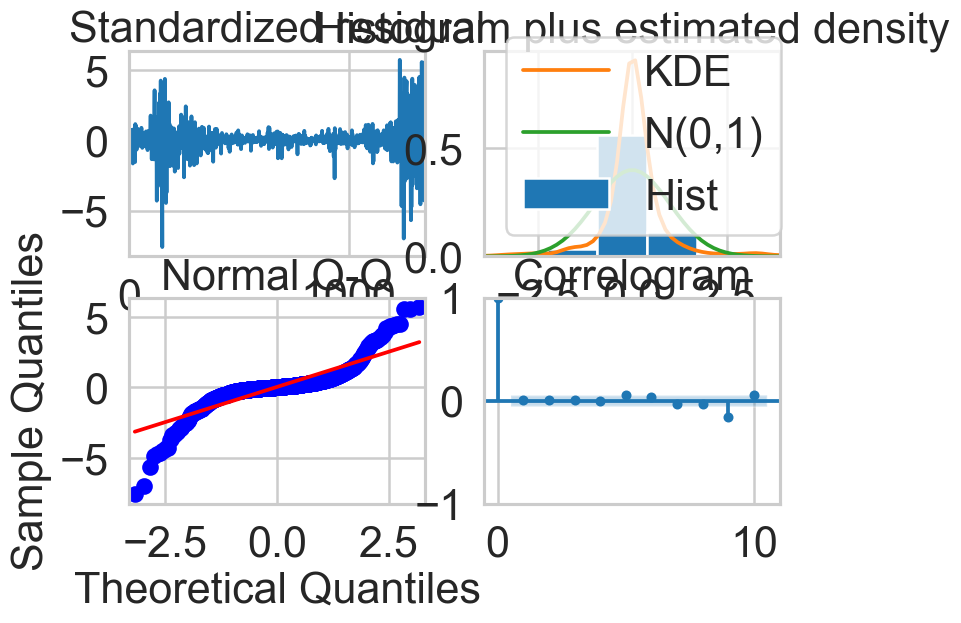

In [32]:
# Auto ARIMA forecast
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model=pm.auto_arima(df.open.tolist(), start_p=2, start_q=2,
                   test='kpss',
                   max_p=5, max_q=5,
                   m=1,
                   d=None,
                   seasonal=True,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
print(model.summary())
model.plot_diagnostics(figsize=(7,5))
plt.show()

Test Statistics                  3.094057
p-value                          1.000000
#lags Used                      22.000000
Number of Observation Used    1328.000000
Critical Value (1%)             -3.435284
Critical Value (5%)             -2.863719
Critical Value (10%)            -2.567930
dtype: float64


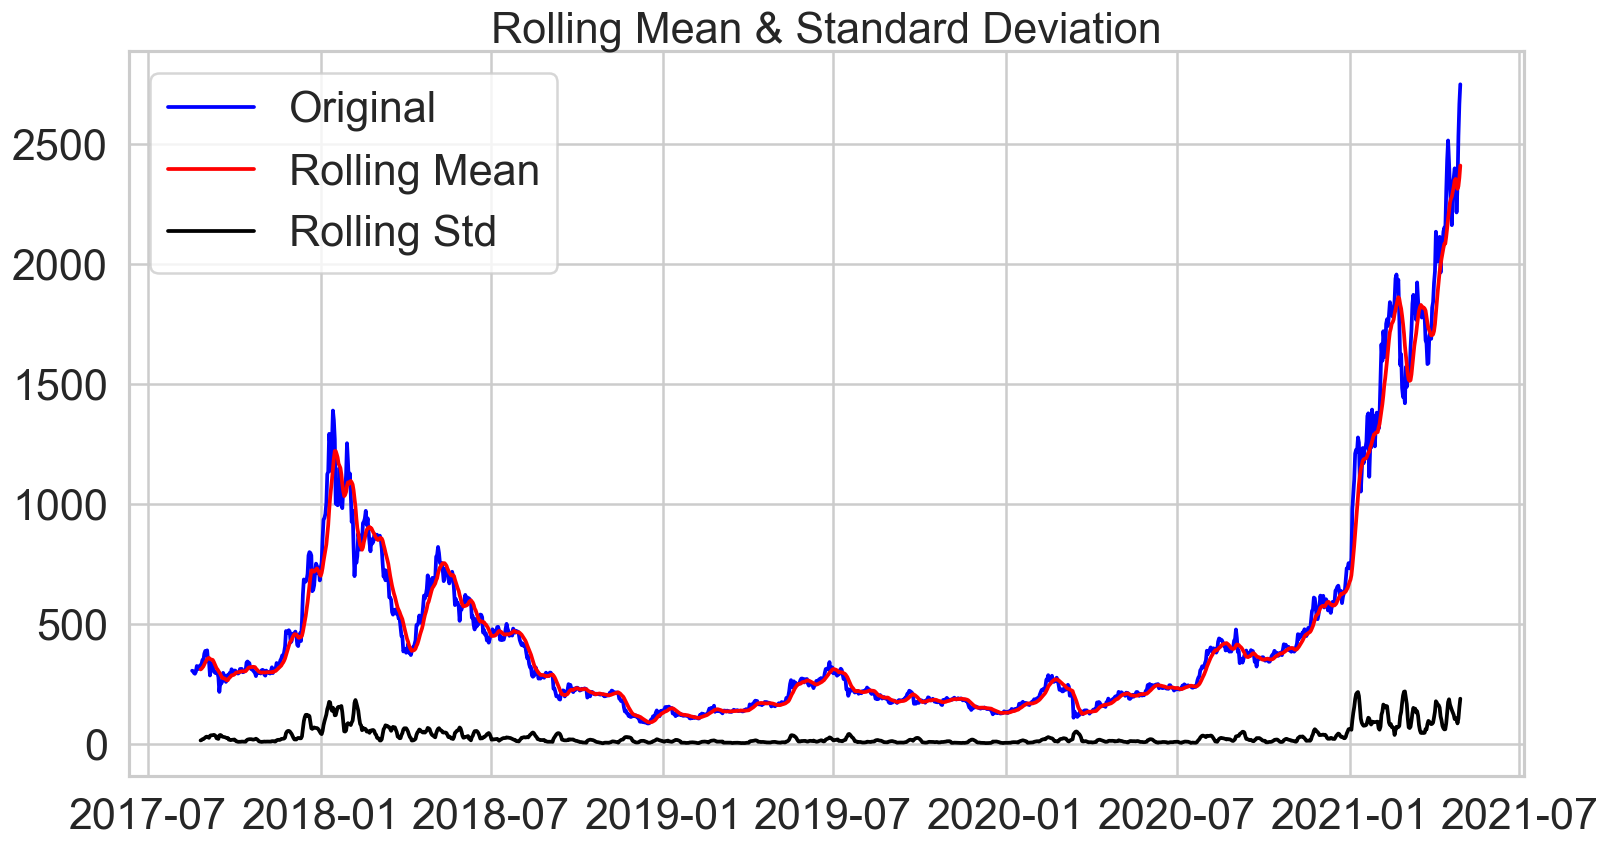

In [33]:
def ad_fuller_test(ts):
    dftest=adfuller(ts, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistics',
                                          'p-value',
                                          '#lags Used',
                                          'Number of Observation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key]=value
    print(dfoutput)
    
def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=10, center=False).mean()
    rolling_std = ts.rolling(window=10, center=False).std()
    
    plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})
    orig=plt.plot(ts, color='blue', label='Original')
    mean=plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std=plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
ad_fuller_test(df.open)
plot_rolling_stats(df.open)

Test Statistics                  0.027769
p-value                          0.960769
#lags Used                      10.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
Critical Value (5%)             -2.863699
Critical Value (10%)            -2.567920
dtype: float64


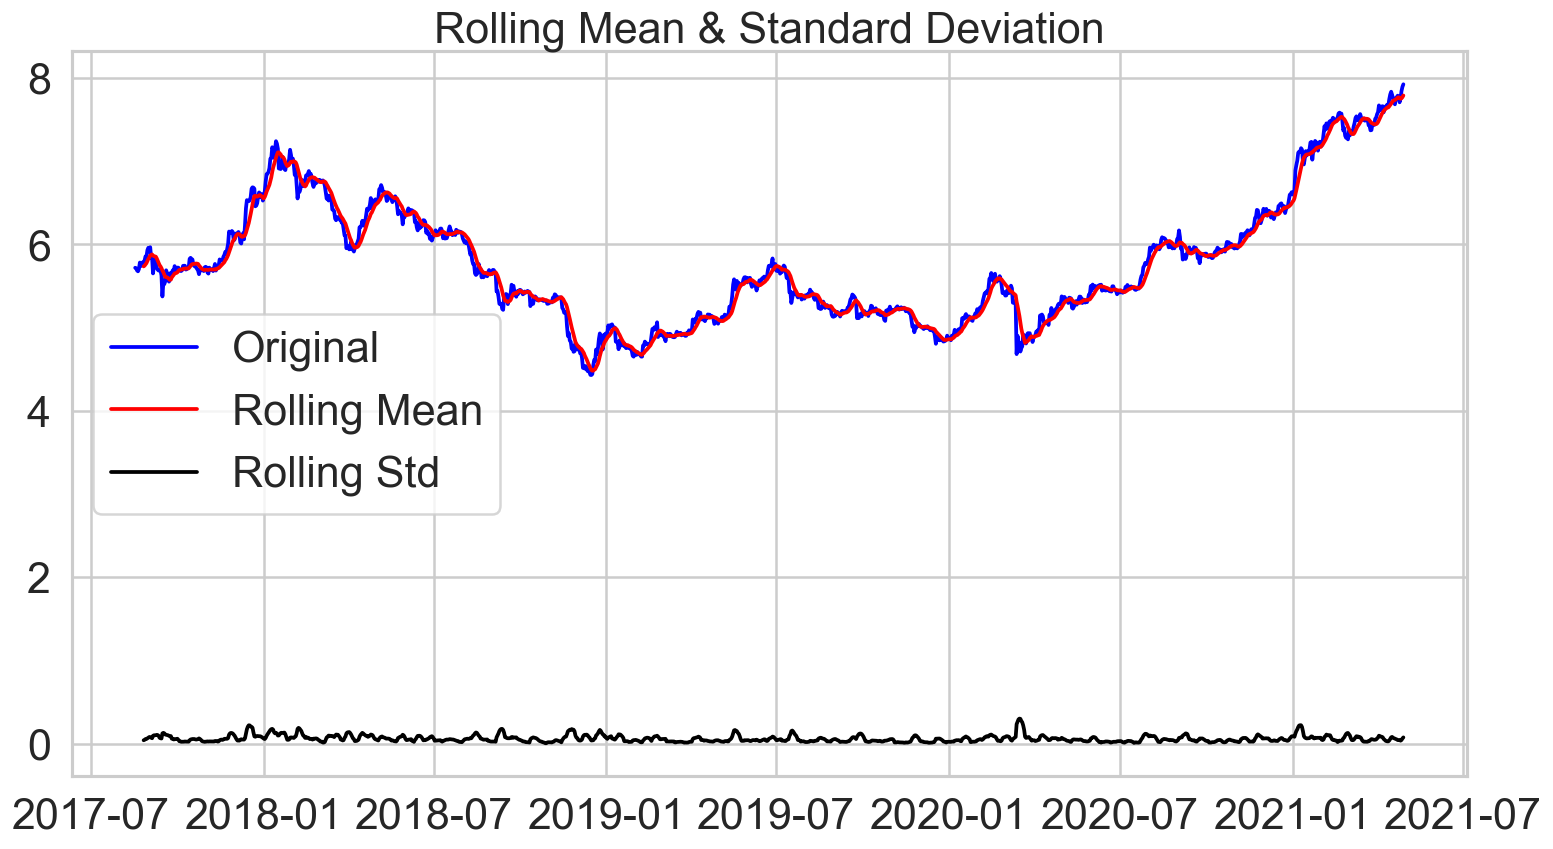

In [34]:
log_series=np.log(df.open)

ad_fuller_test(log_series)
plot_rolling_stats(log_series)

Test Statistics              -1.091245e+01
p-value                       1.088295e-19
#lags Used                    9.000000e+00
Number of Observation Used    1.340000e+03
Critical Value (1%)          -3.435239e+00
Critical Value (5%)          -2.863699e+00
Critical Value (10%)         -2.567920e+00
dtype: float64


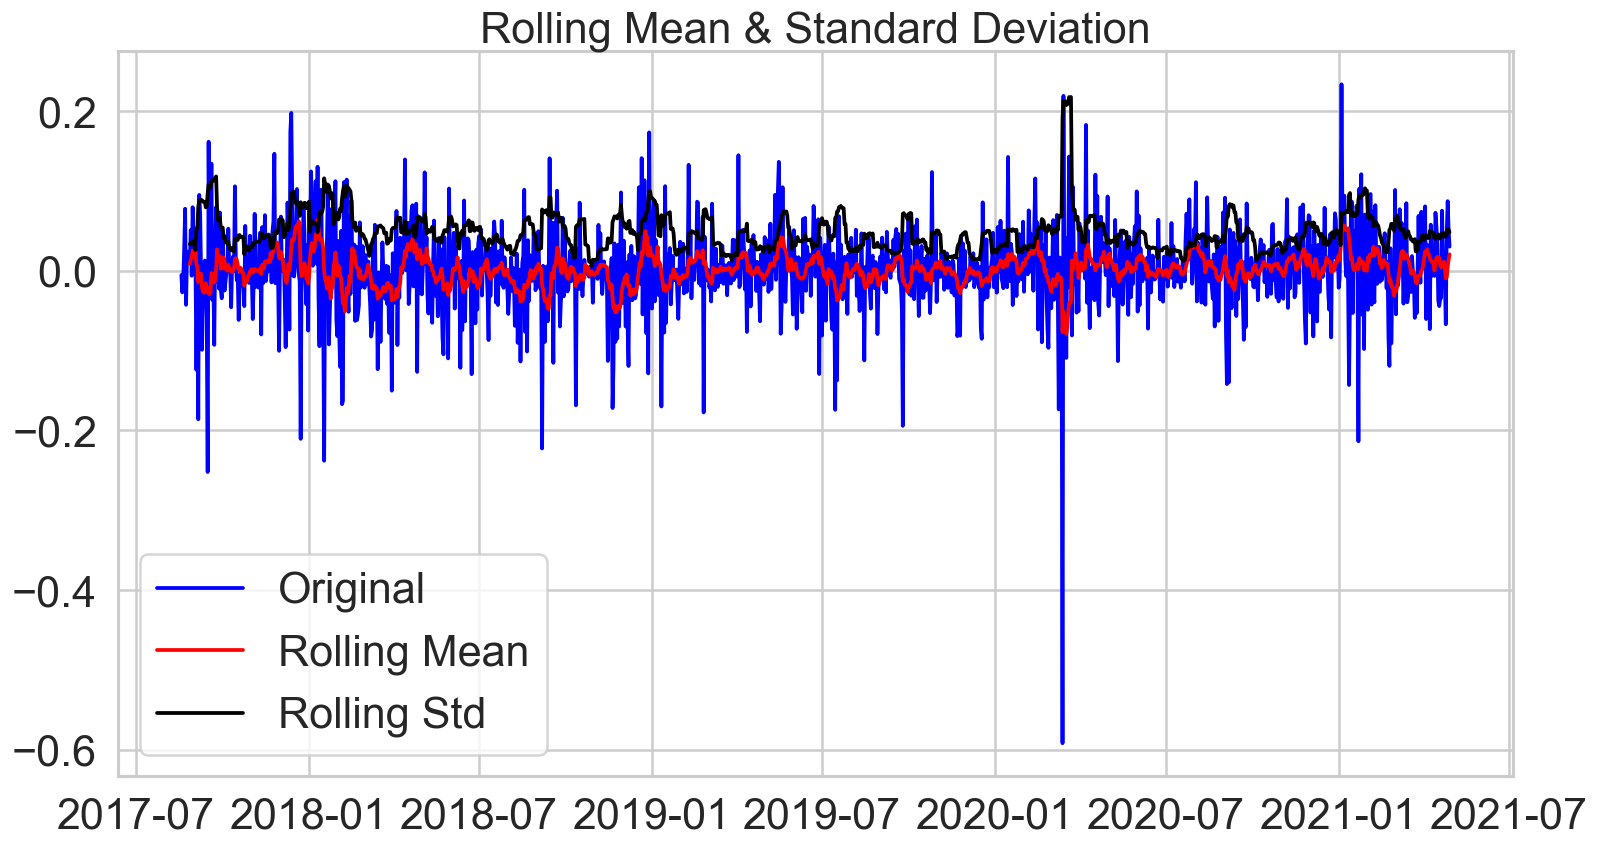

In [35]:
log_series_shift=log_series - log_series.shift()
log_series_shift=log_series_shift[~np.isnan(log_series_shift)]

ad_fuller_test(log_series_shift)
plot_rolling_stats(log_series_shift)

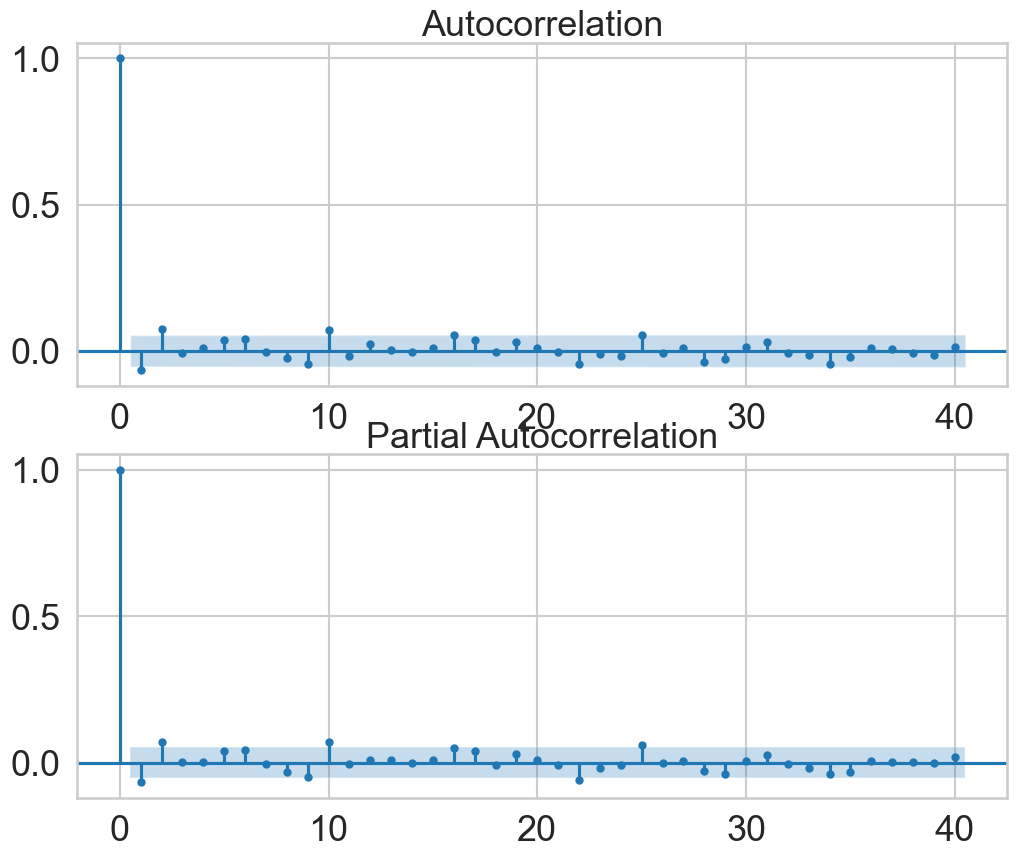

In [36]:
fig=plt.figure(figsize=(12,10), dpi=100)
ax1=fig.add_subplot(211)
fig=plot_acf(log_series_shift, lags=40, ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(log_series_shift, lags=40, ax=ax2)

********************
Iteration 1 of 5
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225] TEST: [226 227 228 229 230 231 232 23

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(0, 0, 0)- AIC:335.45032180204055
ARIMA(0, 0, 1)- AIC:60.69597411104337
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARIMA(0, 1, 0)- AIC:-584.0424465007017


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\s

ARIMA(0, 1, 1)- AIC:-582.5280897085188
ARIMA(0, 1, 2)- AIC:-580.5657742979106


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 3)- AIC:-578.7982124230055
ARIMA(0, 2, 0)- AIC:-438.4031614460064

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)- AIC:-575.8829468366356


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)- AIC:-574.0360255855859


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 3)- AIC:-572.337901136409
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(1, 0, 0)- AIC:-582.1586413001666
ARIMA(1, 0, 1)- AIC:-580.7245269363231


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(1, 0, 2)- AIC:-578.7413681100182
ARIMA(1, 0, 3)- AIC:-577.0387470751269


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 0)- AIC:-582.5173106765731
ARIMA(1, 1, 1)- AIC:-581.2063751019625


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(1, 1, 2)- AIC:-579.2120628463613


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 3)- AIC:-577.6460507715983
ARIMA(1, 2, 0)- AIC:-491.6570390304149


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 1)- AIC:-574.0262648621821


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 2)- AIC:-572.8020245308388


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 3)- AIC:-570.952857322174
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(2, 0, 0)- AIC:-580.716463579076
ARIMA(2, 0, 1)- AIC:-579.3695735140994


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 2)- AIC:-577.3700301081916


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 3)- AIC:-575.9080034692746
ARIMA(2, 1, 0)- AIC:-580.5429745930808


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 1)- AIC:-579.2129708995622


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 2)- AIC:-578.2760544993921


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 3)- AIC:-576.7376359265288
ARIMA(2, 2, 0)- AIC:-517.8288548749996


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 2, 1)- AIC:-572.2532810499034


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 2, 2)- AIC:-570.9653286372751


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(2, 2, 3)- AIC:-575.2427866030636
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(3, 0, 0)- AIC:-578.7260816892132
ARIMA(3, 0, 1)- AIC:-577.3701109496398


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 2)- AIC:-581.5534127406216
ARIMA(3, 0, 3)- AIC:-575.0068251302333


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 0)- AIC:-578.6774945921188


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 1, 1)- AIC:-577.7225760481924


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 2)- AIC:-579.2562576015555


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 3)- AIC:-578.8014880890573
ARIMA(3, 2, 0)- AIC:-521.684908402147


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 2, 1)- AIC:-570.2566780753397


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(3, 2, 2)- AIC:-568.5549445380328


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(3, 2, 3)- AIC:-568.1435045033826
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
Best Model params:(0, 1, 0) AIC:-584.0424465007017
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 294.021
Method:                           css   S.D. of innovations              0.066
Date:                Fri, 04 Jun 2021   AIC                           -584.042
Time:                        17:51:19   BIC                           -577.210
Sample:                    08-18-2017   HQIC                          -581.285
                         - 03-30-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0

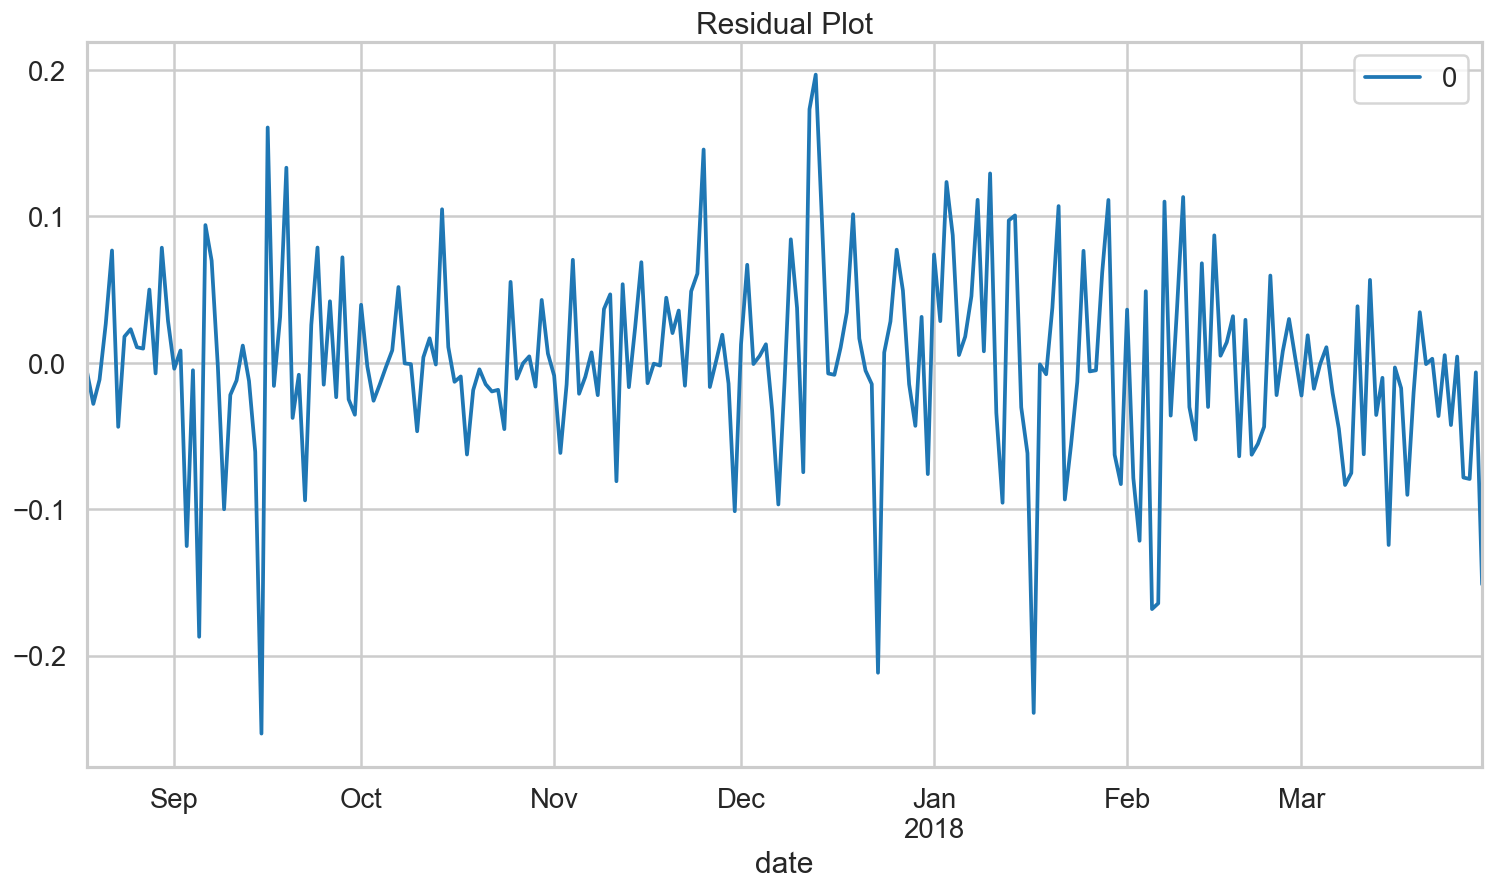

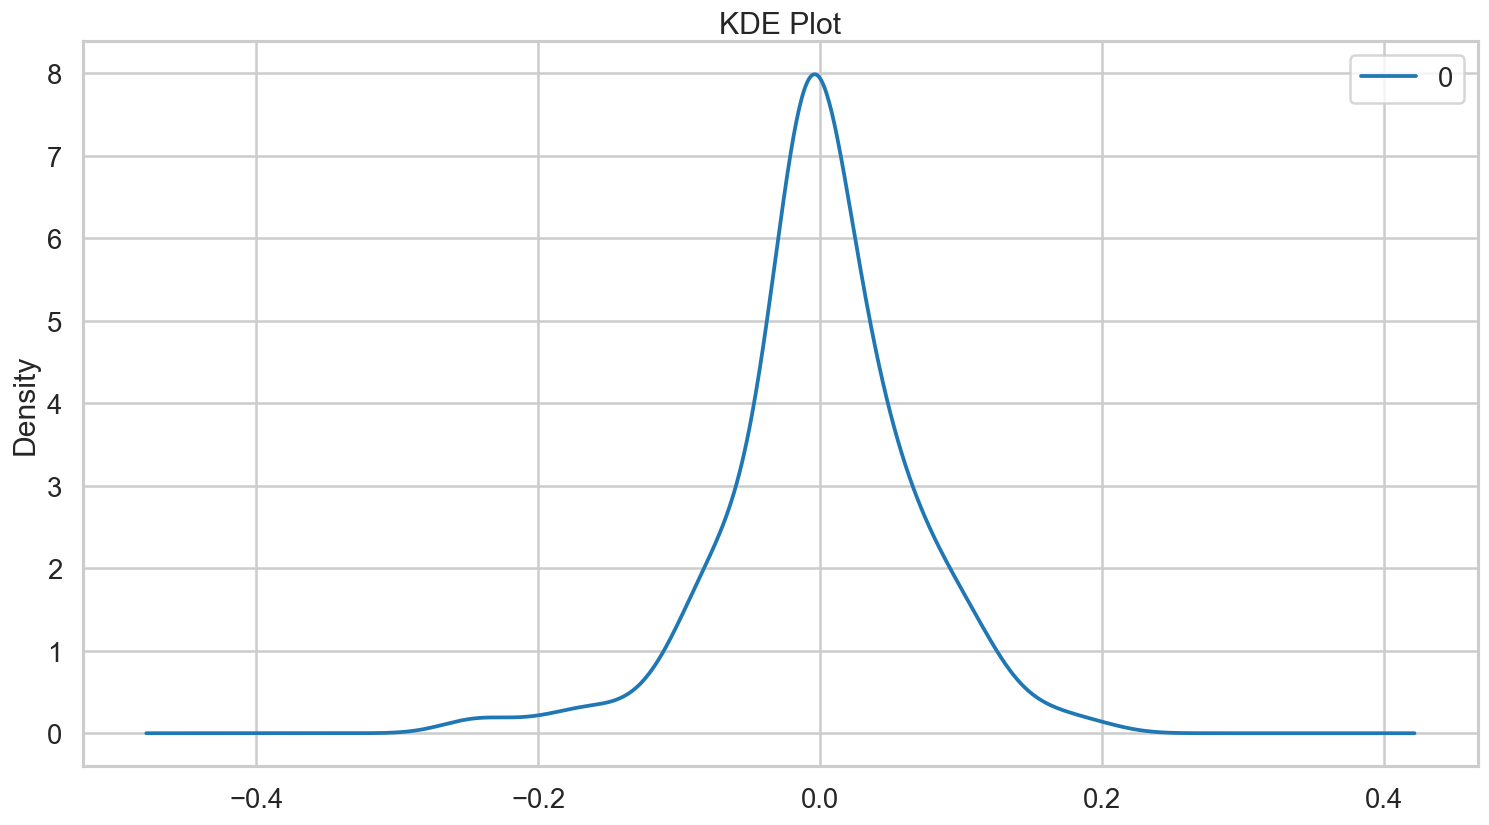

                  0
count  2.250000e+02
mean   6.399248e-10
std    6.564641e-02
min   -2.531207e-01
25%   -2.489281e-02
50%   -1.108278e-03
75%    3.574257e-02
max    1.968185e-01


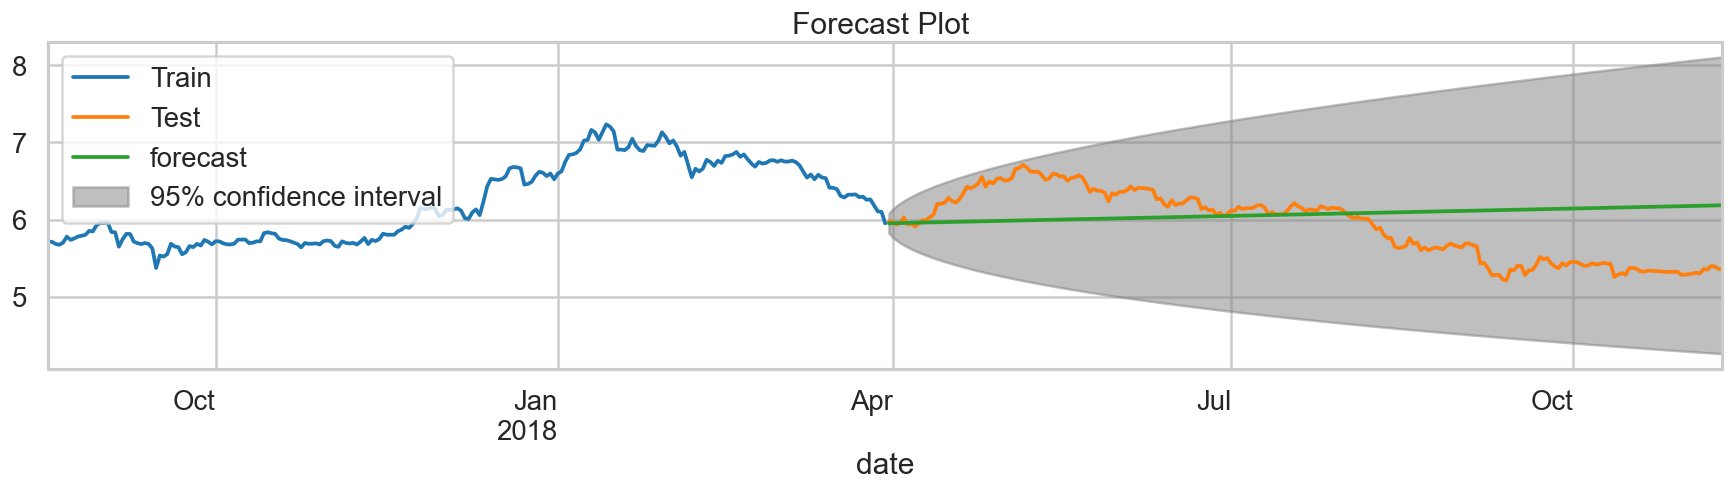

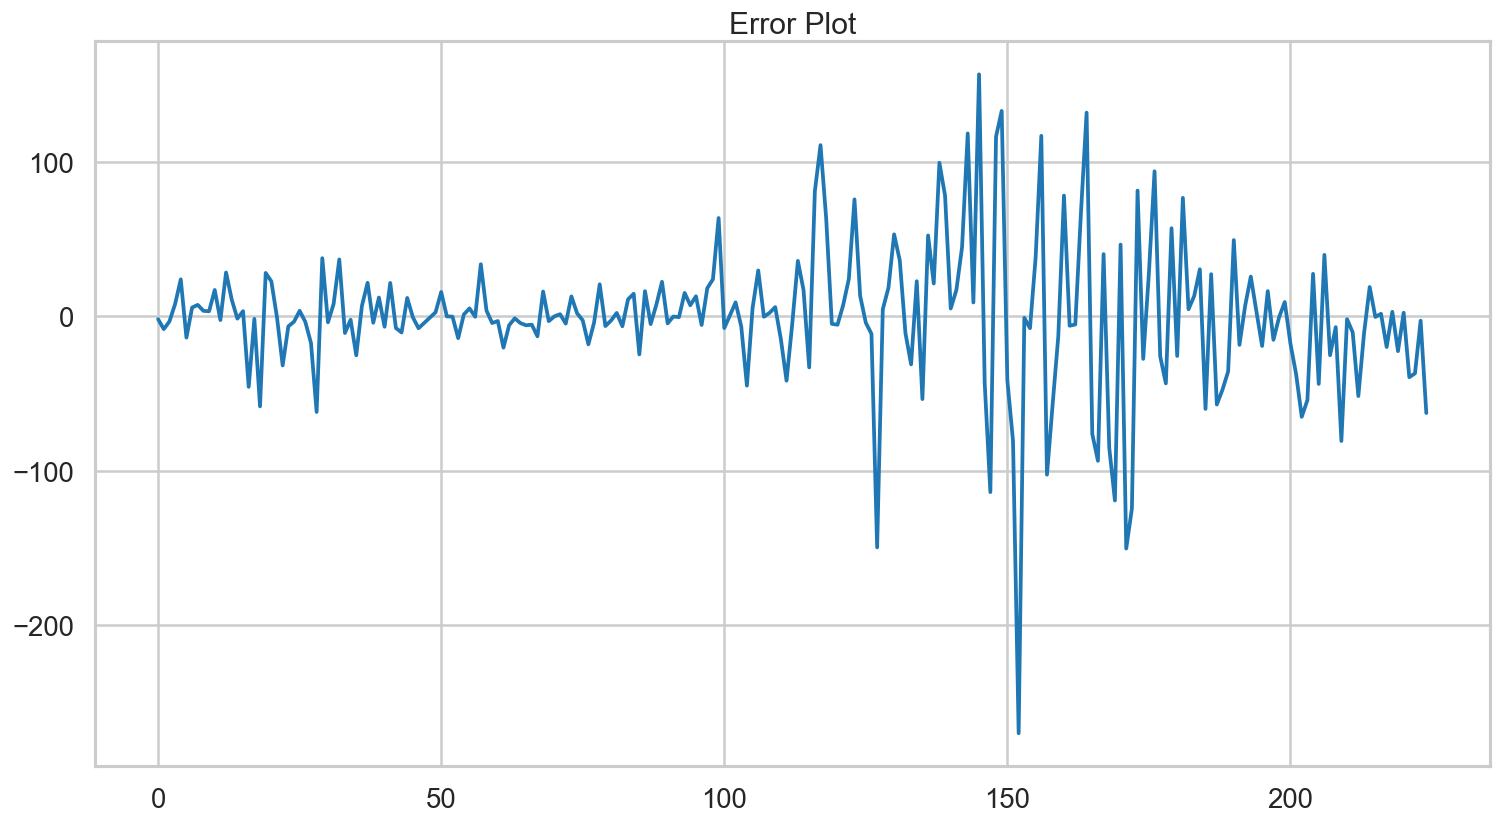

********************
Iteration 2 of 5
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 2

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(0, 0, 1)- AIC:94.43801755487357


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 2)- AIC:-266.7010162416959
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARIMA(0, 1, 0)- AIC:-1280.703404405068


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)- AIC:-1278.70341751273


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\

ARIMA(0, 1, 2)- AIC:-1277.653034883287


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 3)- AIC:-1275.7104528341251
ARIMA(0, 2, 0)- AIC:-965.5609482279258


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)- AIC:-1271.080020533213


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)- AIC:-1269.0842826149533


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 3)- AIC:-1267.879030542861
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(1, 0, 0)- AIC:-1278.8644373145685


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)- AIC:-1276.8677118195287


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 0, 2)- AIC:-1275.9565576046857


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 0, 3)- AIC:-1274.0539957566311


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 0)- AIC:-1278.7034185729008


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(1, 1, 1)- AIC:-1277.247396691062


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 2)- AIC:-1275.6645538450434


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 3)- AIC:-1276.681035040046
ARIMA(1, 2, 0)- AIC:-1105.1359535106008


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 1)- AIC:-1269.084618238206


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 2)- AIC:-1268.2369508263578


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 3)- AIC:-1266.3830322877625
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(2, 0, 0)- AIC:-1276.8679982398257
SVD did not converge


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 2)- AIC:-1273.9776540533248


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 3)- AIC:-1275.095078164798


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 0)- AIC:-1277.440836944123


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(2, 1, 1)- AIC:-1275.4664321041873


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 2)- AIC:-1289.420288149287


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 3)- AIC:-1283.8817781187995
ARIMA(2, 2, 0)- AIC:-1154.1423452341928


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(2, 2, 1)- AIC:-1267.6647755060621


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 2, 2)- AIC:-1266.4253574281397


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIM

ARIMA(2, 2, 3)- AIC:-1279.6991013970296
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(3, 0, 0)- AIC:-1275.7215447375102


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(3, 0, 1)- AIC:-1273.7607458752814


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 2)- AIC:-1287.6717646302864


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 3)- AIC:-1282.061482338945


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 0)- AIC:-1275.5952121688638


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 1, 1)- AIC:-1276.5148382387188


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 2)- AIC:-1283.794702280637


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 3)- AIC:-1281.9707039076911
ARIMA(3, 2, 0)- AIC:-1162.2636270410608


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 2, 1)- AIC:-1265.8351636655466


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 2, 2)- AIC:-1266.7396341200692


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(3, 2, 3)- AIC:-1273.8777041338826
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
Best Model params:(2, 1, 2) AIC:-1289.420288149287
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                  450
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 650.710
Method:                       css-mle   S.D. of innovations              0.057
Date:                Fri, 04 Jun 2021   AIC                          -1289.420
Time:                        17:51:42   BIC                          -1264.765
Sample:                    08-18-2017   HQIC                         -1279.703
                         - 11-10-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

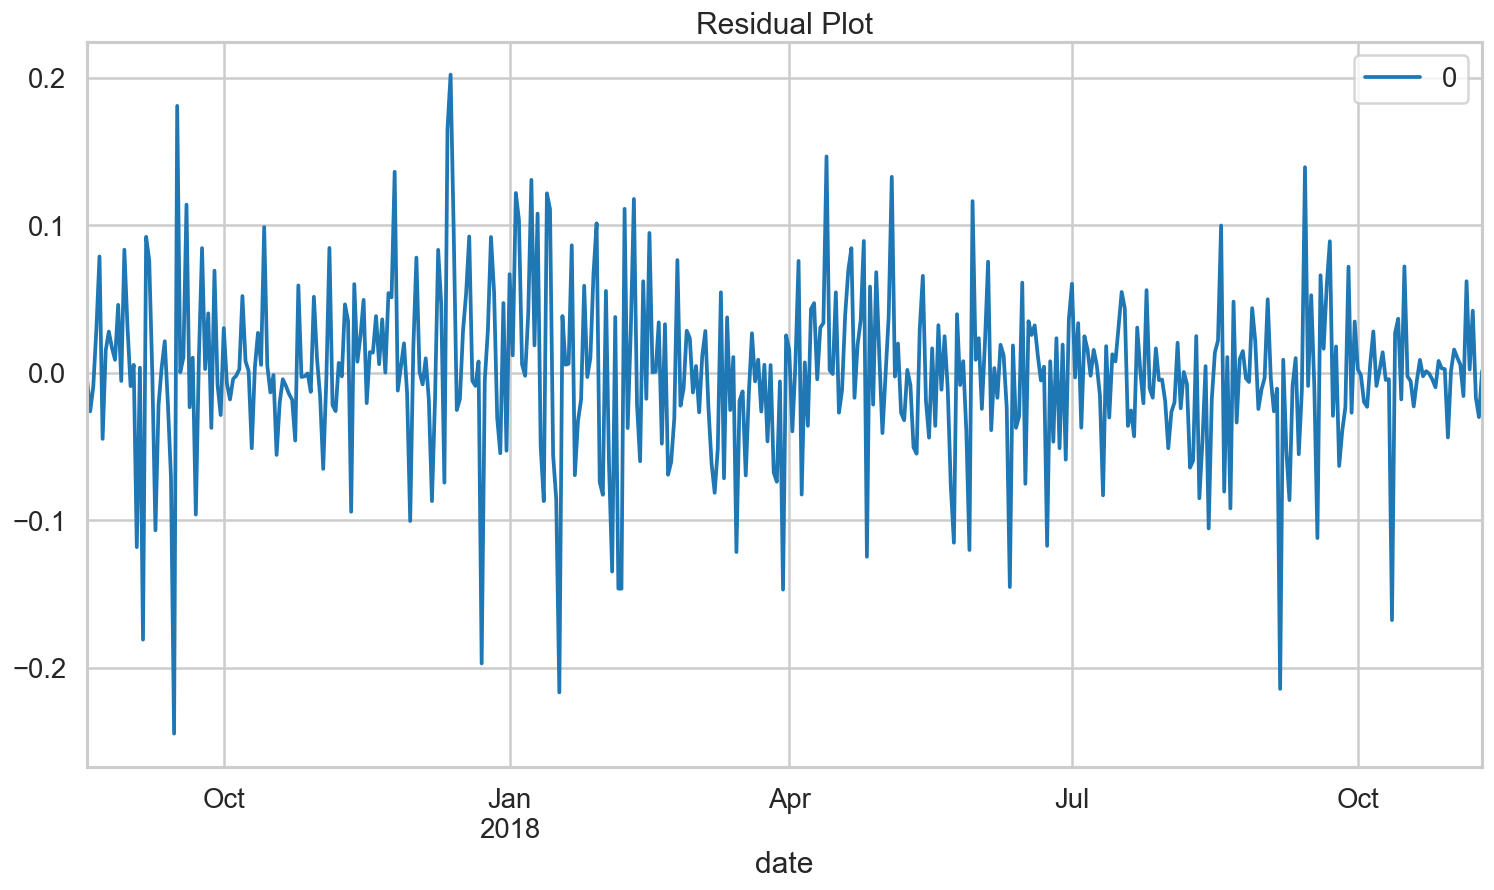

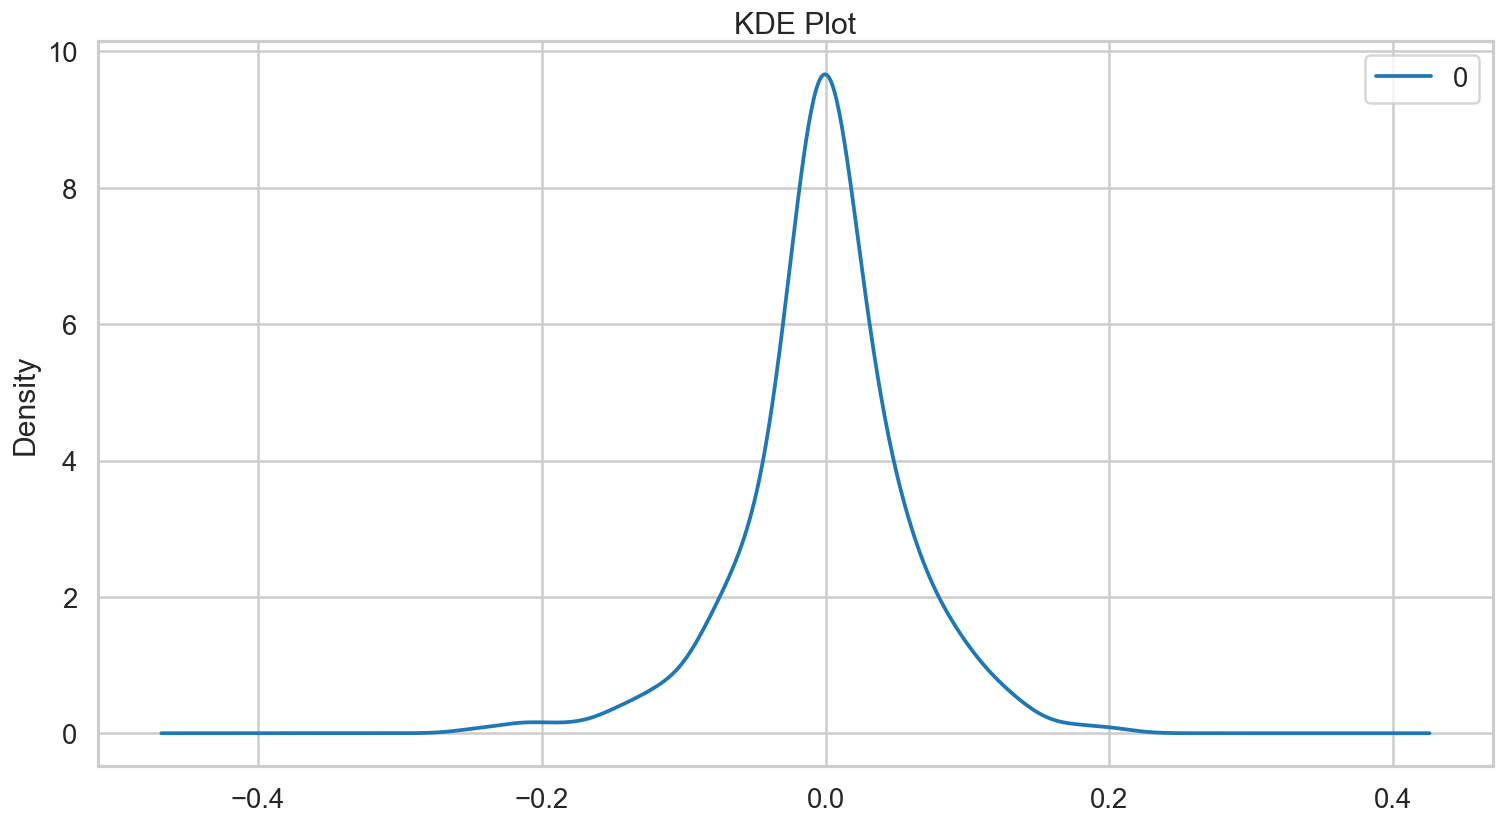

                0
count  450.000000
mean     0.000017
std      0.057084
min     -0.244607
25%     -0.023992
50%      0.000738
75%      0.028494
max      0.202173


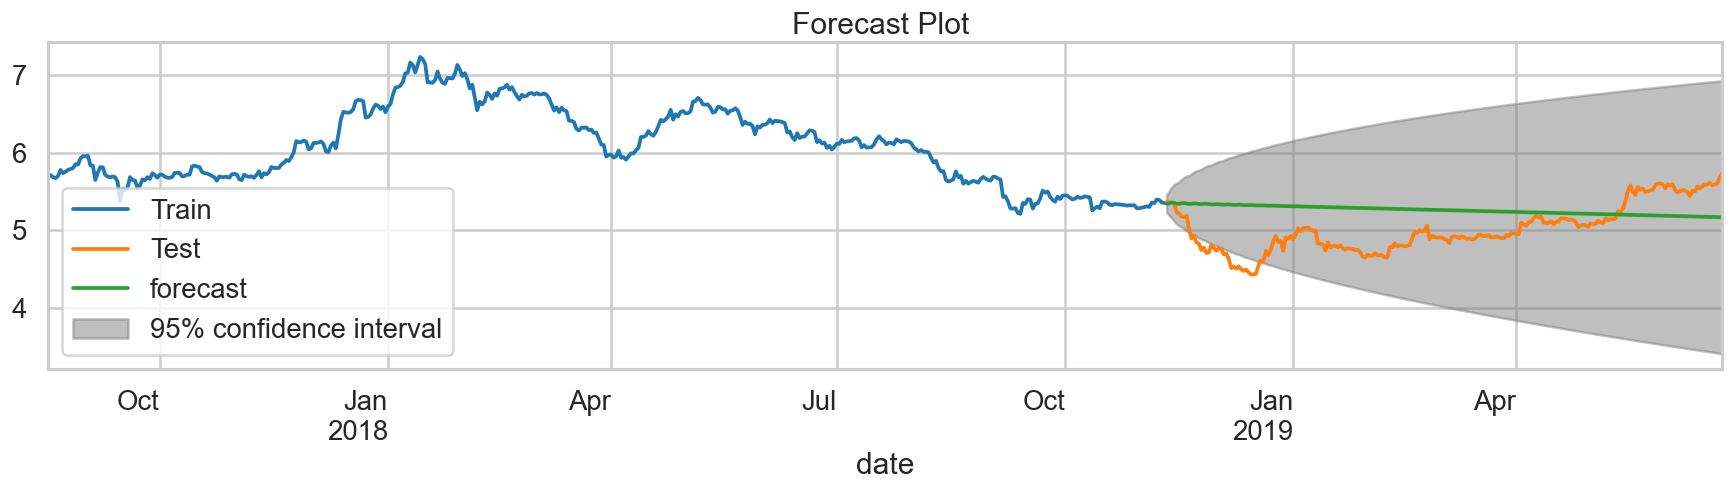

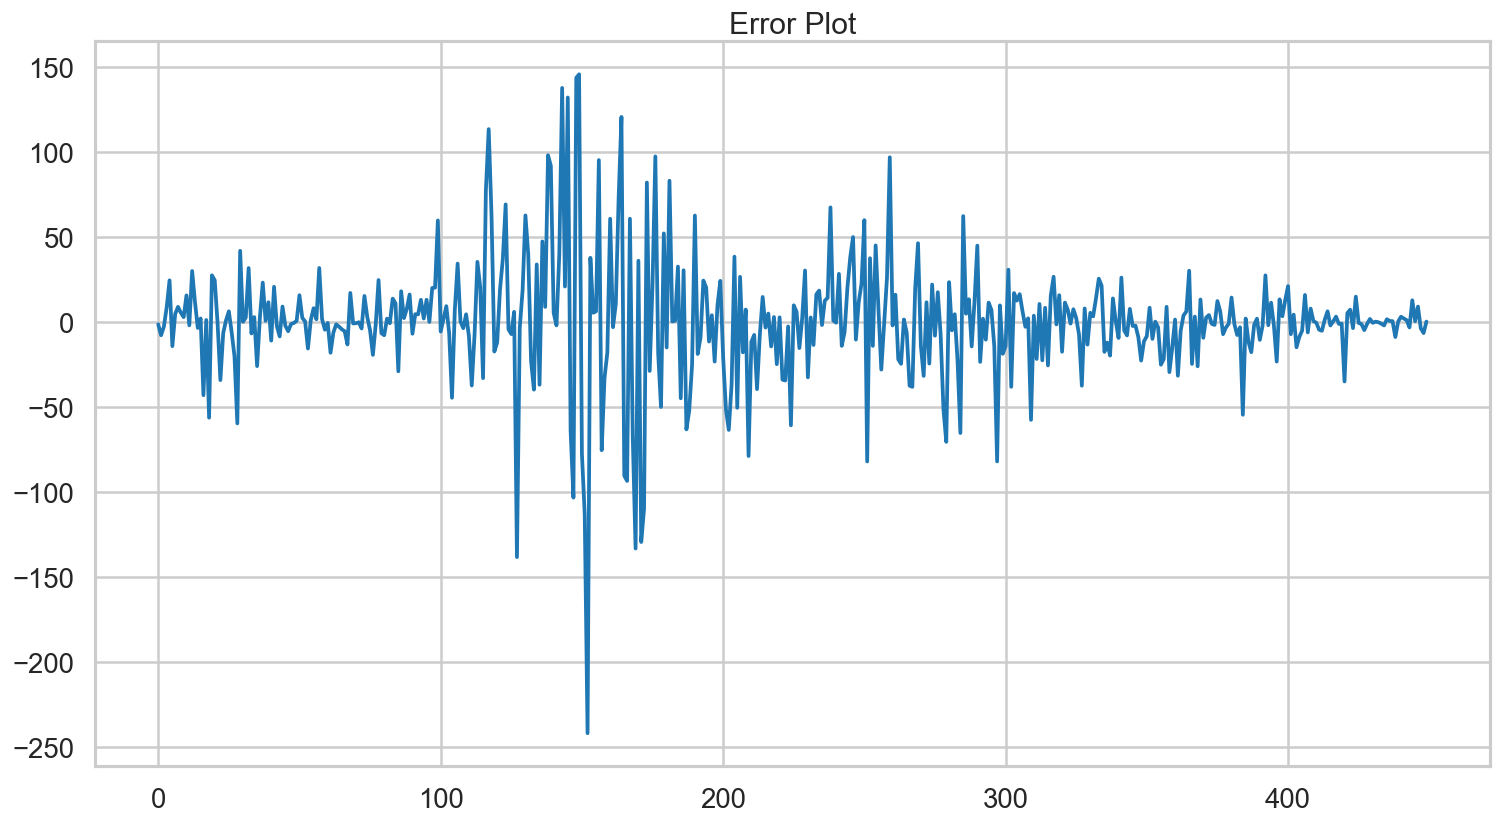

********************
Iteration 3 of 5
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 2

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(0, 0, 1)- AIC:512.4022244552241


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 2)- AIC:-98.54515441001718
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARIMA(0, 1, 0)- AIC:-1978.1249837254186


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\s

ARIMA(0, 1, 1)- AIC:-1976.4800260066988


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)- AIC:-1977.1282758369732


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 3)- AIC:-1975.378989980409
ARIMA(0, 2, 0)- AIC:-1491.35550768466


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)- AIC:-1966.760871580096


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)- AIC:-1965.381062523017


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 3)- AIC:-1964.7570059147845
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(1, 0, 0)- AIC:-1976.435207051751


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)- AIC:-1974.7459263043509


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 0, 2)- AIC:-1975.5269785335606


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 0, 3)- AIC:-1973.819560829622
ARIMA(1, 1, 0)- AIC:-1976.5206454779902


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 1)- AIC:-1974.8892906114904


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 2)- AIC:-1975.2219284512923


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 3)- AIC:-1975.9644734741844
ARIMA(1, 2, 0)- AIC:-1721.725081972652


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 1)- AIC:-1965.4450345360112


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 2)- AIC:-1963.8088647569632


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(1, 2, 3)- AIC:-1961.7767641890716
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(2, 0, 0)- AIC:-1974.7825598786087
ARIMA(2, 0, 1)- AIC:-1973.1491070272448


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 2)- AIC:-1973.6408496047818


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 3)- AIC:-1974.4344557422894


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 0)- AIC:-1976.6563346101732


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(2, 1, 1)- AIC:-1975.768960559981


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 2)- AIC:-1985.4399627345872


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 3)- AIC:-1985.2078837976499
ARIMA(2, 2, 0)- AIC:-1802.6056502412364


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(2, 2, 1)- AIC:-1965.086134220445


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 2, 2)- AIC:-1961.802388652465


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(2, 2, 3)- AIC:-1966.622124316488
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(3, 0, 0)- AIC:-1975.0409723939908


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(3, 0, 1)- AIC:-1974.5756136667362


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 2)- AIC:-1985.2449759322433


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 3)- AIC:-1975.5881610590216


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 0)- AIC:-1975.6738861877159


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 1, 1)- AIC:-1976.5635105580434


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 2)- AIC:-1976.877505058156


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 3)- AIC:-1975.5110387721595
ARIMA(3, 2, 0)- AIC:-1821.0188949899646


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 2, 1)- AIC:-1963.8571533421593


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 2, 2)- AIC:-1964.6624117897388


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(3, 2, 3)- AIC:-1972.722067422965
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
Best Model params:(2, 1, 2) AIC:-1985.4399627345872
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                  675
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 998.720
Method:                       css-mle   S.D. of innovations              0.055
Date:                Fri, 04 Jun 2021   AIC                          -1985.440
Time:                        17:52:05   BIC                          -1958.352
Sample:                    08-18-2017   HQIC                         -1974.951
                         - 06-23-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

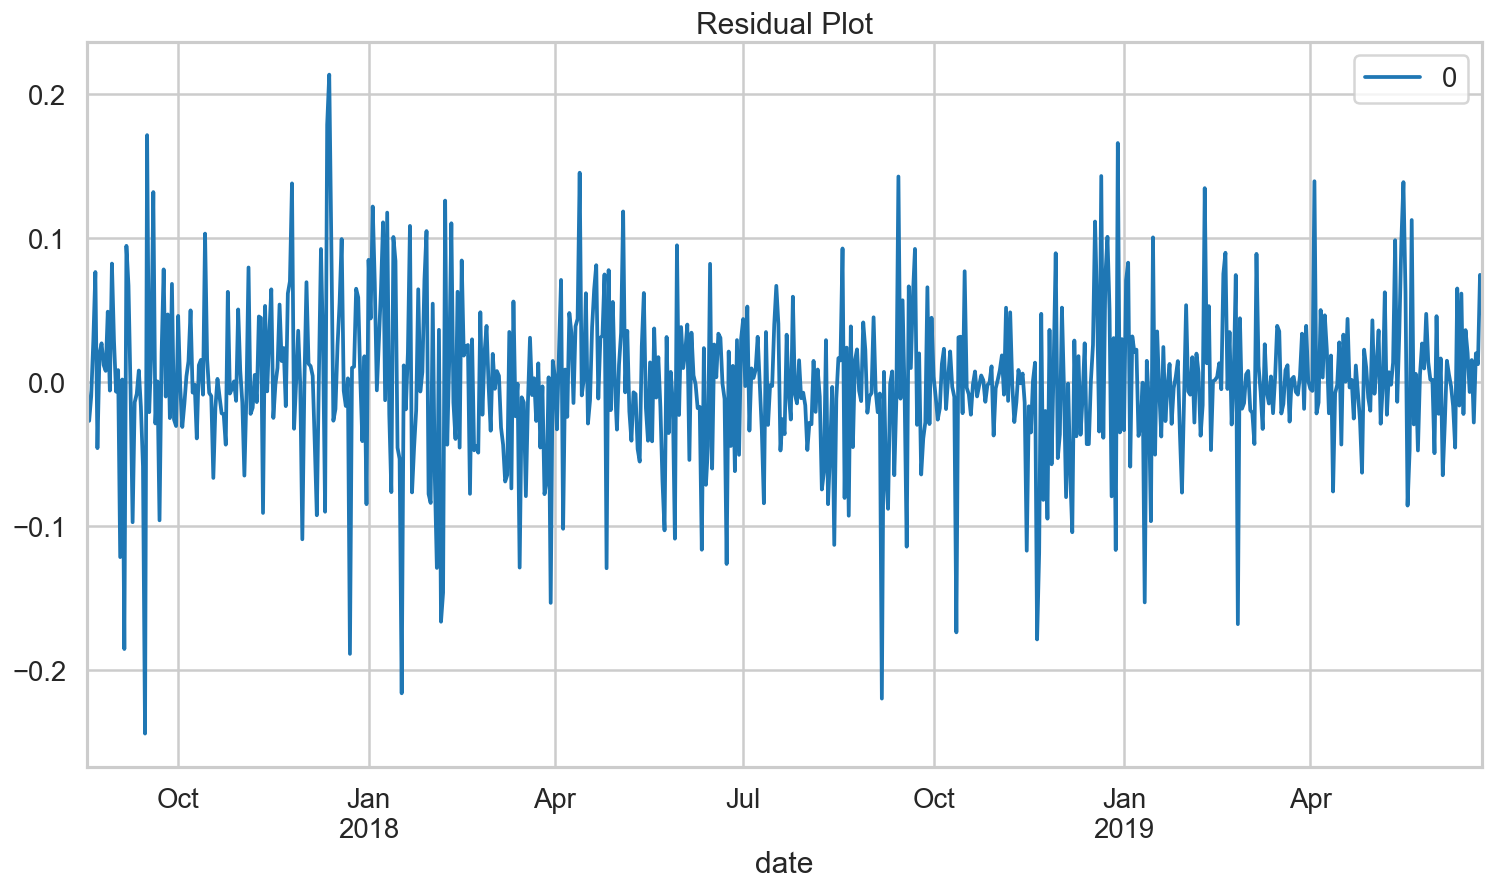

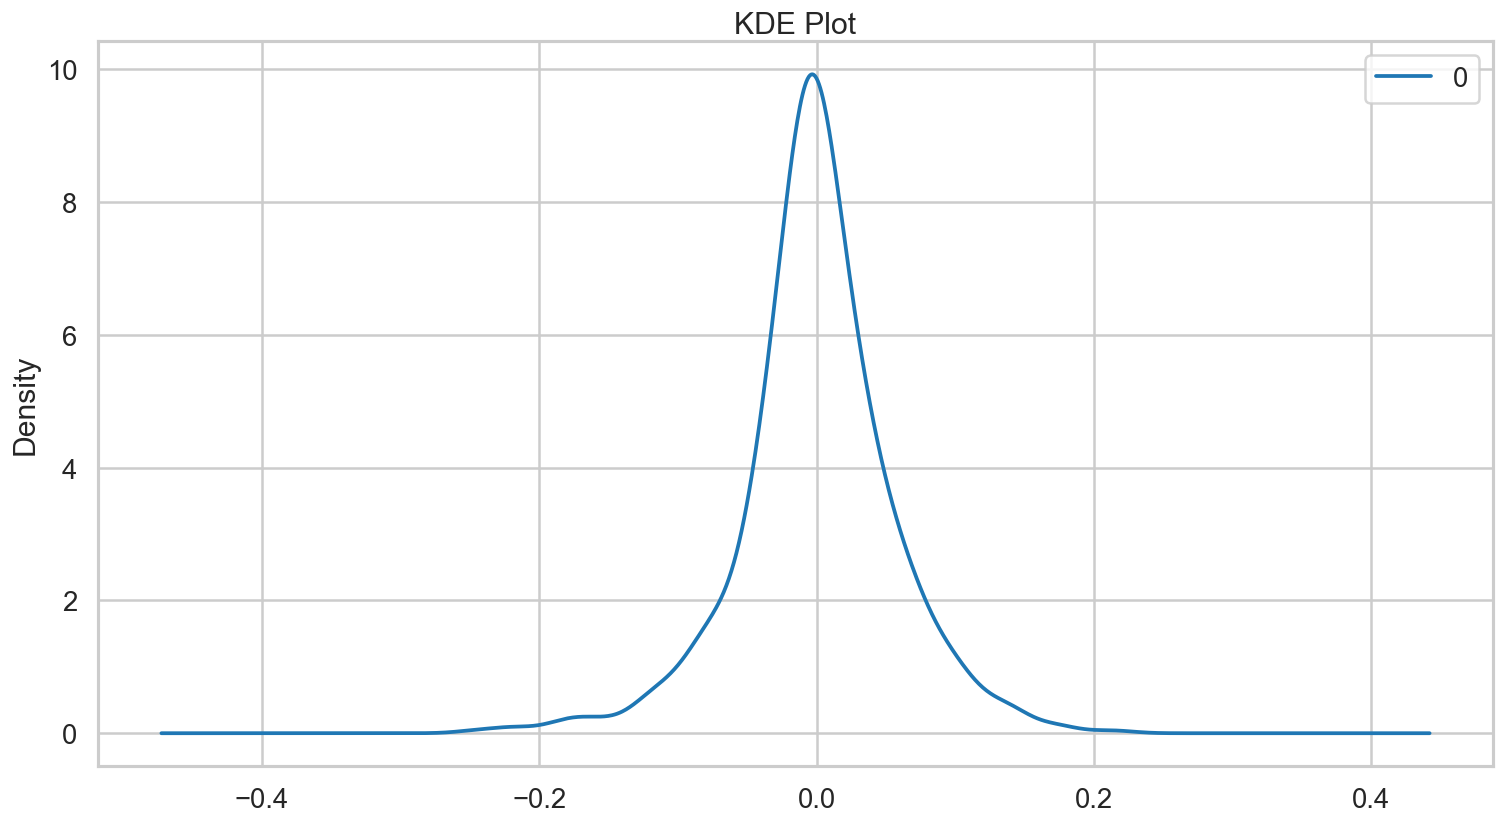

                0
count  675.000000
mean    -0.000010
std      0.055172
min     -0.243930
25%     -0.025490
50%     -0.001348
75%      0.028989
max      0.213416


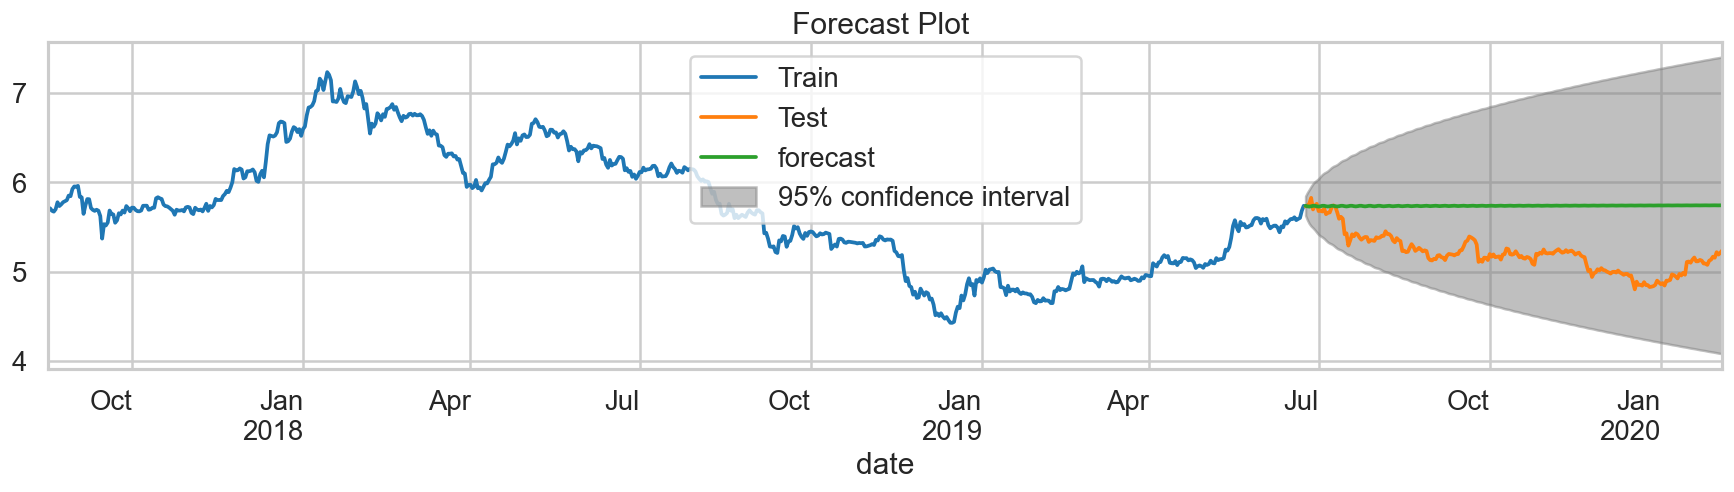

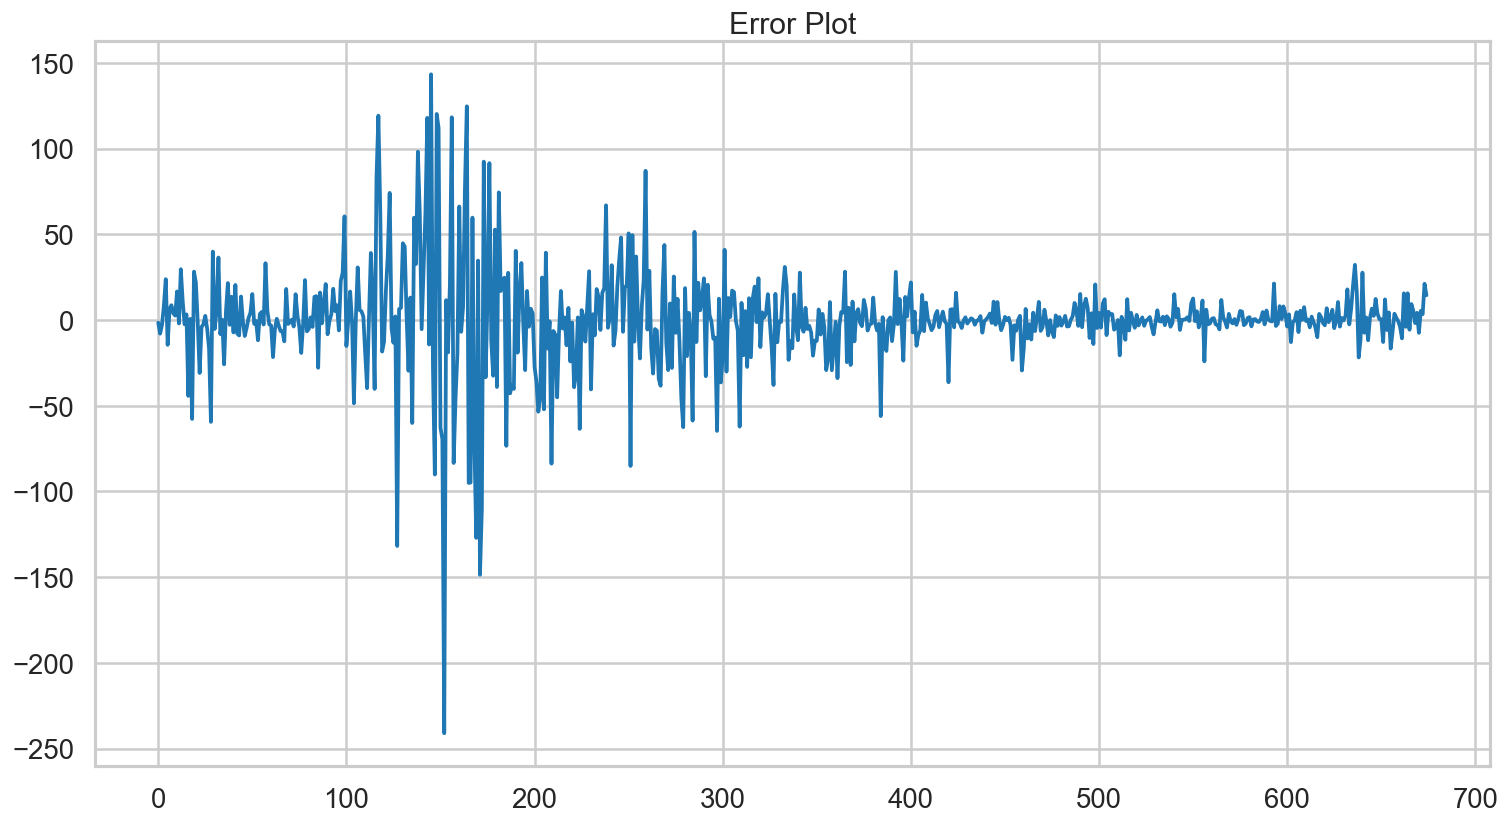

********************
Iteration 4 of 5
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 2

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(0, 0, 1)- AIC:575.6927482844242
ARIMA(0, 0, 2)- AIC:-235.4146976062152
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'



ARIMA(0, 1, 0)- AIC:-2752.8162477325677


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)- AIC:-2751.8379161364246
ARIMA(0, 1, 2)- AIC:-2753.534296702185


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 3)- AIC:-2751.7985967201676
ARIMA(0, 2, 0)- AIC:-2094.273199780321


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)- AIC:-2740.0184613153288


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)- AIC:-2738.98050240862


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 3)- AIC:-2740.7889573767907
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(1, 0, 0)- AIC:-2751.294977241707


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)- AIC:-2750.2177565027023


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 0, 2)- AIC:-2752.110868754433


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 0, 3)- AIC:-2750.4300387584135
ARIMA(1, 1, 0)- AIC:-2751.958305617796


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 1)- AIC:-2750.670363890079


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 2)- AIC:-2751.644841073209


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 1, 3)- AIC:-2752.499254196404
ARIMA(1, 2, 0)- AIC:-2409.5402378816198


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 1)- AIC:-2739.095877948761


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 2)- AIC:-2736.8179524056313


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(1, 2, 3)- AIC:-2737.770804359263
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(2, 0, 0)- AIC:-2750.330028195189


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 0, 1)- AIC:-2749.04791664838


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 2)- AIC:-2750.250849601259


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 0, 3)- AIC:-2751.160763134496


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 0)- AIC:-2752.917620715869


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(2, 1, 1)- AIC:-2751.646577436437


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 2)- AIC:-2761.6377530392965


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 1, 3)- AIC:-2762.586259056069
ARIMA(2, 2, 0)- AIC:-2518.0621272707886


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(2, 2, 1)- AIC:-2739.179316178622


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnin

ARIMA(2, 2, 2)- AIC:-2737.0645221968516


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(2, 2, 3)- AIC:-2744.9092451712686
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(3, 0, 0)- AIC:-2751.4731639798665


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(3, 0, 1)- AIC:-2750.5683863920985


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 2)- AIC:-2754.2850056917623


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 0, 3)- AIC:-2751.9027794063686


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 0)- AIC:-2752.0897856790243


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 1, 1)- AIC:-2753.2099572000843


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 2)- AIC:-2753.2439629344635


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 1, 3)- AIC:-2751.2097812358543
ARIMA(3, 2, 0)- AIC:-2546.555323190025


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA

ARIMA(3, 2, 1)- AIC:-2739.3996024727403


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

ARIMA(3, 2, 2)- AIC:-2740.516274997324


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(3, 2, 3)- AIC:-2738.8487596765626
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
Best Model params:(2, 1, 3) AIC:-2762.586259056069
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                  900
Model:                 ARIMA(2, 1, 3)   Log Likelihood                1388.293
Method:                       css-mle   S.D. of innovations              0.052
Date:                Fri, 04 Jun 2021   AIC                          -2762.586
Time:                        17:52:32   BIC                          -2728.969
Sample:                    08-18-2017   HQIC                         -2749.744
                         - 02-03-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

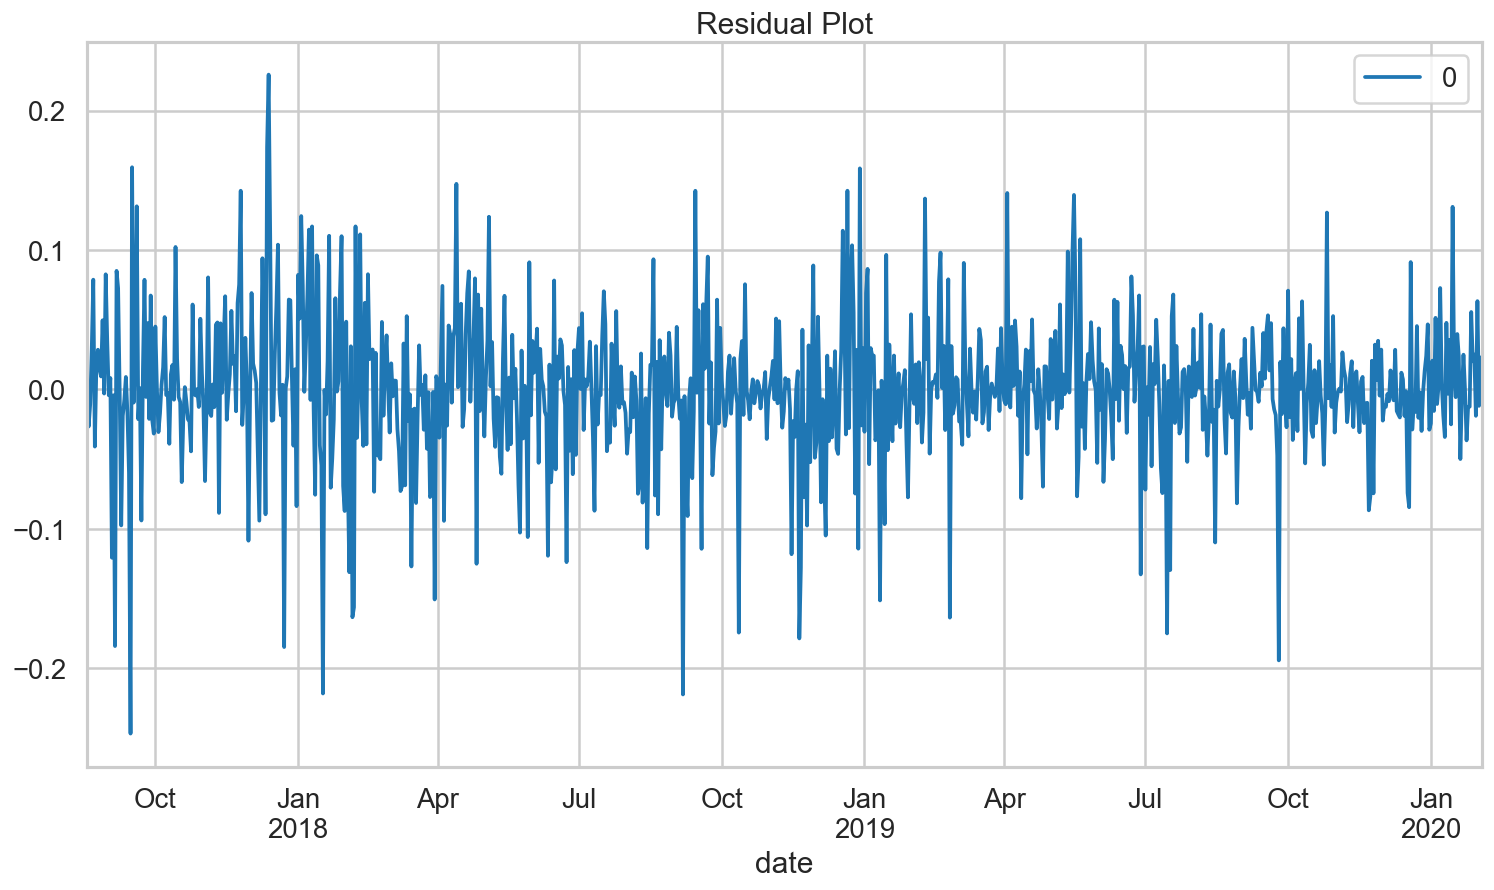

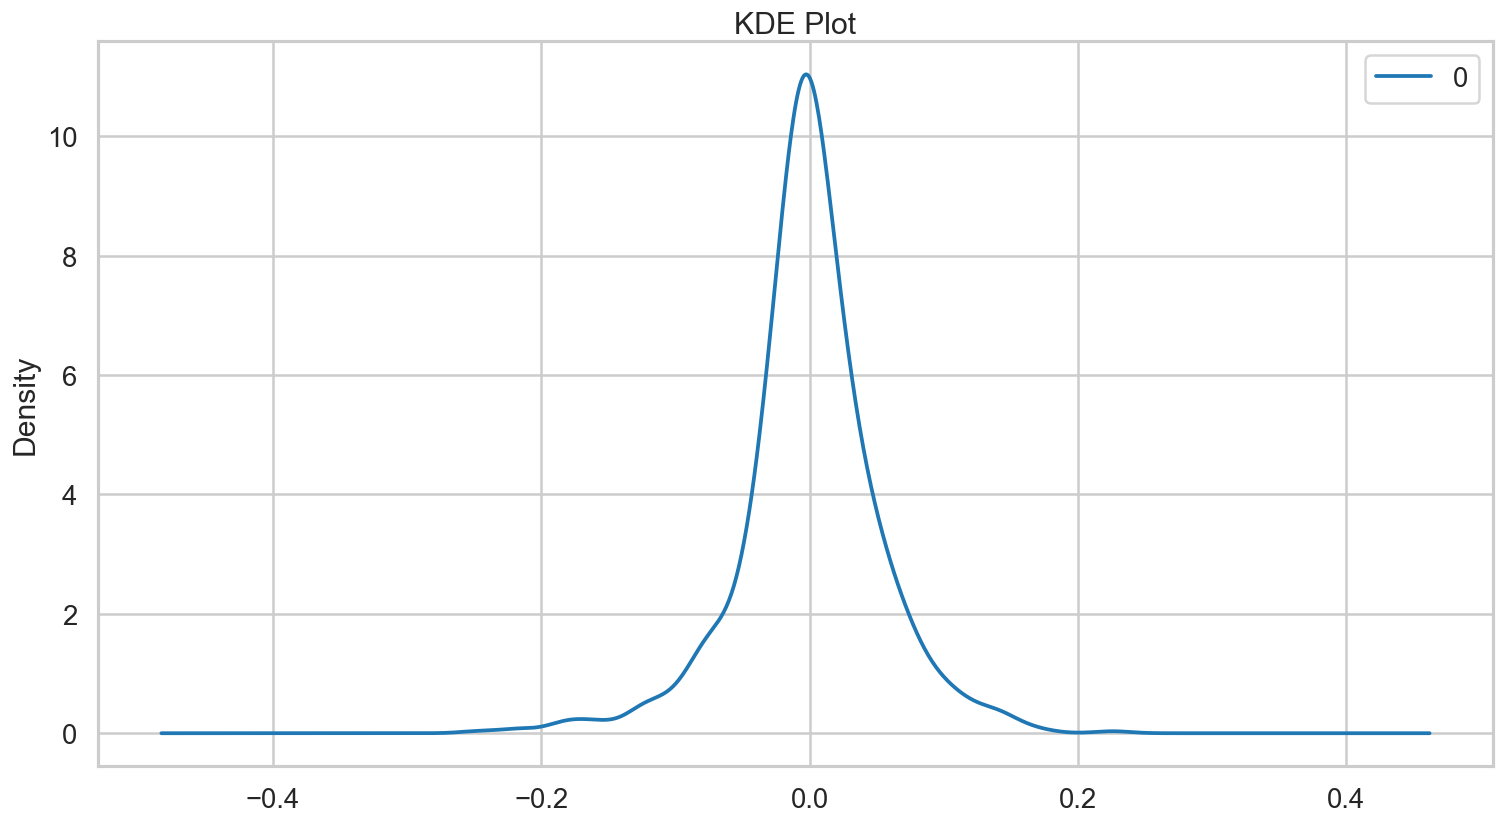

                0
count  900.000000
mean    -0.000009
std      0.051804
min     -0.246773
25%     -0.022254
50%     -0.000642
75%      0.024928
max      0.225725


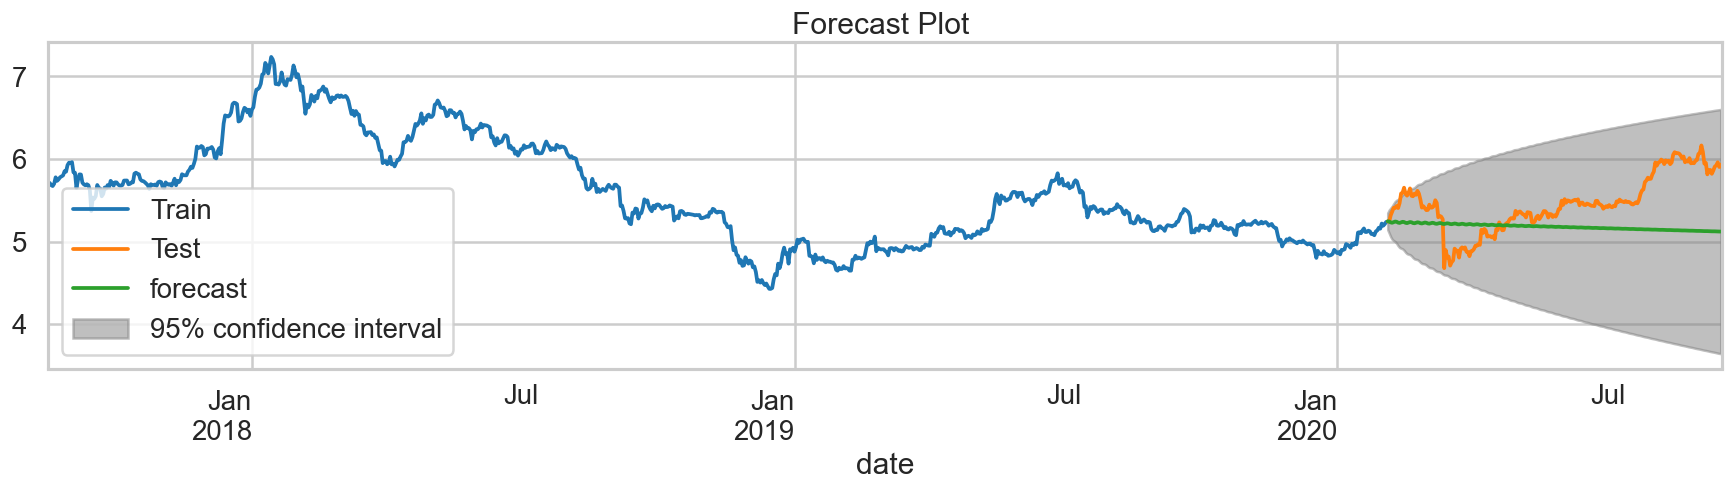

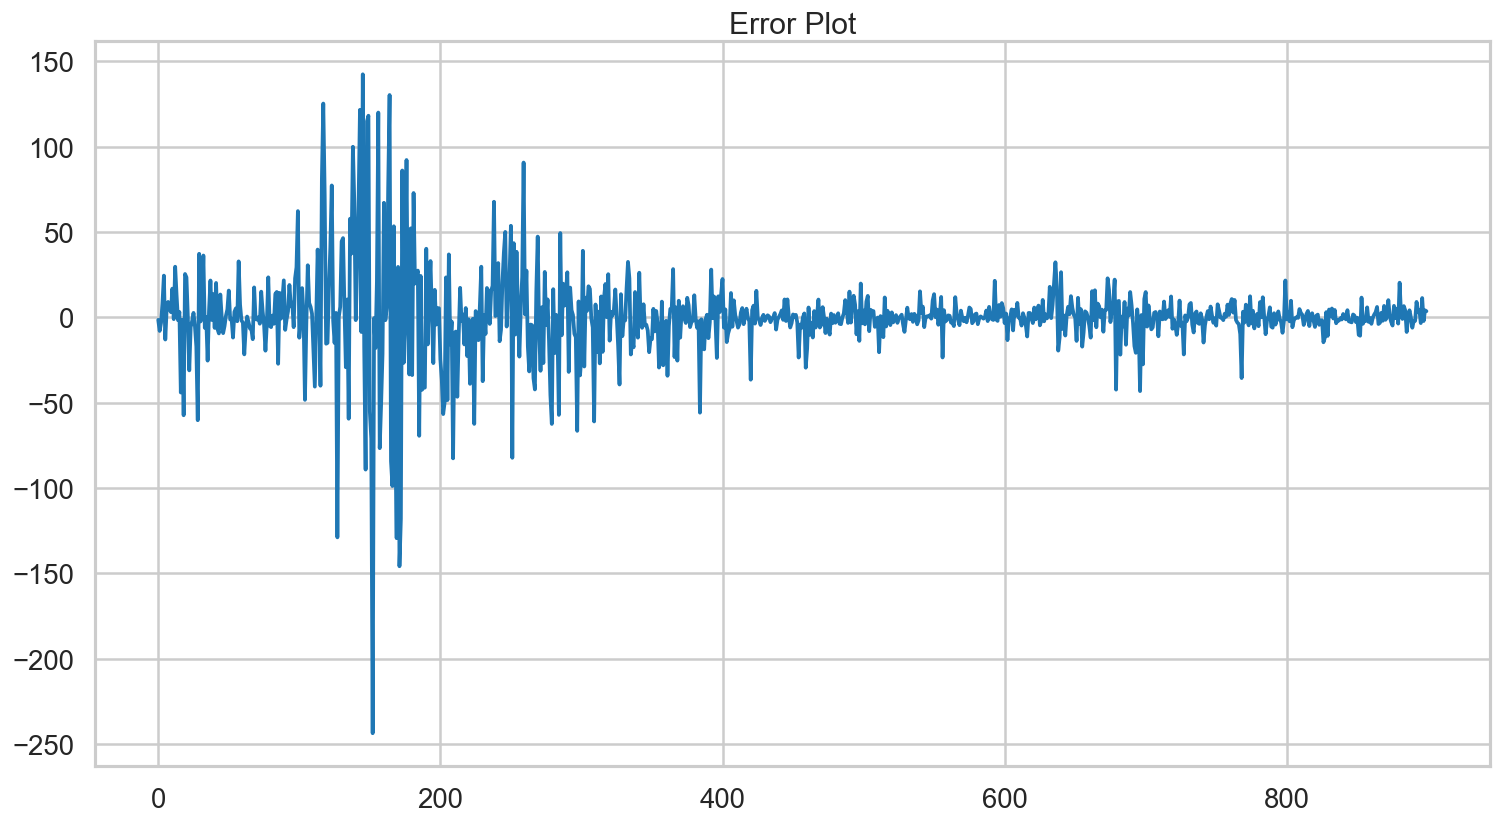

********************
Iteration 5 of 5
TRAIN: [   0    1    2 ... 1123 1124 1125] TEST: [1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251
 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265
 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279
 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293
 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(0, 0, 1)- AIC:597.2750842984901


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(0, 0, 2)- AIC:-407.89375733744555
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARIMA(0, 1, 0)- AIC:-3340.9559083846416


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model

ARIMA(0, 1, 1)- AIC:-3345.1608011405915


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(0, 1, 2)- AIC:-3349.923096014063


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(0, 1, 3)- AIC:-3348.0394170505197
ARIMA(0, 2, 0)- AIC:-2471.9884886925825


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model

ARIMA(0, 2, 1)- AIC:-3328.160049986064


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(0, 2, 2)- AIC:-3332.2512199262355


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it h

ARIMA(0, 2, 3)- AIC:-3337.1265621403445
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(1, 0, 0)- AIC:-3340.5666778939217
ARIMA(1, 0, 1)- AIC:-3344.4445186639555


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(1, 0, 2)- AIC:-3349.525309495269


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(1, 0, 3)- AIC:-3347.6040459382507
ARIMA(1, 1, 0)- AIC:-3346.104560290817


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(1, 1, 1)- AIC:-3347.843775354825


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(1, 1, 2)- AIC:-3348.064886616662


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(1, 1, 3)- AIC:-3346.0648895815684
ARIMA(1, 2, 0)- AIC:-2917.5851570270415


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.AR

ARIMA(1, 2, 1)- AIC:-3333.187095392076


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(1, 2, 2)- AIC:-3333.661464130101


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue usi

ARIMA(1, 2, 3)- AIC:-3331.6636420698796
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(2, 0, 0)- AIC:-3345.3654909779966
ARIMA(2, 0, 1)- AIC:-3347.1776968539493


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(2, 0, 2)- AIC:-3347.6287526584224


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(2, 0, 3)- AIC:-3345.6301806808265


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(2, 1, 0)- AIC:-3350.0982175294057


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.AR

ARIMA(2, 1, 1)- AIC:-3348.4816053704135


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(2, 1, 2)- AIC:-3347.5042407859573


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(2, 1, 3)- AIC:-3345.681790069514
ARIMA(2, 2, 0)- AIC:-3039.50395166984


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.AR

ARIMA(2, 2, 1)- AIC:-3336.4744420391216


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(2, 2, 2)- AIC:-3331.072114270317


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(2, 2, 3)- AIC:-3332.2085179558353
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA(3, 0, 0)- AIC:-3349.683856389797


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ARIMA(3, 0, 1)- AIC:-3348.525978832449


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(3, 0, 2)- AIC:-3347.8999578762937


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(3, 0, 3)- AIC:-3343.9752152516144
ARIMA(3, 1, 0)- AIC:-3348.1634212232348


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(3, 1, 1)- AIC:-3346.230294537152


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(3, 1, 2)- AIC:-3345.6333151850085


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(3, 1, 3)- AIC:-3344.4978522502133
ARIMA(3, 2, 0)- AIC:-3106.0659311853115


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.AR

ARIMA(3, 2, 1)- AIC:-3335.316093610356


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided

ARIMA(3, 2, 2)- AIC:-3333.2972647250735


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',

ARIMA(3, 2, 3)- AIC:-3329.9446135543867
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
Best Model params:(2, 1, 0) AIC:-3350.0982175294057
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 1125
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1679.049
Method:                       css-mle   S.D. of innovations              0.054
Date:                Fri, 04 Jun 2021   AIC                          -3350.098
Time:                        17:52:57   BIC                          -3329.996
Sample:                             1   HQIC                         -3342.502
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const     

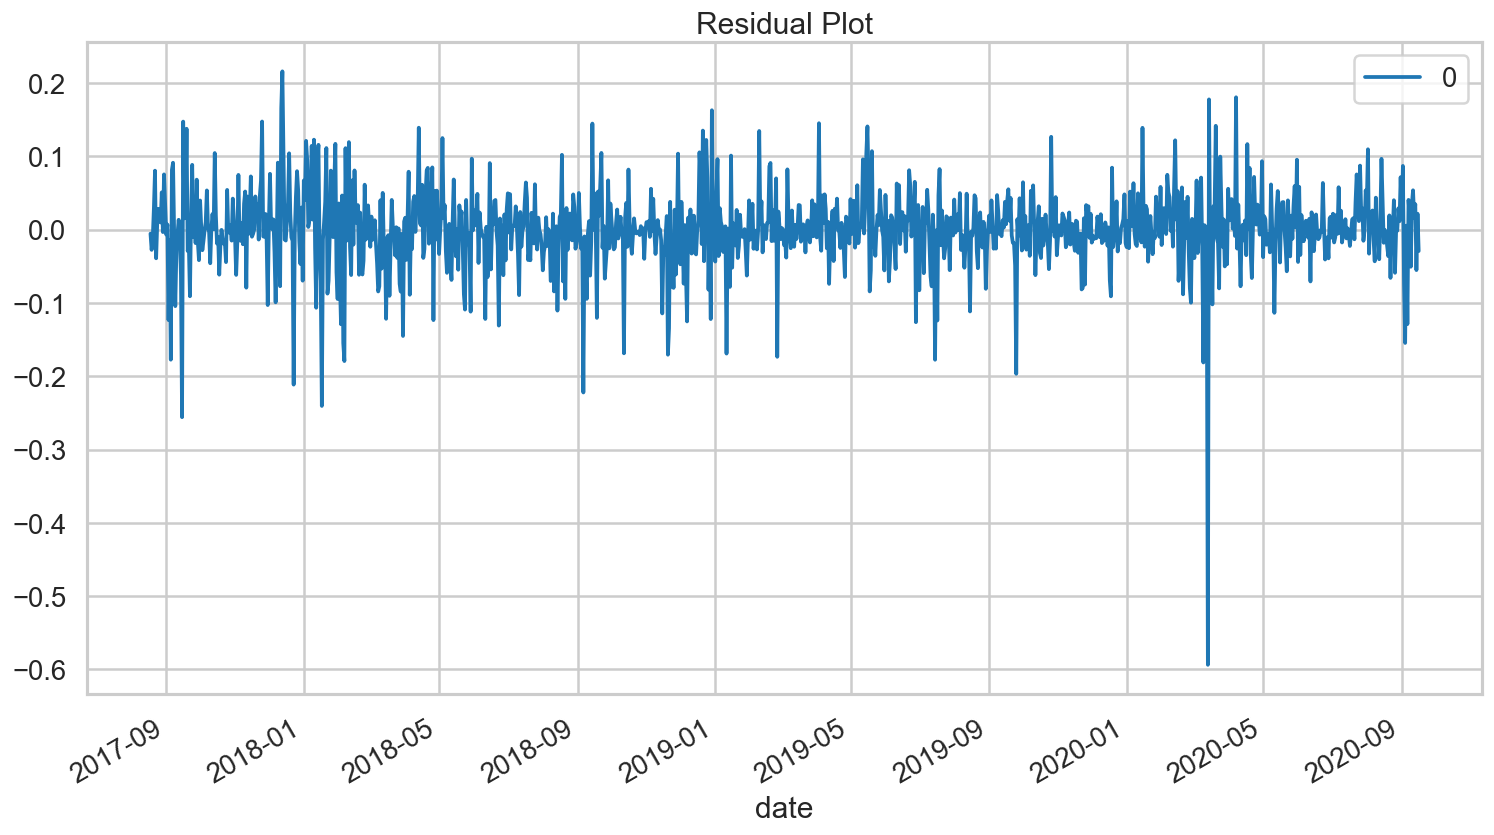

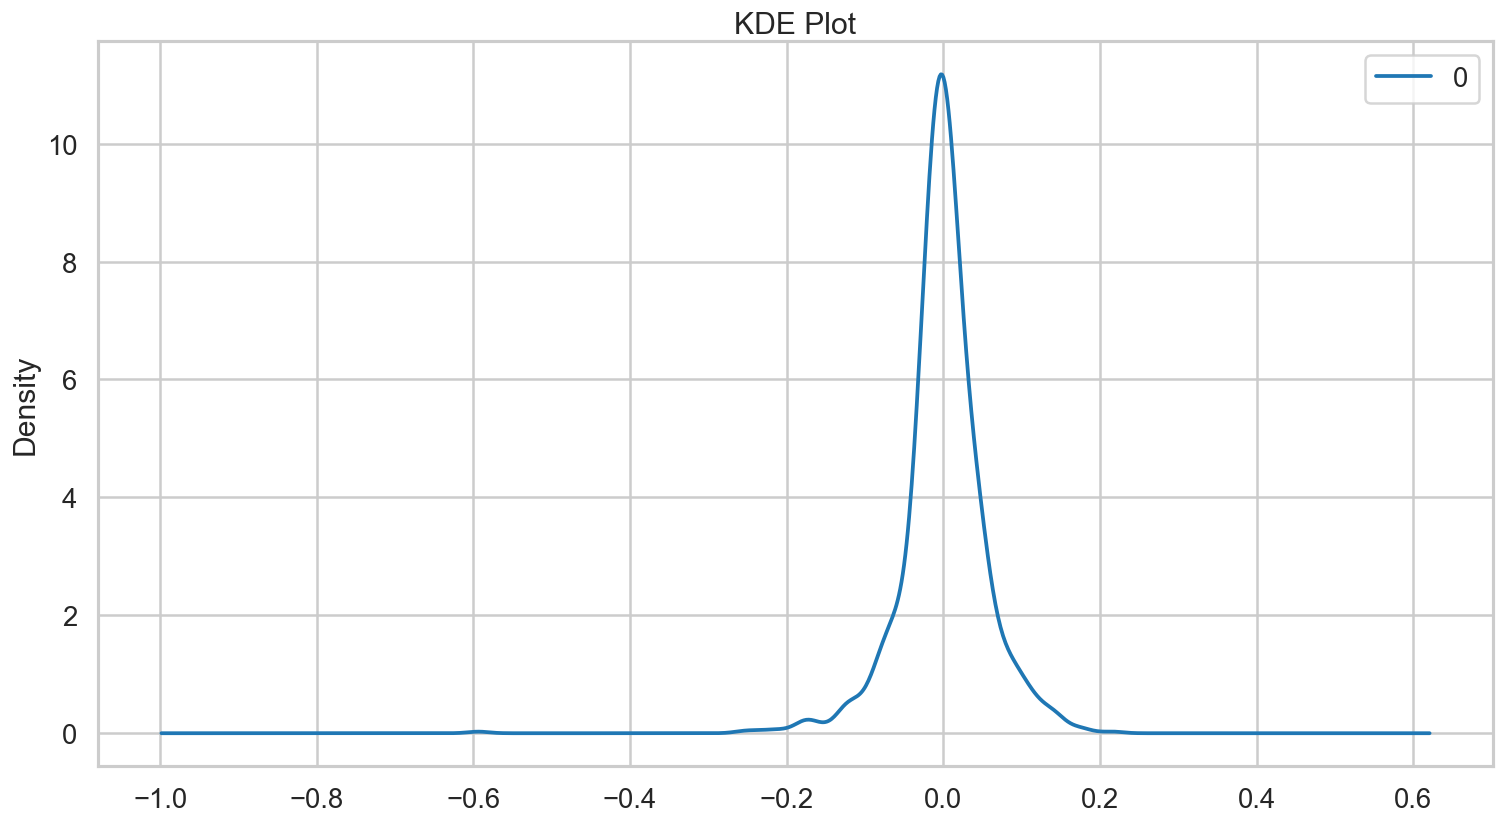

                 0
count  1125.000000
mean      0.000002
std       0.054422
min      -0.593636
25%      -0.021710
50%      -0.000544
75%       0.023883
max       0.215920


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


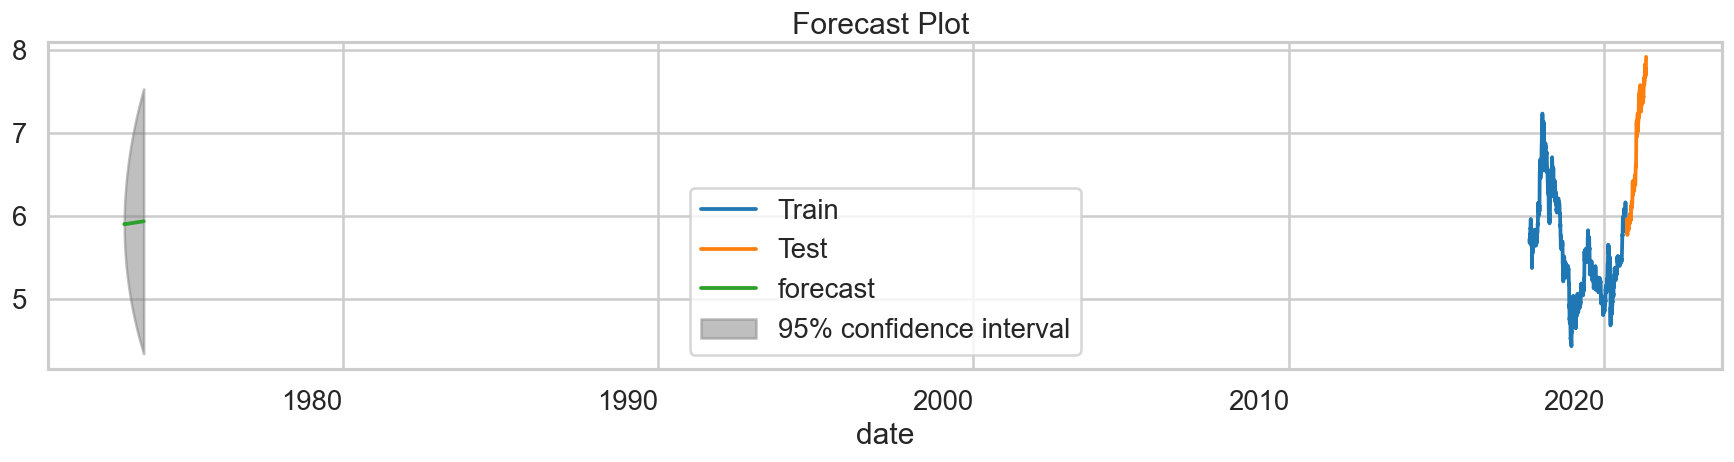

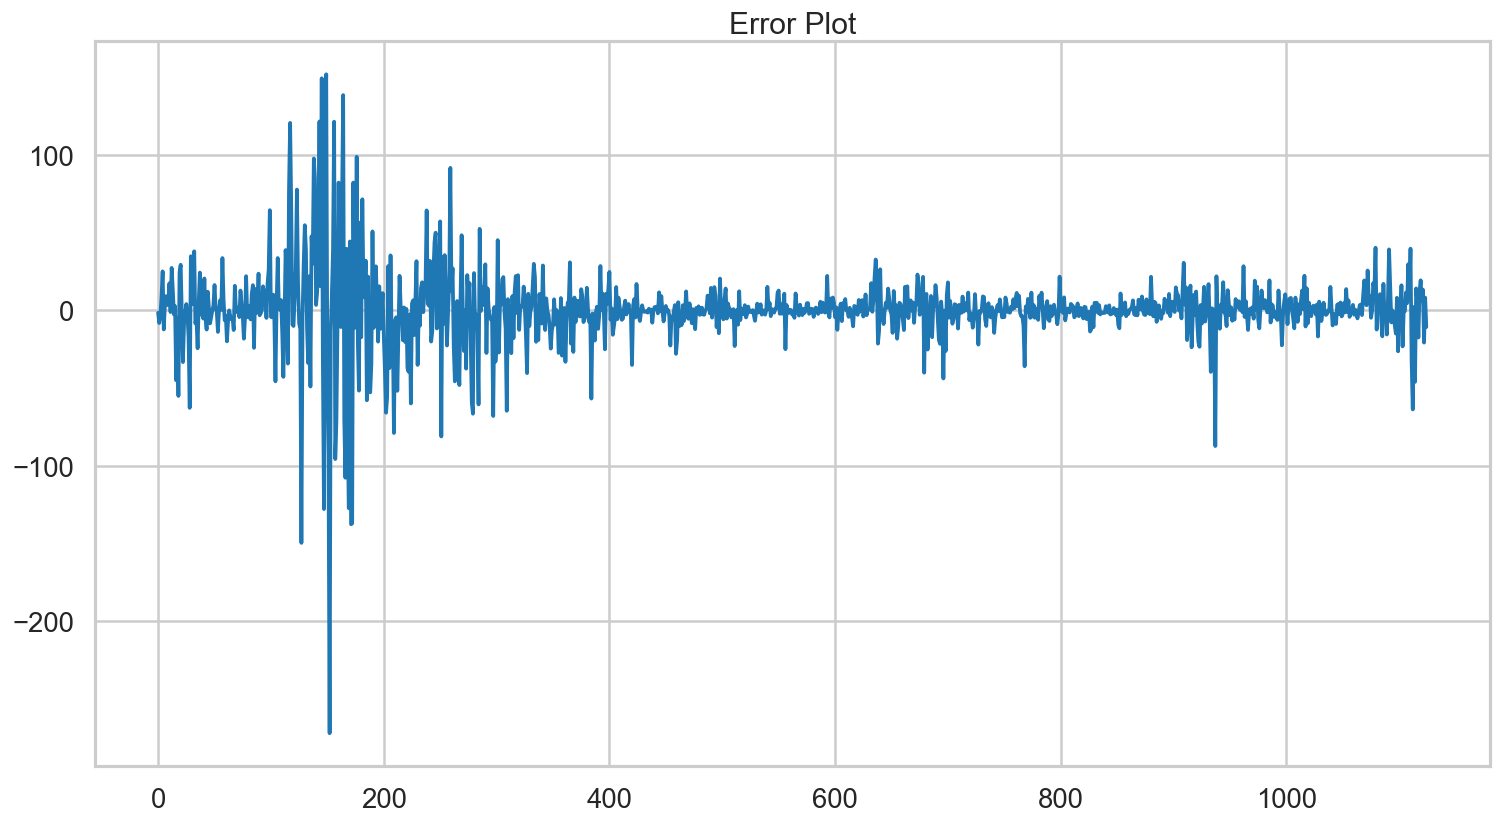

In [37]:
from ipynb.fs.full.arima_utils import arima_gridsearch_cv
df['log_series']=np.log(df.open)
results_dict = arima_gridsearch_cv(df.log_series,cv_splits=5)

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARM

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1249
Model:                 ARIMA(5, 1, 5)   Log Likelihood                1879.492
Method:                       css-mle   S.D. of innovations              0.054
Date:                Fri, 04 Jun 2021   AIC                          -3734.985
Time:                        17:53:05   BIC                          -3673.423
Sample:                             1   HQIC                         -3711.841
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.646      0.519      -0.002       0.005
ar.L1.D.y     -0.2765      0.699     -0.396      0.692      -1.646       1.093
ar.L2.D.y     -0.1750      0.388     -0.451      0.6

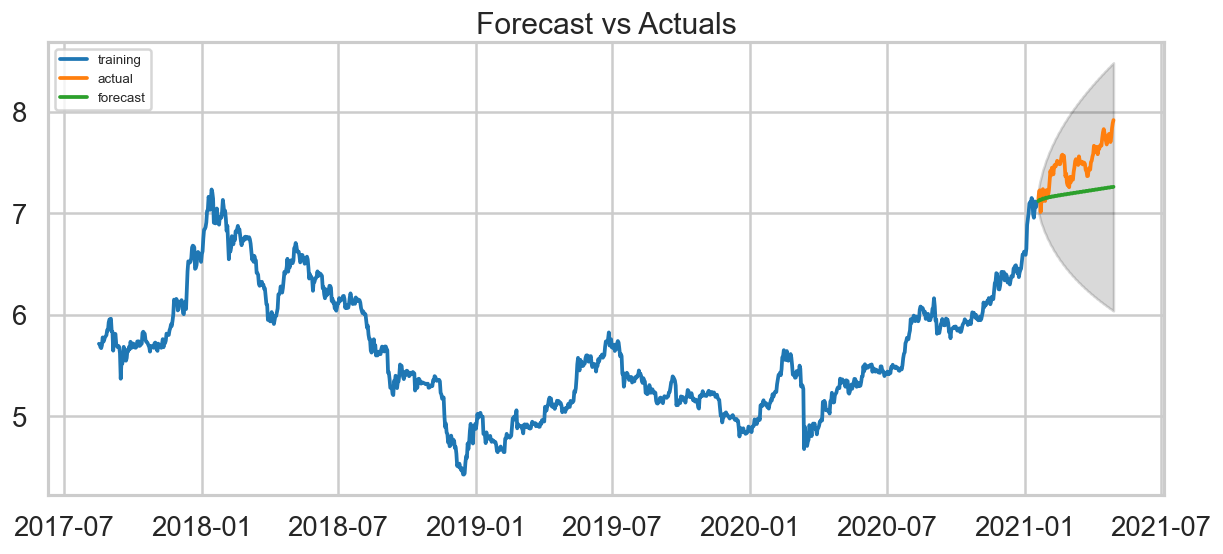

In [38]:
# out of Time cross validation
train=df.log_series[:1250]
test=df.log_series[1250:]
model=ARIMA(train.tolist(), order=(5,1,5))
fitted=model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)
fc_series=pd.Series(fc, index=test.index)
lower_series=pd.Series(conf[:,0], index=test.index)
upper_series=pd.Series(conf[:,1], index=test.index)

plt.figure(figsize=(12,5), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

***
# Part Three: LSTM Modeling
***

In [39]:
from ipynb.fs.full.lstm_utils import get_reg_train_test

WINDOW=6
PRED_LENGTH=3
x_train, y_train, x_test, y_test, scaler=get_reg_train_test(df.open,train_size=0.95, 
                                                            sequence_length=WINDOW+1,
                                                           roll_mean_window=None,
                                                           normalize=True,
                                                           scale=False)

In [40]:
print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

x_train shape=(1278, 6, 1)
y_train shape=(1278,)
x_test shape=(67, 6, 1)
y_test shape=(67,)


In [41]:
x_test

array([[[ 0.        ],
        [ 0.00149494],
        [ 0.03954859],
        [ 0.08968544],
        [ 0.0989867 ],
        [ 0.07506758]],

       [[ 0.        ],
        [ 0.03799685],
        [ 0.08805886],
        [ 0.09734623],
        [ 0.07346281],
        [ 0.08504537]],

       [[ 0.        ],
        [ 0.04822944],
        [ 0.05717684],
        [ 0.0341677 ],
        [ 0.04532627],
        [-0.03907661]],

       [[ 0.        ],
        [ 0.00853572],
        [-0.01341475],
        [-0.0027696 ],
        [-0.08328906],
        [-0.18624897]],

       [[ 0.        ],
        [-0.0217647 ],
        [-0.01120964],
        [-0.09104763],
        [-0.19313614],
        [-0.16993444]],

       [[ 0.        ],
        [ 0.0107899 ],
        [-0.0708244 ],
        [-0.17518428],
        [-0.15146636],
        [-0.22521826]],

       [[ 0.        ],
        [-0.08074309],
        [-0.18398895],
        [-0.16052422],
        [-0.23348883],
        [-0.25289366]],

       [[ 0.        

In [42]:
from ipynb.fs.full.lstm_utils import get_reg_model
lstm_model = get_reg_model(layer_units=[100,250], window_size=WINDOW)

> Compilation Time :  0.0029926300048828125
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 6, 100)            40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 250)               351000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 392,051
Trainable params: 392,051
Non-trainable params: 0
____

In [43]:
import tensorflow
callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,verbose=0)]
lstm_model.fit(x_train, y_train,epochs=30, batch_size=20,verbose=1,validation_split=0.05,callbacks=callbacks)

Epoch 1/30
61/61 [==============================] - 5s 23ms/step - loss: 0.0069 - val_loss: 0.0110
Epoch 2/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 3/30
61/61 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 0.0064
Epoch 4/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 5/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 6/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 7/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0057
Epoch 8/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 9/30
61/61 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0060


Test Score: 0.10 RMSE


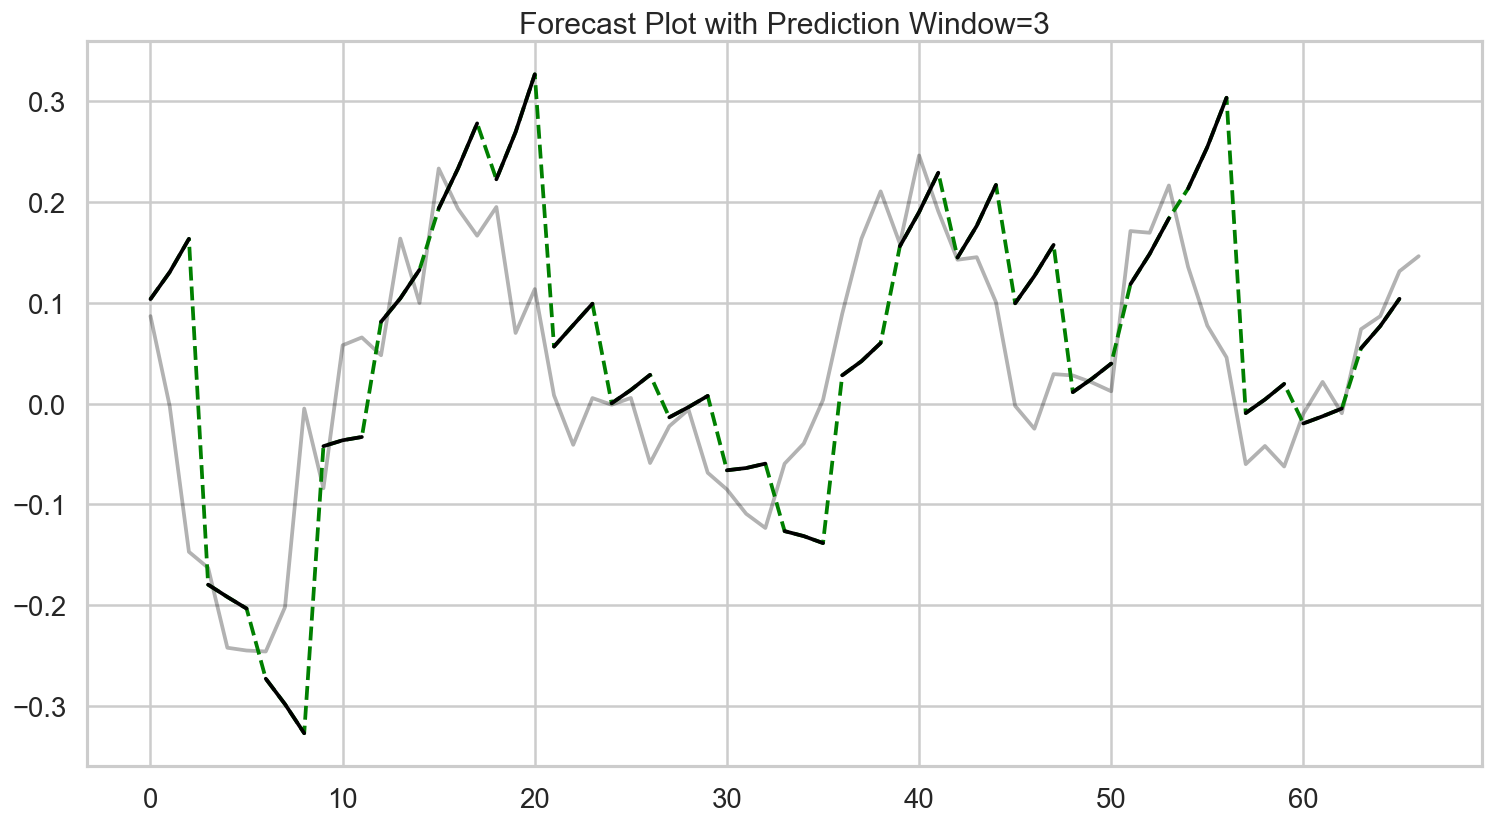

In [44]:
from ipynb.fs.full.lstm_utils import predict_reg_multiple
test_pred_seqs = predict_reg_multiple(lstm_model,x_test, window_size=WINDOW, 
                                      prediction_len=PRED_LENGTH)

test_pred=np.array(test_pred_seqs).flatten()
test_rmse=np.mean((test_pred-y_test[:len(test_pred)])**2)**0.5
print('Test Score: %.2f RMSE' % (test_rmse))

from ipynb.fs.full.lstm_utils import plot_reg_results
plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)

## Use LSTM as Sequence

In [45]:
from ipynb.fs.full.lstm_utils import get_seq_train_test
train,test,scaler = get_seq_train_test(df.open.values,
                                       scaling=True,
                                       train_size=0.9)
train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")
print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1214, 1)
train_y shape=(1, 1214, 1)
test_x shape=(1, 135, 1)
test_y shape=(1, 135, 1)


In [46]:
train_y

array([[[0.08191092],
        [0.07889344],
        [0.07774875],
        ...,
        [0.17290803],
        [0.18177656],
        [0.19030355]]])

In [47]:
# get the model
from ipynb.fs.full.lstm_utils import get_seq_model
seq_lstm_model = get_seq_model(hidden_units=4,
                               input_shape=(train_x.shape[1],1), verbose=True)

 # train the model
seq_lstm_model.fit(train_x, train_y,
epochs=250, batch_size=1,
verbose=2)

> Compilation Time :  0.0019936561584472656
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1214, 4)           96        
_________________________________________________________________
time_distributed (TimeDistri (None, 1214, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/250
1/1 - 2s - loss: 0.0092
Epoch 2/250
1/1 - 0s - loss: 0.0078
Epoch 3/250
1/1 - 0s - loss: 0.0069
Epoch 4/250
1/1 - 0s - loss: 0.0063
Epoch 5/250
1/1 - 0s - loss: 0.0058
Epoch 6/250
1/1 - 0s - loss: 0.0054
Epoch 7/250
1/1 - 0s - loss: 0.0051
Epoch 8/250
1/1 - 0s - loss: 0.0048
Epoch 9/250
1/1 - 0s - loss: 0.0046
Epoch 10/250
1/1 - 0s - loss: 0.0044
Epoch 11/250
1/1 - 0s - loss: 0.0042
Epoch 12/250
1/1 - 0s - loss: 0.0041
Epoch 13/250
1/1 - 0s - loss: 0.00

Epoch 190/250
1/1 - 0s - loss: 2.9359e-04
Epoch 191/250
1/1 - 0s - loss: 2.9263e-04
Epoch 192/250
1/1 - 0s - loss: 2.9168e-04
Epoch 193/250
1/1 - 0s - loss: 2.9077e-04
Epoch 194/250
1/1 - 0s - loss: 2.8985e-04
Epoch 195/250
1/1 - 0s - loss: 2.8897e-04
Epoch 196/250
1/1 - 0s - loss: 2.8807e-04
Epoch 197/250
1/1 - 0s - loss: 2.8720e-04
Epoch 198/250
1/1 - 0s - loss: 2.8631e-04
Epoch 199/250
1/1 - 0s - loss: 2.8543e-04
Epoch 200/250
1/1 - 0s - loss: 2.8454e-04
Epoch 201/250
1/1 - 0s - loss: 2.8366e-04
Epoch 202/250
1/1 - 0s - loss: 2.8277e-04
Epoch 203/250
1/1 - 0s - loss: 2.8191e-04
Epoch 204/250
1/1 - 0s - loss: 2.8103e-04
Epoch 205/250
1/1 - 0s - loss: 2.8019e-04
Epoch 206/250
1/1 - 0s - loss: 2.7934e-04
Epoch 207/250
1/1 - 0s - loss: 2.7851e-04
Epoch 208/250
1/1 - 0s - loss: 2.7769e-04
Epoch 209/250
1/1 - 0s - loss: 2.7688e-04
Epoch 210/250
1/1 - 0s - loss: 2.7607e-04
Epoch 211/250
1/1 - 0s - loss: 2.7528e-04
Epoch 212/250
1/1 - 0s - loss: 2.7447e-04
Epoch 213/250
1/1 - 0s - loss: 2.7

In [48]:
# train fit performance

import math
from sklearn.metrics import mean_squared_error

trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.02 RMSE


In [49]:
# Pad input sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
testPredict = pad_sequences(test_x,
                            maxlen=train_x.shape[1],
                            padding='post',dtype='float64')

In [50]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

# evaluate performance
import math
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(test_y[0],
testPredict[0][:test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.13 RMSE


In [51]:
testPredict.shape

(1, 1214, 1)

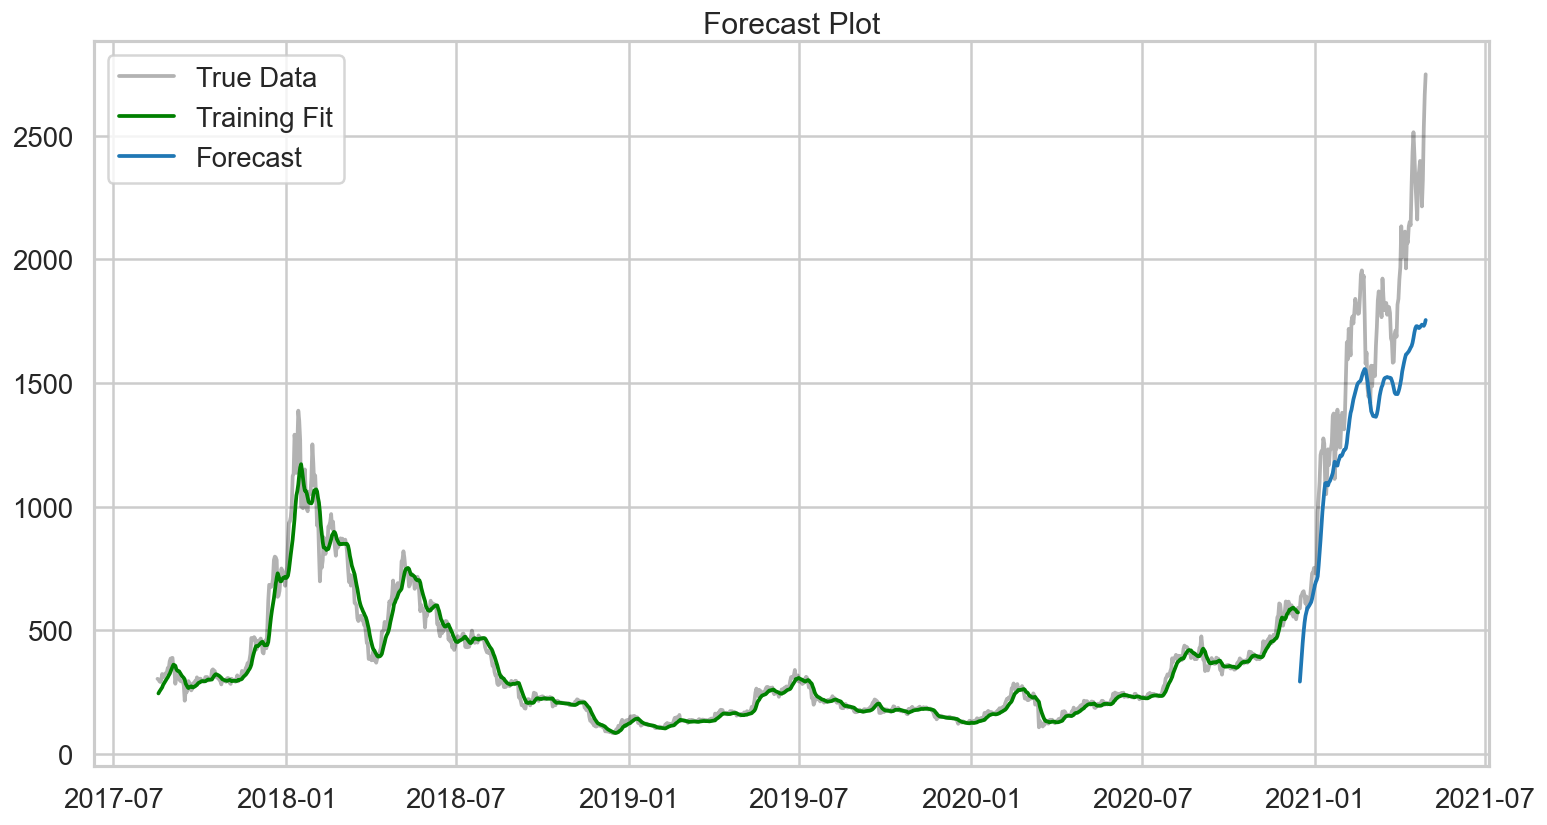

In [52]:
# inverse transformation
trainPredict = scaler.inverse_transform(trainPredict.reshape(trainPredict.shape[1],1))
testPredict = scaler.inverse_transform(testPredict.reshape(testPredict.shape[1],1))

train_size = len(trainPredict)+1

# plot the true and forecasted values
plt.plot(df.index,
df.open.values,c='black',
alpha=0.3,label='True Data')

plt.plot(df.index[1:train_size],
trainPredict,
label='Training Fit',c='g')

plt.plot(df.index[train_size+1:],
testPredict[:test_x.shape[1]],
label='Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()

***
# Part Four: Using tsai
***

In [53]:
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.18
fastai     : 2.3.1
fastcore   : 1.3.20
torch      : 1.8.1+cpu


In [54]:
from ipynb.fs.full.lstm_utils import get_reg_train_test

WINDOW=10
PRED_LENGTH=5
x_train, y_train, x_test, y_test, scaler=get_reg_train_test(df.open,train_size=0.95, 
                                                            sequence_length=WINDOW+1,
                                                           roll_mean_window=None,
                                                           normalize=False,
                                                           scale=False)
print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

x_train shape=(1274, 10, 1)
y_train shape=(1274,)
x_test shape=(67, 10, 1)
y_test shape=(67,)


In [55]:
X=np.concatenate((x_train, x_test), axis=0)
X.shape

(1341, 10, 1)

In [56]:
X

array([[[ 303.61],
        [ 302.  ],
        [ 293.96],
        ...,
        [ 315.74],
        [ 323.42],
        [ 327.24]],

       [[ 302.  ],
        [ 293.96],
        [ 290.91],
        ...,
        [ 323.42],
        [ 327.24],
        [ 330.79]],

       [[ 293.96],
        [ 290.91],
        [ 299.1 ],
        ...,
        [ 327.24],
        [ 330.79],
        [ 348.13]],

       ...,

       [[2422.38],
        [2317.65],
        [2235.65],
        ...,
        [2367.39],
        [2214.08],
        [2320.44]],

       [[2317.65],
        [2235.65],
        [2161.12],
        ...,
        [2214.08],
        [2320.44],
        [2532.06]],

       [[2235.65],
        [2161.12],
        [2330.26],
        ...,
        [2320.44],
        [2532.06],
        [2666.13]]])

In [57]:
X=np.reshape(X, (X.shape[0], X.shape[2], X.shape[1]))
X.shape

(1341, 1, 10)

In [58]:
X

array([[[ 303.61,  302.  ,  293.96, ...,  315.74,  323.42,  327.24]],

       [[ 302.  ,  293.96,  290.91, ...,  323.42,  327.24,  330.79]],

       [[ 293.96,  290.91,  299.1 , ...,  327.24,  330.79,  348.13]],

       ...,

       [[2422.38, 2317.65, 2235.65, ..., 2367.39, 2214.08, 2320.44]],

       [[2317.65, 2235.65, 2161.12, ..., 2214.08, 2320.44, 2532.06]],

       [[2235.65, 2161.12, 2330.26, ..., 2320.44, 2532.06, 2666.13]]])

In [59]:
y=np.concatenate((y_train, y_test), axis=0)
y.shape

(1341,)

In [60]:
y

array([ 330.79,  348.13,  346.  , ..., 2532.06, 2666.13, 2748.23])

In [61]:
splits=(list(range(0,int(X.shape[0]*0.95))),list(range(int(X.shape[0]*0.95)+1,X.shape[0])))

X      - shape: [1341 samples x 1 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1341,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1273, 67]  overlap: [False]


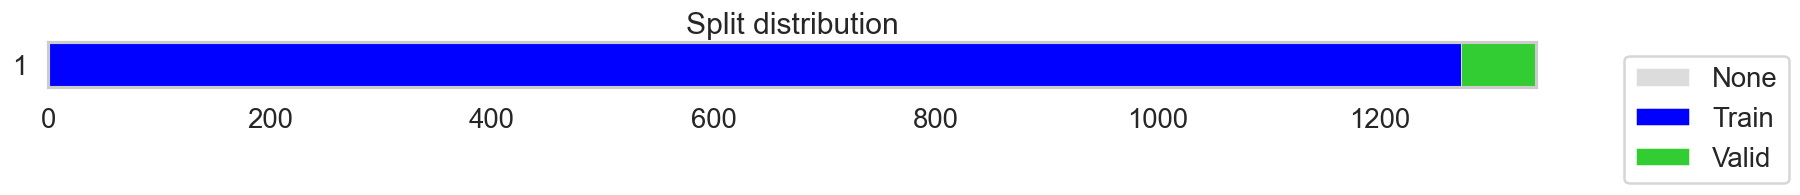

In [62]:
check_data(X, y, splits)

In [63]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:128, vars:1, len:10),
 tensor([1232.5000,  170.7300,  152.0800,  183.6300, 1150.3700,  387.8800,
          385.9100,  130.7200,  635.1500,  207.3000,  343.1400,  189.0500,
          115.1300,  138.3600,  137.2800,  285.1800,  688.5500, 1208.7500,
          392.4000,  253.3500,  158.4600,  196.2400,  331.2300,   91.1800,
          268.1600,  187.0800,  295.4400,  331.8800,  169.2600,  297.3000,
          752.1700,  395.1000,  231.7400,  218.0100,  344.1800,  174.7000,
          212.9000,  121.8800,  232.1000,  194.8700,  267.7300,  200.4400,
          154.5400,  172.9200,  207.0200,  353.6300,  196.3300,  224.0000,
         1376.7200,  679.7600,  971.0000,  157.3300,  220.2400,  616.8000,
          230.9900,  181.5300,  350.9400,  310.9500,  496.4500,  683.9900,
          142.8000,  145.5300,  164.2400,  220.6300,  378.5800,  410.6200,
          145.8100,  310.8000,  200.9200,  721.0000, 1366.5400,  567.2400,
          174.0000,  205.8500,  157.8600,  408.7700,  274.17

In [64]:
dls.c


1

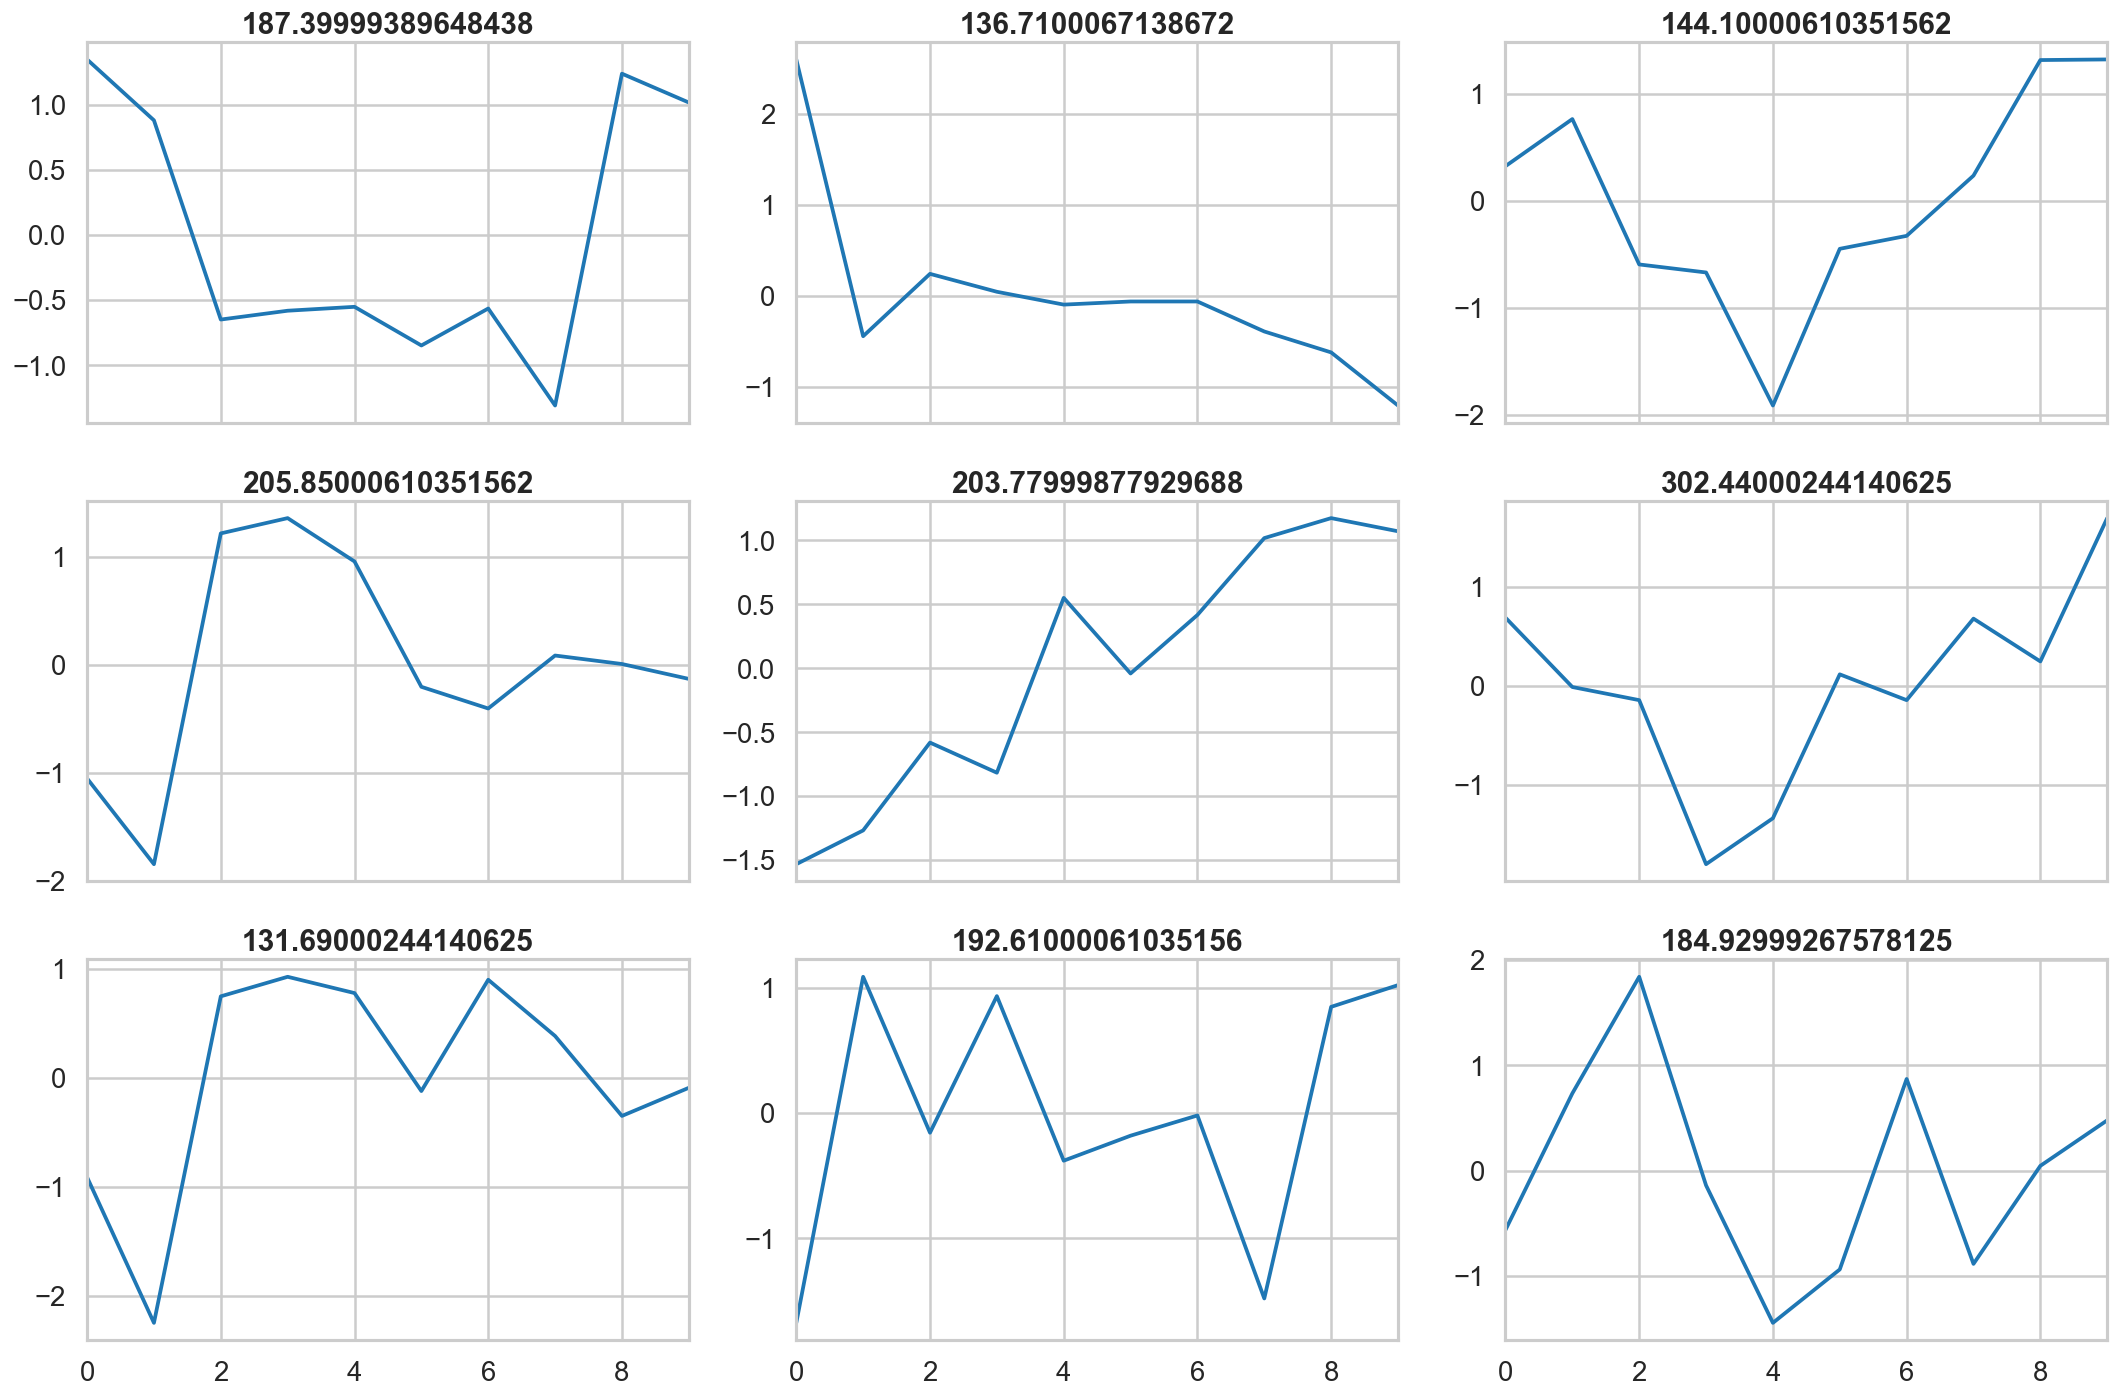

In [65]:
dls.show_batch()

In [66]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())

SuggestedLRs(lr_min=0.33113112449646, lr_steep=9.12010818865383e-07)

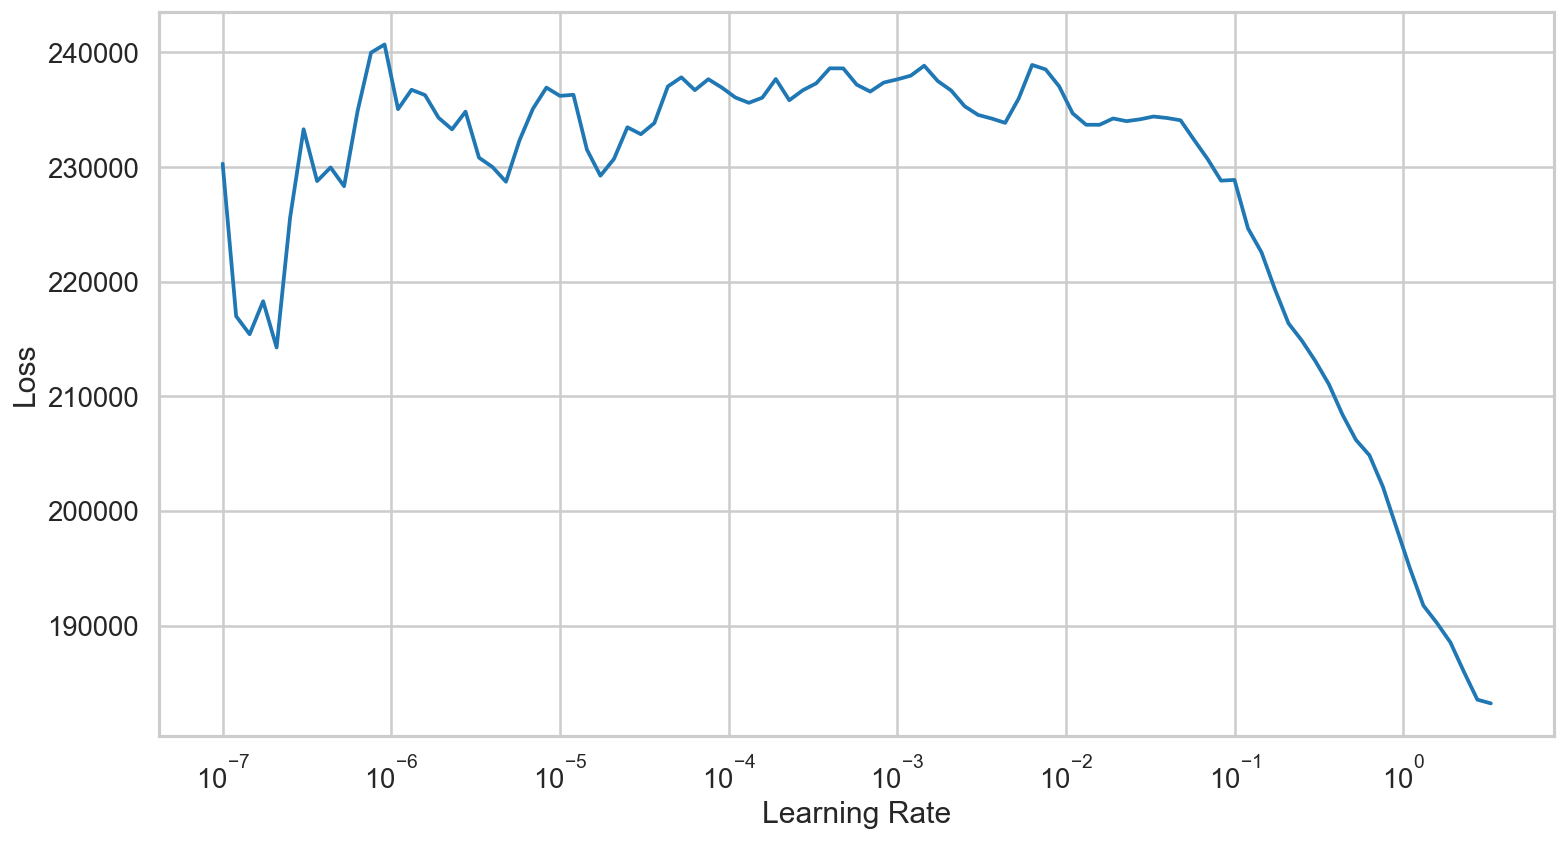

In [67]:
learn.lr_find()

In [68]:
learn.loss_func

FlattenedLoss of MSELoss()

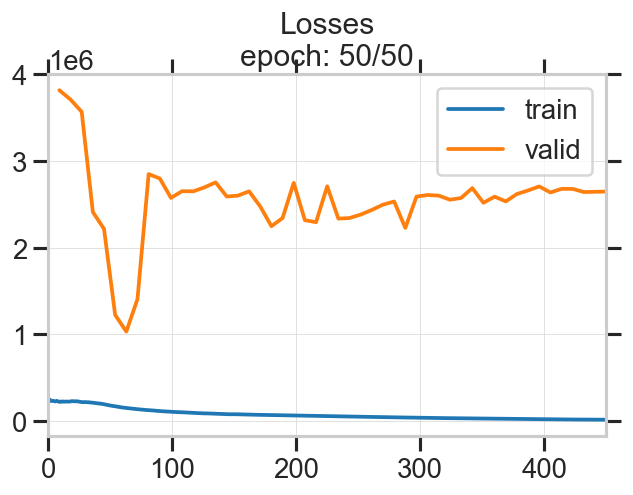

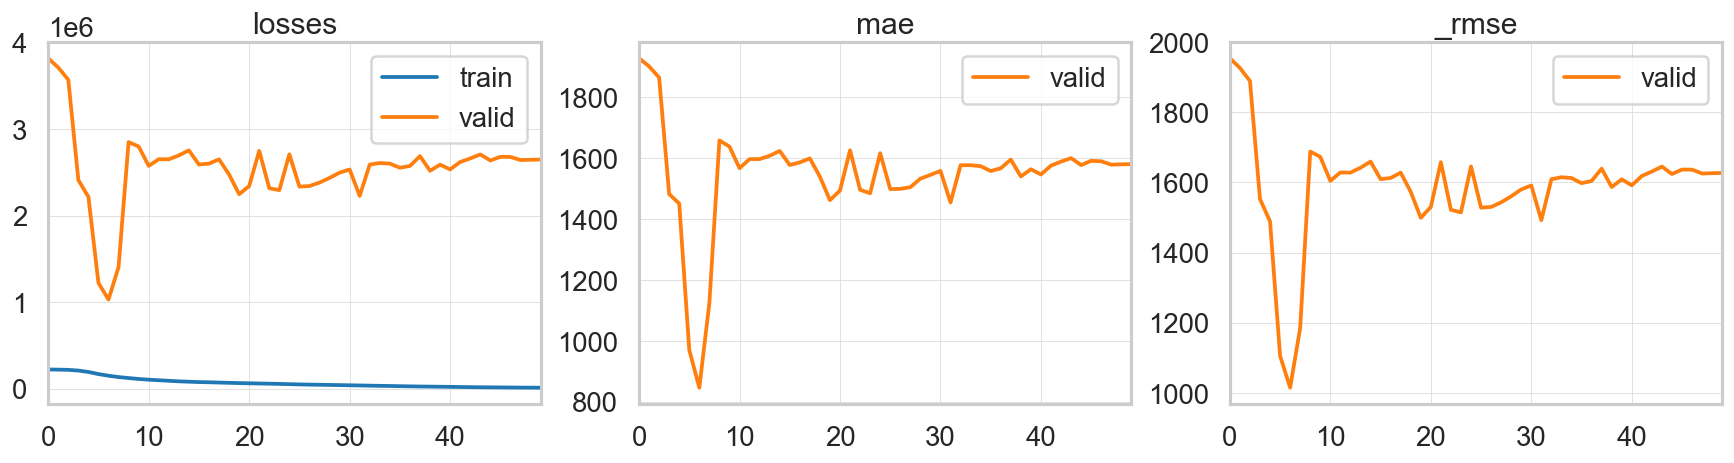

In [69]:
learn.fit_one_cycle(50, 1e-1)

In [70]:
valid_preds, valid_targets = learn.get_preds(ds_idx=1)
valid_preds.flatten().data, valid_targets.data

(tensor([ 242.5558,  271.6865,  728.4852, 1347.9003,  600.6828,  590.0629,
          447.0534,  375.0667,  281.9623,  271.3162,  266.6048,  265.8008,
          173.1074,  193.9858,  200.1550,  276.8652,  397.5797,  740.8916,
          596.6755,  547.6071,  441.3446,  337.8215,  376.2944,  273.4842,
          203.3543,  193.4635,  151.0626,  168.6491,  167.8217,  187.6426,
          219.2992,  216.8484,  404.1861,  352.1103,  315.5699,  354.7878,
          460.3668,  251.1154,  239.0098,  319.5560,  627.9341,  277.8748,
          282.5483,  174.3175,  427.9447,  269.3957,  296.9291,  233.6105,
          399.9807,  752.1799,  350.3487,  372.6154,  353.1433,  237.7576,
          534.4309,  227.8342,  184.4213,  223.8121,  507.9093,  484.7143,
          422.9136,  236.9713,  276.3016,  310.7567,  216.6535,  301.7966,
          374.2745]),
 tensor([1933.5400, 1777.4200, 1577.7900, 1623.1600, 1482.0800, 1444.5601,
         1458.2700, 1418.6700, 1570.0000, 1486.7900, 1567.6801, 1539.2200,
   

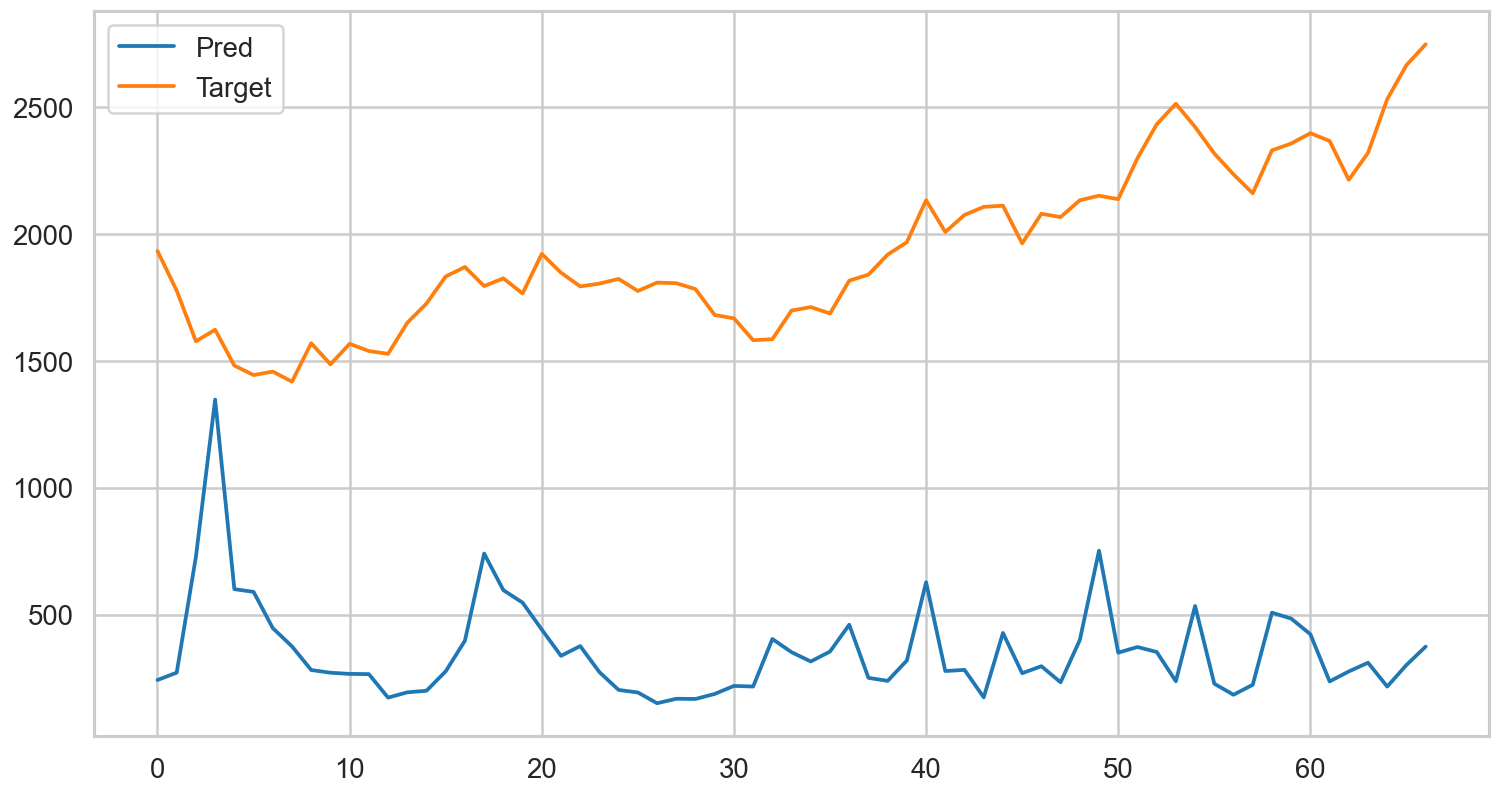

In [71]:
plt.plot(valid_preds, label='Pred')
plt.plot(valid_targets, label='Target')
plt.legend()
plt.show()


***
# Part Five: Using MLP
***

X-train shape=(1210, 6)
y-train shape=(1210,)
X-test shape=(135, 6)
y-test shape=(135,)
RMSE: 11.759189


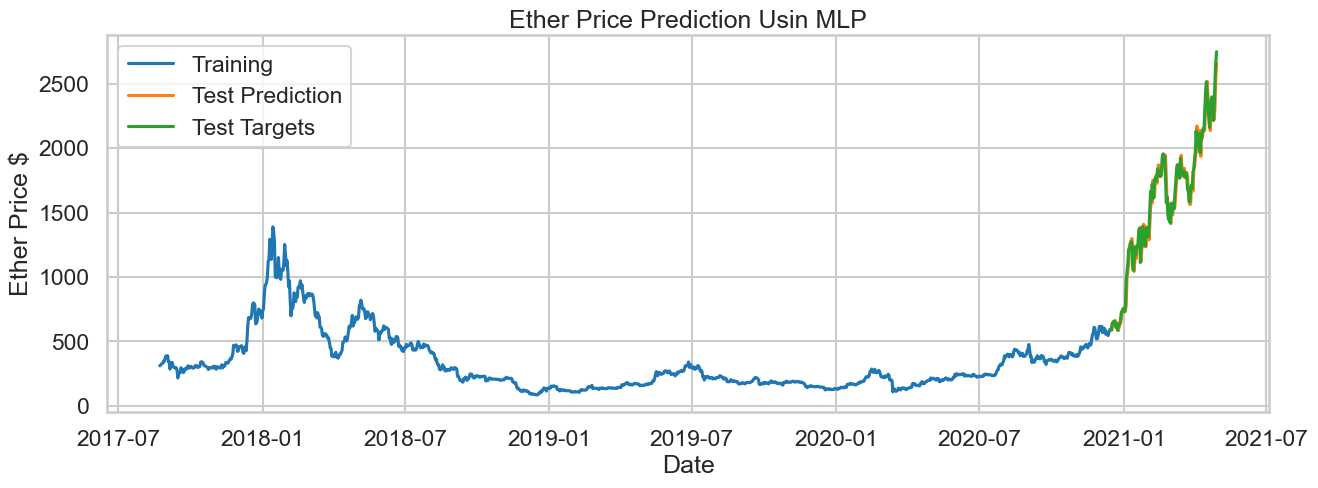

In [137]:
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

price_seq = df.open.values
from ipynb.fs.full.DLTS import split_sequence1
n_steps=6
X, y = split_sequence1(price_seq, n_steps)
X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 

X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index=df.index[int(len(X)*0.9)+n_steps:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))

model= Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=2000, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.legend()
plt.title('Ether Price Prediction Usin MLP')
plt.ylabel('Ether Price $')
plt.xlabel('Date')
plt.show()

X-train shape=(1208, 6)
y-train shape=(1208, 3)
X-test shape=(135, 6)
y-test shape=(135, 3)
RMSE: 51.856517


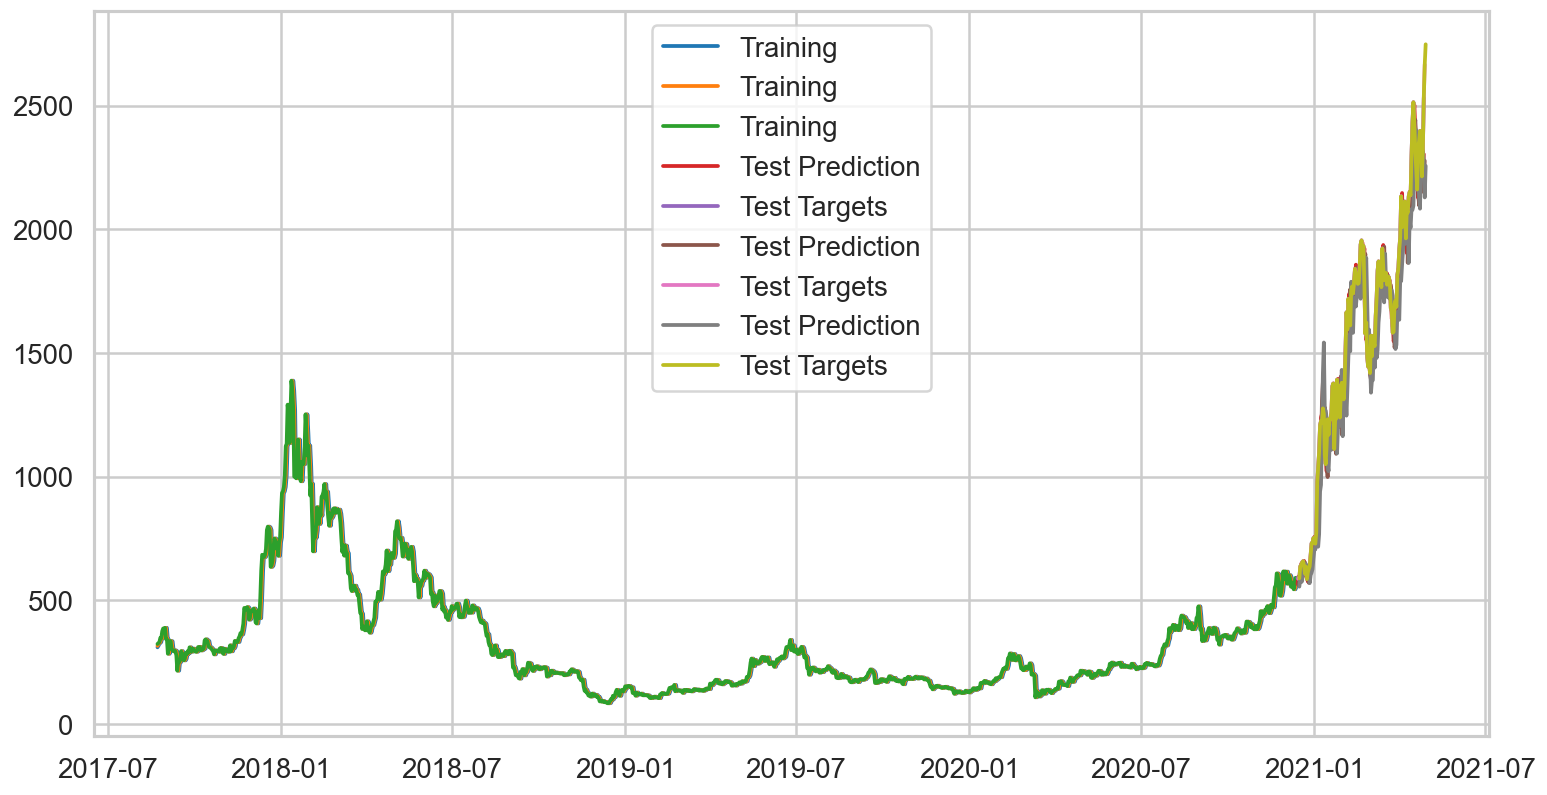

In [73]:
# multistep forecasting

from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

price_seq = df.open.values
from ipynb.fs.full.DLTS import split_sequence2
n_steps_in=6
n_steps_out=3
X, y = split_sequence2(price_seq, n_steps_in, n_steps_out)
X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 


X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index1=df.index[int(len(X)*0.9)+n_steps_in:-2]
test_index2=df.index[int(len(X)*0.9)+n_steps_in+1:-1]
test_index3=df.index[int(len(X)*0.9)+n_steps_in+2:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))

model= Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=2000, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index1, y_hat[:,0], label='Test Prediction')
plt.plot(test_index1, y_test[:,0], label='Test Targets')
plt.plot(test_index2, y_hat[:,1], label='Test Prediction')
plt.plot(test_index2, y_test[:,1], label='Test Targets')
plt.plot(test_index3, y_hat[:,2], label='Test Prediction')
plt.plot(test_index3, y_test[:,2], label='Test Targets')
plt.legend()
plt.show()

***

# Part Six: Using CNN

***

In [74]:
from ipynb.fs.full.DLTS import split_sequence1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D


X-train shape=(1210, 6, 1)
y-train shape=(1210,)
X-test shape=(135, 6, 1)
y-test shape=(135,)
RMSE: 39.265765


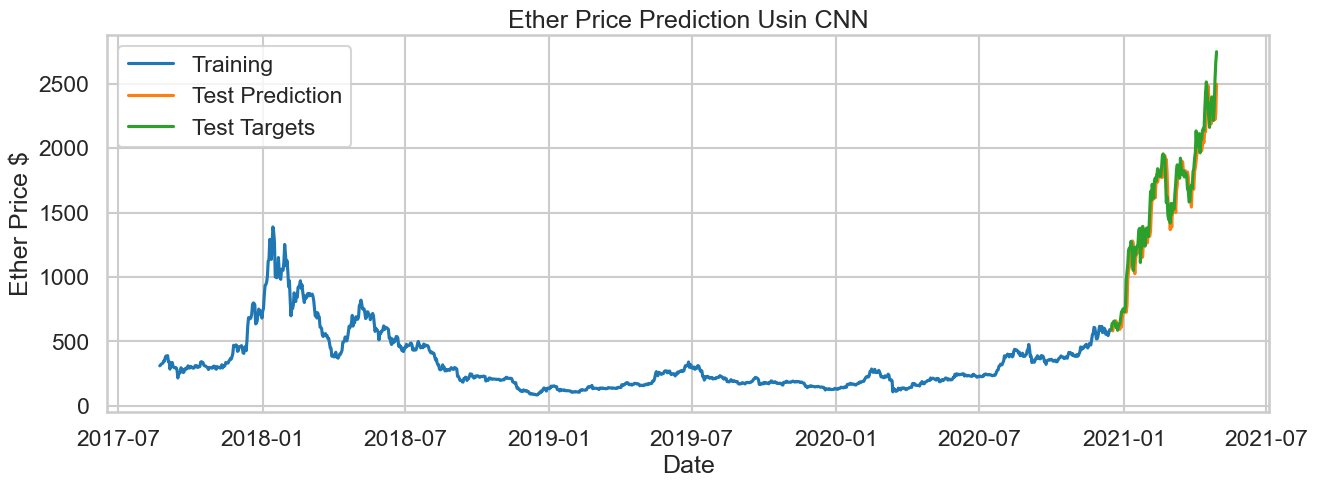

In [138]:
price_seq = df.open.values

n_steps=6
n_features=1

X, y = split_sequence1(price_seq, n_steps)
X=X.reshape((X.shape[0], X.shape[1], n_features))

X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 

X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index=df.index[int(len(X)*0.9)+n_steps:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))

# define CNN model
model=Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X_train, y_train, epochs=1000, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.title('Ether Price Prediction Usin CNN')
plt.ylabel('Ether Price $')
plt.xlabel('Date')
plt.legend()
plt.show()

***

# Part Seven: Using LSTM

***

In [76]:
from ipynb.fs.full.DLTS import split_sequence1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from ipynb.fs.full.DLTS import split_sequence2
from tensorflow.keras.layers import RepeatVector

In [77]:
price_seq = df.open.values

n_steps=6
n_features=1

X, y = split_sequence1(price_seq, n_steps)
X=X.reshape((X.shape[0], X.shape[1], n_features))

X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 

X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index=df.index[int(len(X)*0.9)+n_steps:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))

X-train shape=(1210, 6, 1)
y-train shape=(1210,)
X-test shape=(135, 6, 1)
y-test shape=(135,)


RMSE: 34.691387


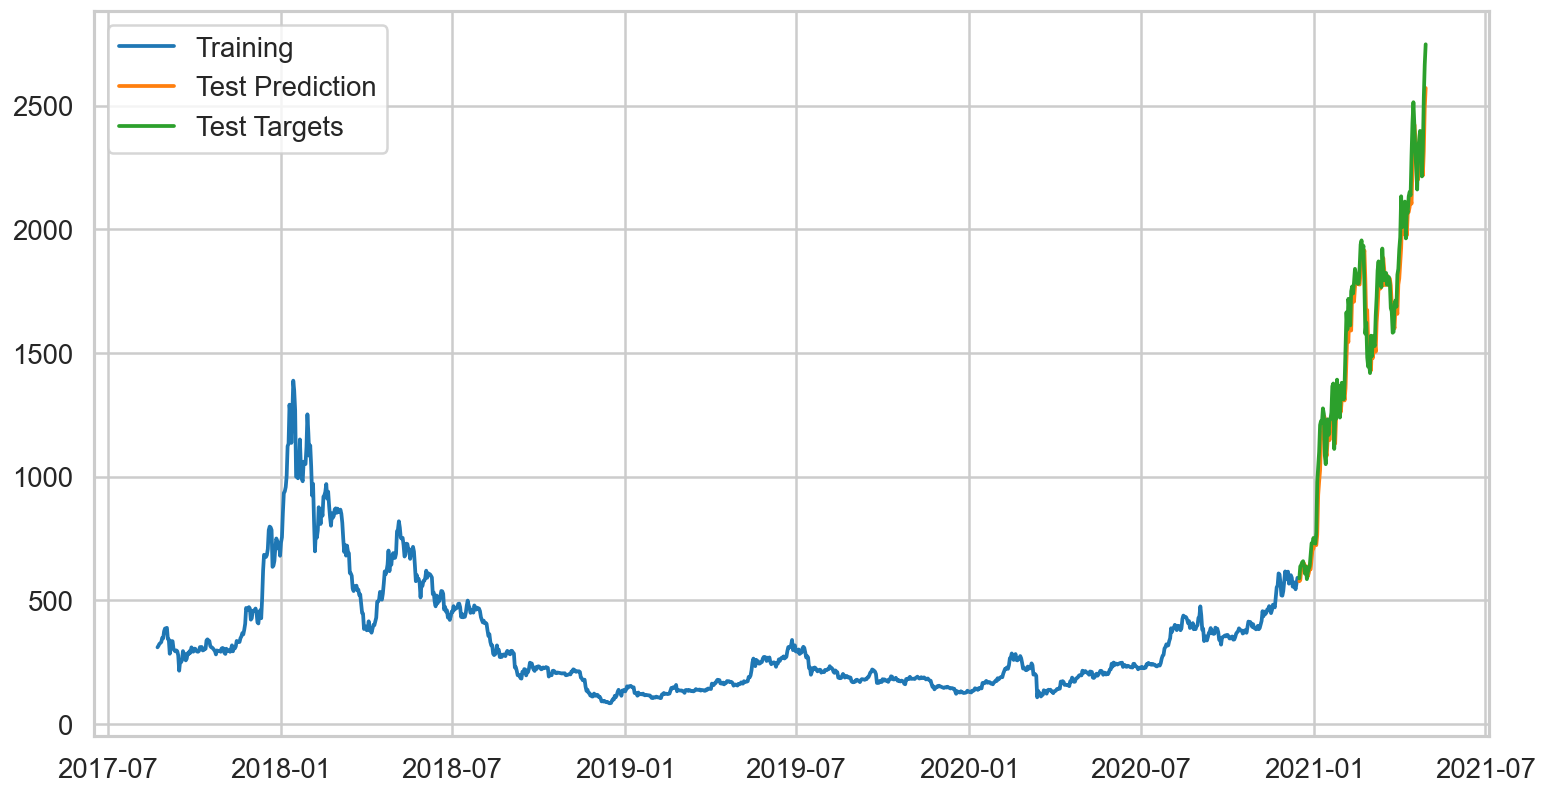

In [78]:
# vanilla LSTM
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=200, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.legend()
plt.show()

RMSE: 37.848133


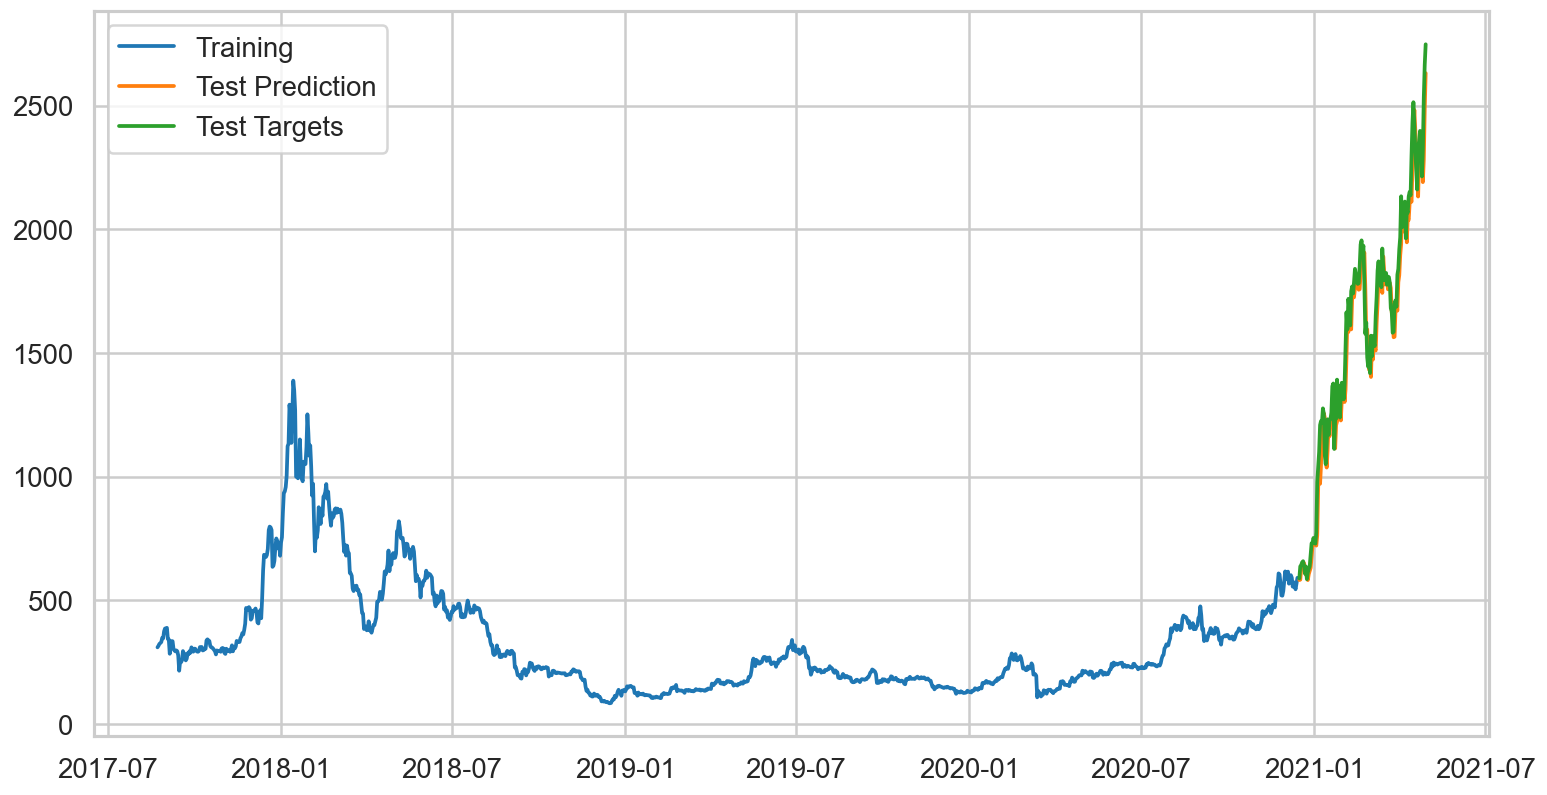

In [79]:
# Stacked LSTM
model=Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=200, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.legend()
plt.show()

RMSE: 32.382597


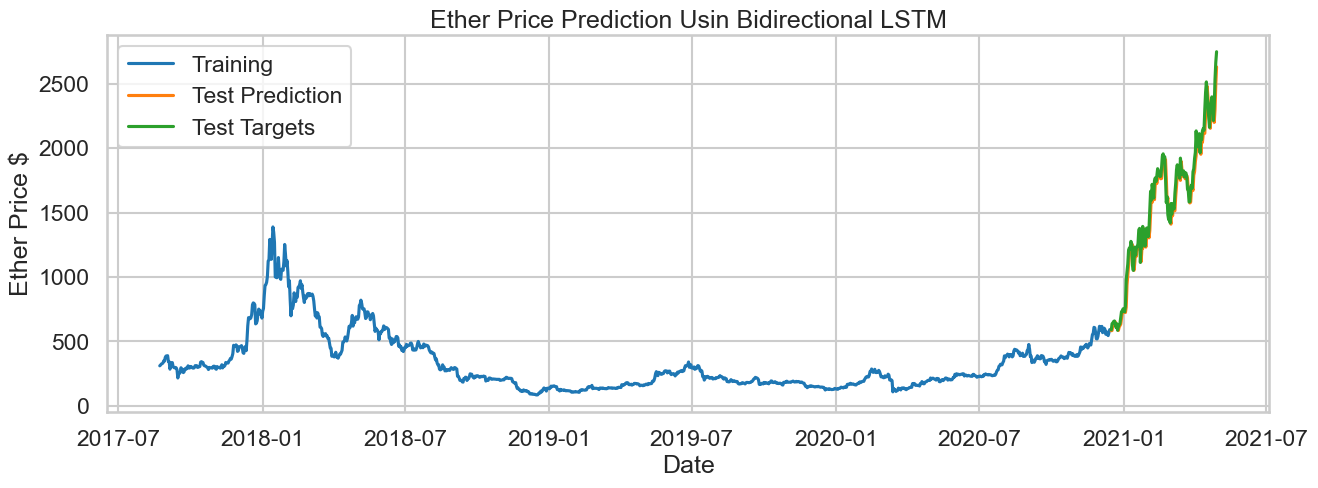

In [139]:
# Bidirectional LSTM
model=Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=200, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.title('Ether Price Prediction Usin Bidirectional LSTM')
plt.ylabel('Ether Price $')
plt.xlabel('Date')
plt.legend()
plt.show()

X-train shape=(1210, 2, 3, 1)
y-train shape=(1210,)
X-test shape=(135, 2, 3, 1)
y-test shape=(135,)
RMSE: 90.785208


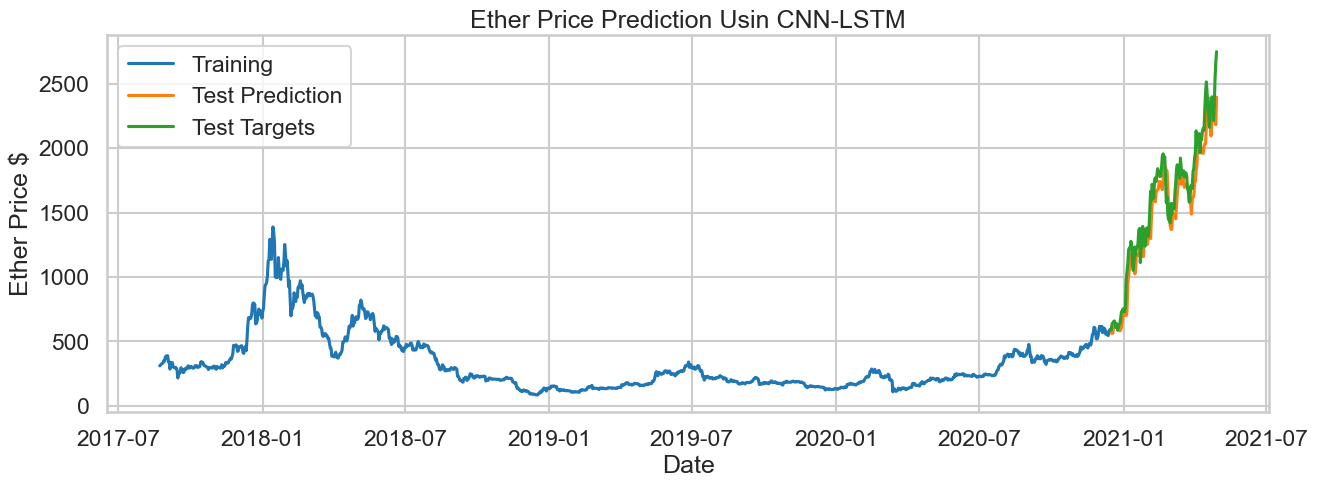

In [140]:
# CNN-LSTM

n_steps=6
n_features=1
X, y = split_sequence1(price_seq, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_seq = 2
n_stepsN = 3

X=X.reshape((X.shape[0], n_seq, n_stepsN, n_features))

X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 

X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index=df.index[int(len(X)*0.9)+n_steps:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))


model=Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                          input_shape=(None, n_stepsN, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=500, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.title('Ether Price Prediction Usin CNN-LSTM')
plt.ylabel('Ether Price $')
plt.xlabel('Date')
plt.legend()
plt.show()

X-train shape=(1210, 2, 1, 3, 1)
y-train shape=(1210,)
X-test shape=(135, 2, 1, 3, 1)
y-test shape=(135,)
RMSE: 26.391660


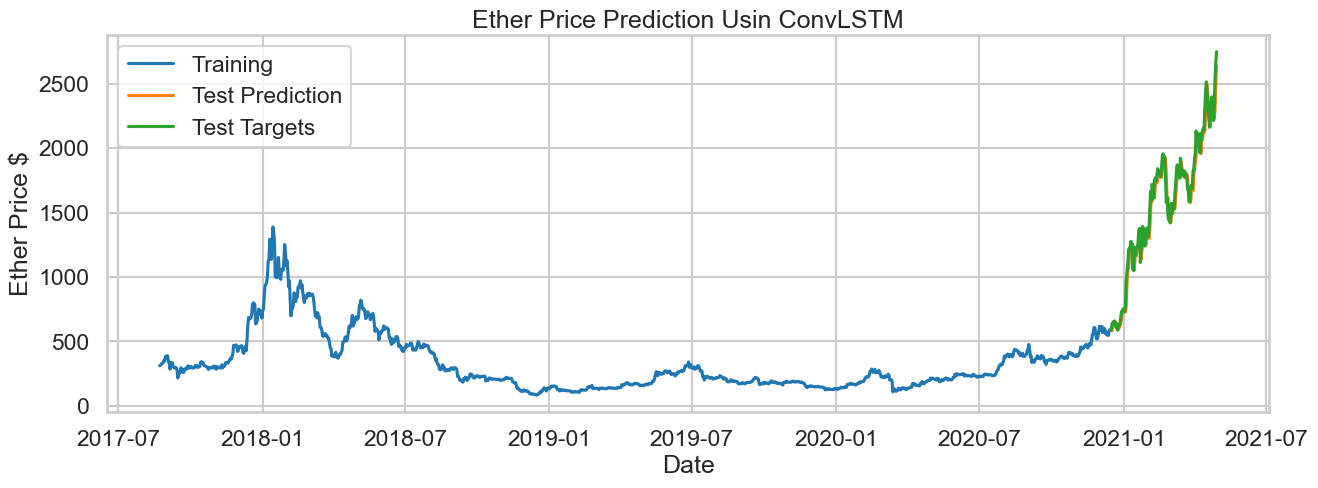

In [141]:
# ConvLSTM

n_steps=6
n_features=1
X, y = split_sequence1(price_seq, n_steps)

# reshape from [samples, timesteps] into [samples, Timesteps, rows, columns, features]
n_seq = 2
n_stepsN = 3

X=X.reshape((X.shape[0], n_seq, 1, n_stepsN, n_features))

X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 

X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index=df.index[int(len(X)*0.9)+n_steps:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))


model=Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu',
                          input_shape=(n_seq, 1, n_stepsN, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=500, verbose=0)

# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train, label='Training')
plt.plot(test_index, y_hat, label='Test Prediction')
plt.plot(test_index, y_test, label='Test Targets')
plt.title('Ether Price Prediction Usin ConvLSTM')
plt.ylabel('Ether Price $')
plt.xlabel('Date')
plt.legend()
plt.show()

X-train shape=(1208, 6, 1)
y-train shape=(1208, 3, 1)
X-test shape=(135, 6, 1)
y-test shape=(135, 3, 1)
RMSE: 58.984609


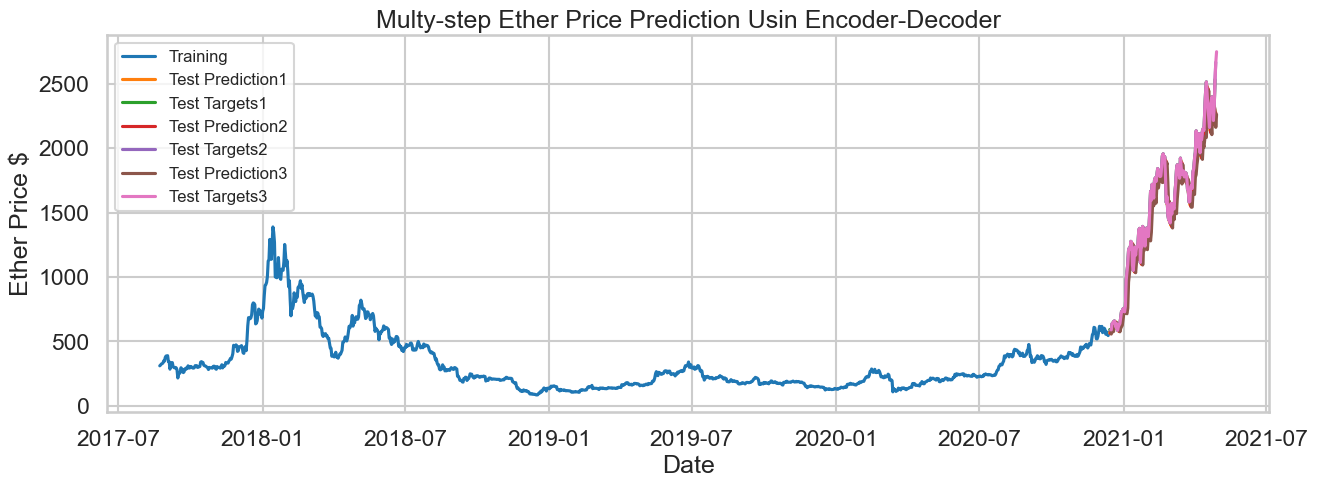

In [142]:
# multystep forecasting using encoder-decoder


price_seq = df.open.values

n_steps_in=6
n_steps_out=3
n_features=1

X, y = split_sequence2(price_seq, n_steps_in, n_steps_out)
X=X.reshape((X.shape[0], X.shape[1], n_features))
y=y.reshape((y.shape[0], y.shape[1], n_features))

X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
train_index=df.index[n_steps:int(len(X)*0.9)+n_steps] 


X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]
test_index1=df.index[int(len(X)*0.9)+n_steps_in:-2]
test_index2=df.index[int(len(X)*0.9)+n_steps_in+1:-1]
test_index3=df.index[int(len(X)*0.9)+n_steps_in+2:]

print('X-train shape={}'.format( X_train.shape))
print('y-train shape={}'.format(y_train.shape))
print('X-test shape={}'.format(X_test.shape))
print('y-test shape={}'.format(y_test.shape))

model= Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=500, verbose=0)
# prediction
y_hat=model.predict(X_test, verbose=0)

rmse=(np.mean(y_hat - y_test)**2)**0.5
print('RMSE: %f' %rmse)
plt.plot(train_index, y_train[:,0], label='Training')
plt.plot(test_index1, y_hat[:,0], label='Test Prediction1')
plt.plot(test_index1, y_test[:,0], label='Test Targets1')
plt.plot(test_index2, y_hat[:,1], label='Test Prediction2')
plt.plot(test_index2, y_test[:,1], label='Test Targets2')
plt.plot(test_index3, y_hat[:,2], label='Test Prediction3')
plt.plot(test_index3, y_test[:,2], label='Test Targets3')
plt.title('Multy-step Ether Price Prediction Usin Encoder-Decoder')
plt.ylabel('Ether Price $')
plt.xlabel('Date')
plt.legend(loc='best', fontsize=12)
plt.show()